In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/CIRUGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=129.5, y1=109.2
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 199
Page 1, Q1, A: Yellow percentage: 0.0%


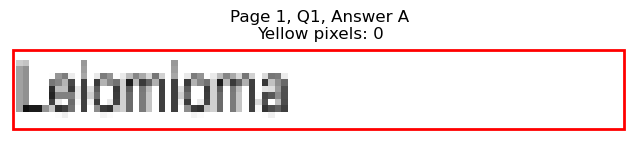

Page 1, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=150.5, y1=121.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 306
Page 1, Q1, B: Yellow percentage: 0.0%


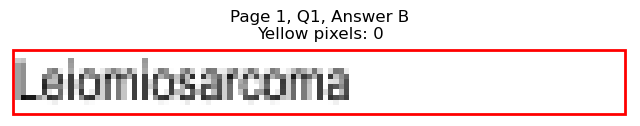

Page 1, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=139.1, y1=133.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 270
Page 1, Q1, C: Yellow percentage: 0.0%


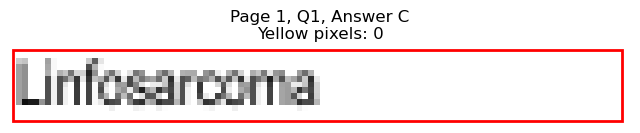

Page 1, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=403.8, y1=109.2
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 332
Page 1, Q1, D: Yellow percentage: 0.0%


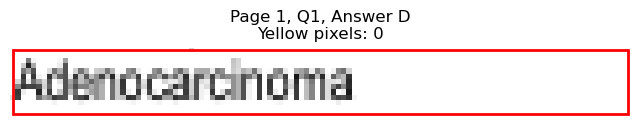

Page 1, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=359.1, y1=121.3
Page 1, Q1, E: Yellow pixels: 804
Page 1, Q1, E: Total non-white pixels: 962
Page 1, Q1, E: Yellow percentage: 83.6%


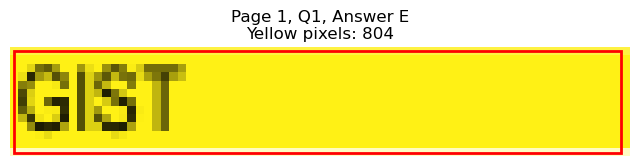


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=192.3, y1=169.4
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 514
Page 1, Q2, A: Yellow percentage: 0.0%


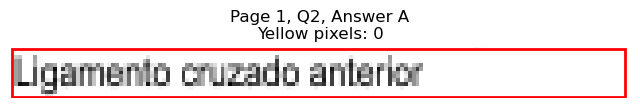

Page 1, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=147.3, y1=181.5
Page 1, Q2, B: Yellow pixels: 114
Page 1, Q2, B: Total non-white pixels: 446
Page 1, Q2, B: Yellow percentage: 25.6%


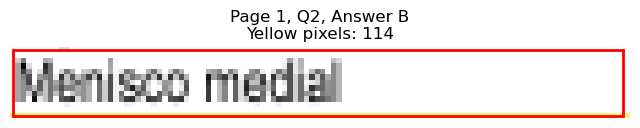

Page 1, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=196.6, y1=193.5
Page 1, Q2, C: Yellow pixels: 1680
Page 1, Q2, C: Total non-white pixels: 2119
Page 1, Q2, C: Yellow percentage: 79.3%


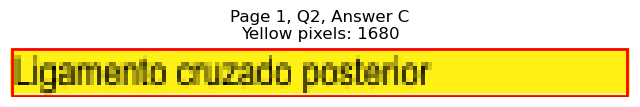

Page 1, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=397.0, y1=169.4
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 320
Page 1, Q2, D: Yellow percentage: 0.0%


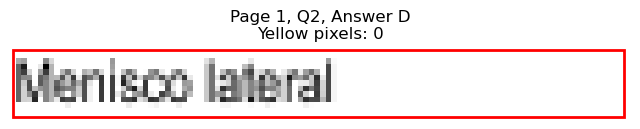

Page 1, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=440.1, y1=181.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 551
Page 1, Q2, E: Yellow percentage: 0.0%


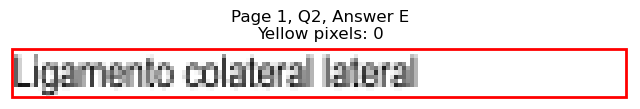


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=115.7, y1=241.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 147
Page 1, Q3, A: Yellow percentage: 0.0%


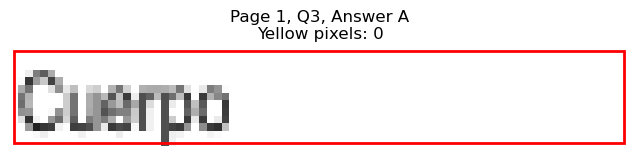

Page 1, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=159.1, y1=253.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 381
Page 1, Q3, B: Yellow percentage: 0.0%


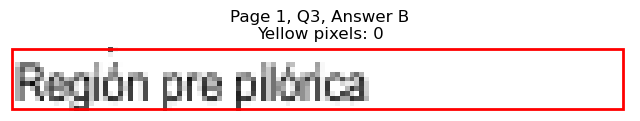

Page 1, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=108.0, y1=265.8
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 109
Page 1, Q3, C: Yellow percentage: 0.0%


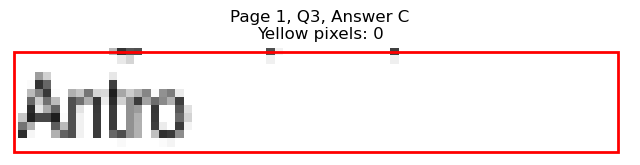

Page 1, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=368.7, y1=241.8
Page 1, Q3, D: Yellow pixels: 867
Page 1, Q3, D: Total non-white pixels: 1079
Page 1, Q3, D: Yellow percentage: 80.4%


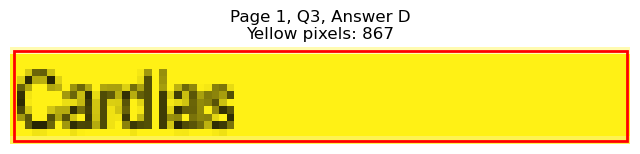

Page 1, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=363.4, y1=253.8
Page 1, Q3, E: Yellow pixels: 78
Page 1, Q3, E: Total non-white pixels: 205
Page 1, Q3, E: Yellow percentage: 38.0%


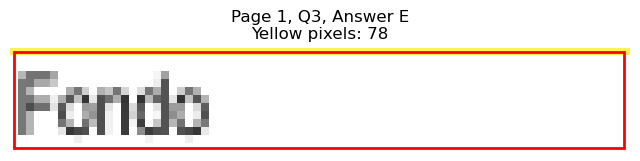


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=167.4, y1=302.0
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 445
Page 1, Q4, A: Yellow percentage: 0.0%


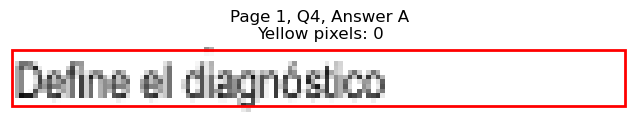

Page 1, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=245.3, y1=314.0
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 817
Page 1, Q4, B: Yellow percentage: 0.0%


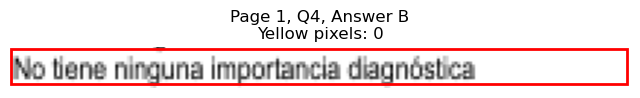

Page 1, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=185.5, y1=326.0
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 502
Page 1, Q4, C: Yellow percentage: 0.0%


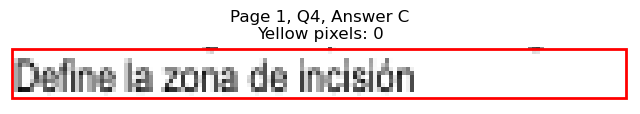

Page 1, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=473.6, y1=302.0
Page 1, Q4, D: Yellow pixels: 188
Page 1, Q4, D: Total non-white pixels: 1074
Page 1, Q4, D: Yellow percentage: 17.5%


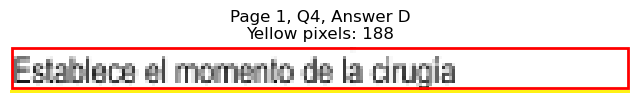

Page 1, Q4 - E: Detected box: x0=336.7, y0=301.9, x1=503.7, y1=314.0
Page 1, Q4, E: Yellow pixels: 1626
Page 1, Q4, E: Total non-white pixels: 2471
Page 1, Q4, E: Yellow percentage: 65.8%


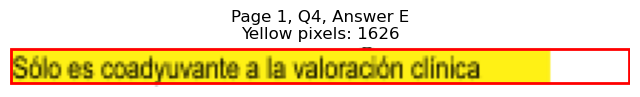


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=350.2, x1=99.9, y1=362.3
Page 1, Q5, A: Yellow pixels: 66
Page 1, Q5, A: Total non-white pixels: 121
Page 1, Q5, A: Yellow percentage: 54.5%


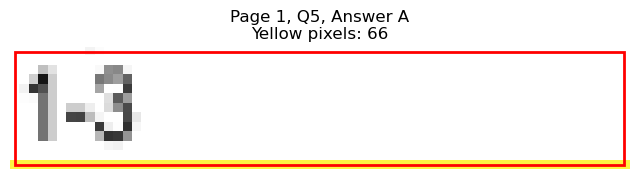

Page 1, Q5 - B: Detected box: x0=85.0, y0=362.2, x1=104.7, y1=374.3
Page 1, Q5, B: Yellow pixels: 793
Page 1, Q5, B: Total non-white pixels: 923
Page 1, Q5, B: Yellow percentage: 85.9%


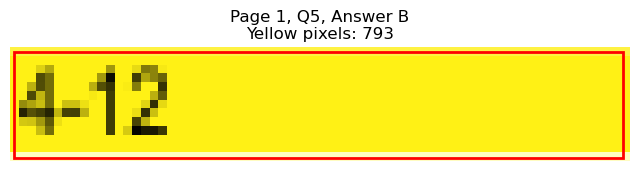

Page 1, Q5 - C: Detected box: x0=85.0, y0=374.2, x1=109.5, y1=386.3
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 188
Page 1, Q5, C: Yellow percentage: 0.0%


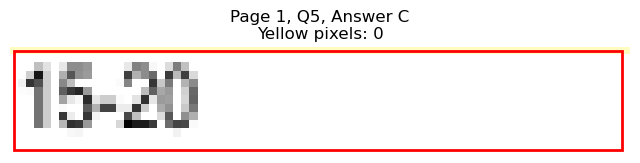

Page 1, Q5 - D: Detected box: x0=336.7, y0=350.2, x1=361.2, y1=362.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 120
Page 1, Q5, D: Yellow percentage: 0.0%


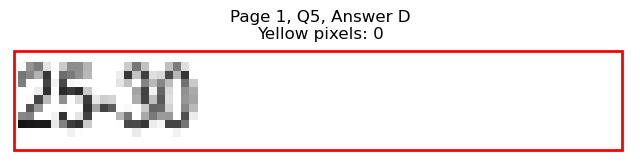

Page 1, Q5 - E: Detected box: x0=336.7, y0=362.2, x1=397.0, y1=374.3
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 311
Page 1, Q5, E: Yellow percentage: 0.0%


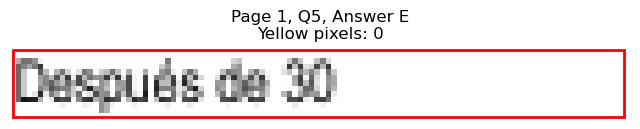


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=410.4, x1=146.3, y1=422.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 318
Page 1, Q6, A: Yellow percentage: 0.0%


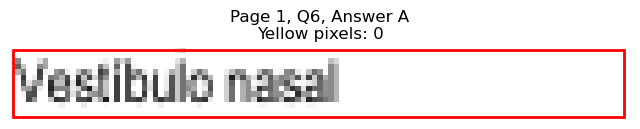

Page 1, Q6 - B: Detected box: x0=85.0, y0=422.4, x1=140.1, y1=434.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 277
Page 1, Q6, B: Yellow percentage: 0.0%


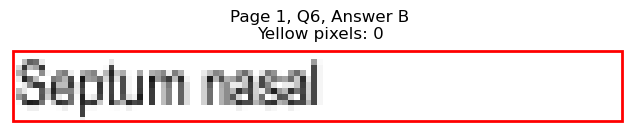

Page 1, Q6 - C: Detected box: x0=85.0, y0=434.4, x1=141.5, y1=446.5
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 283
Page 1, Q6, C: Yellow percentage: 0.0%


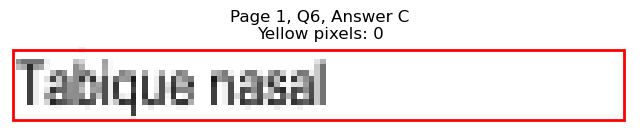

Page 1, Q6 - D: Detected box: x0=336.7, y0=410.4, x1=415.6, y1=422.5
Page 1, Q6, D: Yellow pixels: 1354
Page 1, Q6, D: Total non-white pixels: 1690
Page 1, Q6, D: Yellow percentage: 80.1%


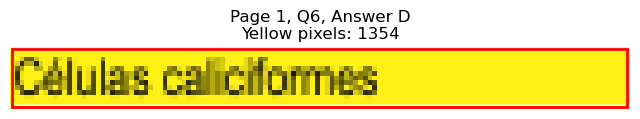

Page 1, Q6 - E: Detected box: x0=336.7, y0=422.4, x1=412.8, y1=434.5
Page 1, Q6, E: Yellow pixels: 127
Page 1, Q6, E: Total non-white pixels: 512
Page 1, Q6, E: Yellow percentage: 24.8%


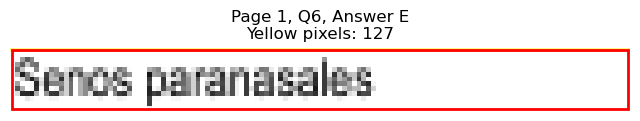


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=470.7, x1=169.2, y1=482.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 446
Page 1, Q7, A: Yellow percentage: 0.0%


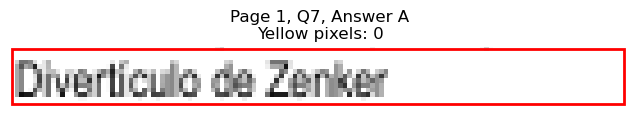

Page 1, Q7 - B: Detected box: x0=85.0, y0=482.7, x1=162.5, y1=494.8
Page 1, Q7, B: Yellow pixels: 1
Page 1, Q7, B: Total non-white pixels: 522
Page 1, Q7, B: Yellow percentage: 0.2%


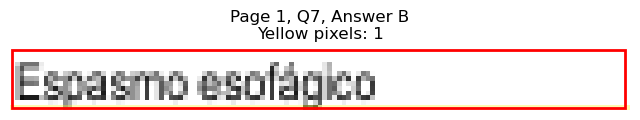

Page 1, Q7 - C: Detected box: x0=85.0, y0=494.7, x1=119.9, y1=506.8
Page 1, Q7, C: Yellow pixels: 890
Page 1, Q7, C: Total non-white pixels: 1118
Page 1, Q7, C: Yellow percentage: 79.6%


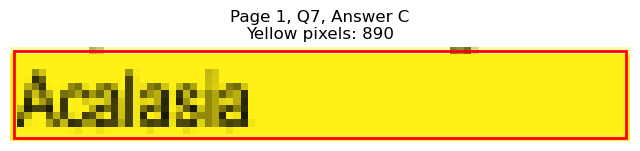

Page 1, Q7 - D: Detected box: x0=336.7, y0=470.7, x1=410.4, y1=482.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 396
Page 1, Q7, D: Yellow percentage: 0.0%


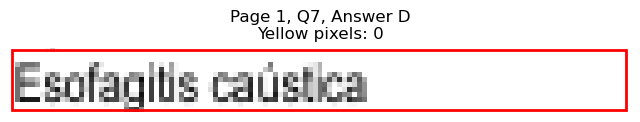

Page 1, Q7 - E: Detected box: x0=336.7, y0=482.7, x1=410.4, y1=494.8
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 387
Page 1, Q7, E: Yellow percentage: 0.0%


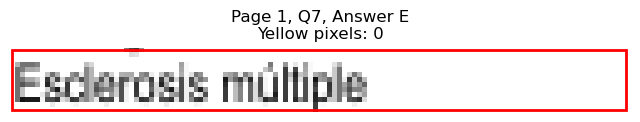


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=530.9, x1=148.7, y1=543.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 344
Page 1, Q8, A: Yellow percentage: 0.0%


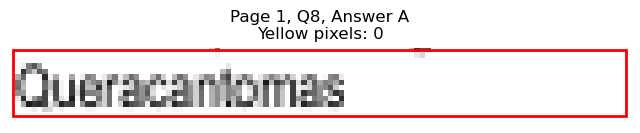

Page 1, Q8 - B: Detected box: x0=85.0, y0=542.9, x1=169.7, y1=555.0
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 421
Page 1, Q8, B: Yellow percentage: 0.0%


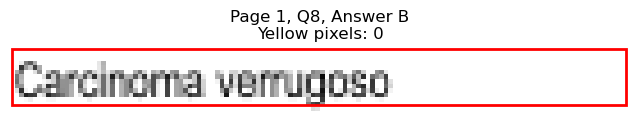

Page 1, Q8 - C: Detected box: x0=85.0, y0=554.9, x1=160.1, y1=567.0
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 402
Page 1, Q8, C: Yellow percentage: 0.0%


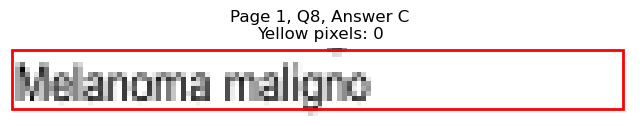

Page 1, Q8 - D: Detected box: x0=336.7, y0=530.9, x1=433.9, y1=543.0
Page 1, Q8, D: Yellow pixels: 1376
Page 1, Q8, D: Total non-white pixels: 1926
Page 1, Q8, D: Yellow percentage: 71.4%


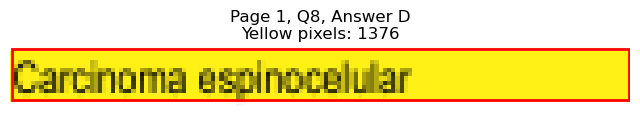

Page 1, Q8 - E: Detected box: x0=336.7, y0=542.9, x1=427.2, y1=555.0
Page 1, Q8, E: Yellow pixels: 140
Page 1, Q8, E: Total non-white pixels: 589
Page 1, Q8, E: Yellow percentage: 23.8%


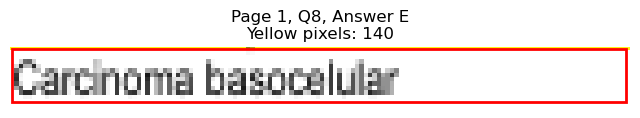


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=591.2, x1=148.2, y1=603.3
Page 1, Q9, A: Yellow pixels: 115
Page 1, Q9, A: Total non-white pixels: 420
Page 1, Q9, A: Yellow percentage: 27.4%


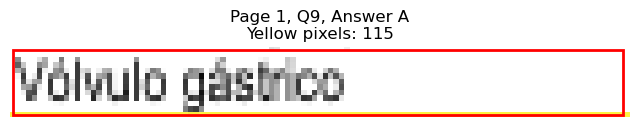

Page 1, Q9 - B: Detected box: x0=85.0, y0=603.2, x1=164.9, y1=615.3
Page 1, Q9, B: Yellow pixels: 1273
Page 1, Q9, B: Total non-white pixels: 1703
Page 1, Q9, B: Yellow percentage: 74.8%


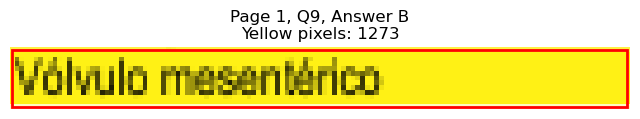

Page 1, Q9 - C: Detected box: x0=85.0, y0=615.2, x1=156.7, y1=627.3
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 497
Page 1, Q9, C: Yellow percentage: 0.0%


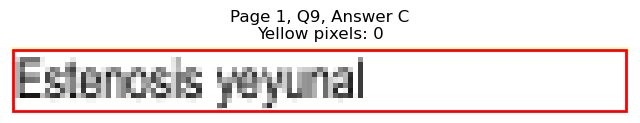

Page 1, Q9 - D: Detected box: x0=336.7, y0=591.2, x1=419.0, y1=603.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 422
Page 1, Q9, D: Yellow percentage: 0.0%


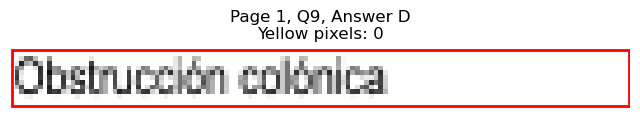

Page 1, Q9 - E: Detected box: x0=336.7, y0=603.2, x1=400.3, y1=615.3
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 326
Page 1, Q9, E: Yellow percentage: 0.0%


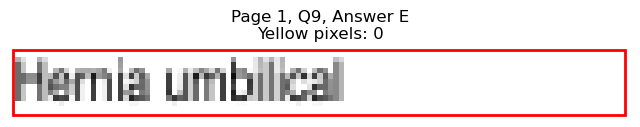


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=85.0, y0=651.4, x1=224.8, y1=663.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 697
Page 1, Q10, A: Yellow percentage: 0.0%


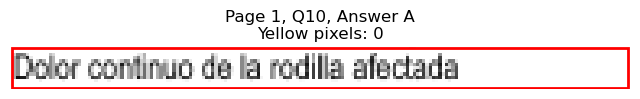

Page 1, Q10 - B: Detected box: x0=85.0, y0=663.4, x1=239.1, y1=675.5
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 756
Page 1, Q10, B: Yellow percentage: 0.0%


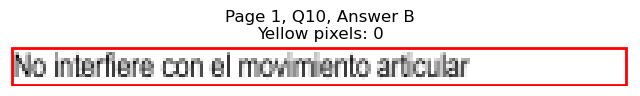

Page 1, Q10 - C: Detected box: x0=85.0, y0=675.4, x1=274.0, y1=687.5
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 938
Page 1, Q10, C: Yellow percentage: 0.0%


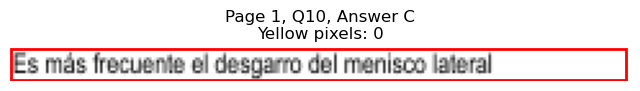

Page 1, Q10 - D: Detected box: x0=336.7, y0=651.4, x1=524.5, y1=663.5
Page 1, Q10, D: Yellow pixels: 1698
Page 1, Q10, D: Total non-white pixels: 2470
Page 1, Q10, D: Yellow percentage: 68.7%


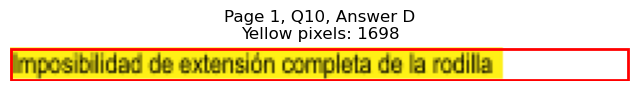

Page 1, Q10 - E: Detected box: x0=336.7, y0=663.4, x1=459.7, y1=675.5
Page 1, Q10, E: Yellow pixels: 174
Page 1, Q10, E: Total non-white pixels: 799
Page 1, Q10, E: Yellow percentage: 21.8%


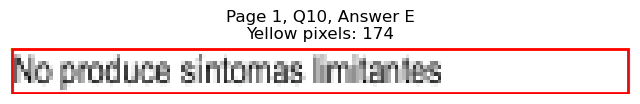


Page 1, Q10 - Selected Answer: D (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=85.0, y0=711.7, x1=166.3, y1=723.8
Page 1, Q11, A: Yellow pixels: 1247
Page 1, Q11, A: Total non-white pixels: 1729
Page 1, Q11, A: Yellow percentage: 72.1%


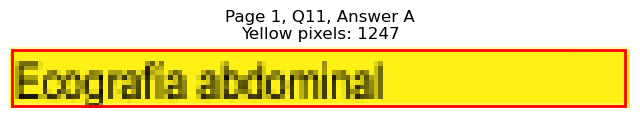

Page 1, Q11 - B: Detected box: x0=85.0, y0=723.7, x1=155.9, y1=735.8
Page 1, Q11, B: Yellow pixels: 118
Page 1, Q11, B: Total non-white pixels: 481
Page 1, Q11, B: Yellow percentage: 24.5%


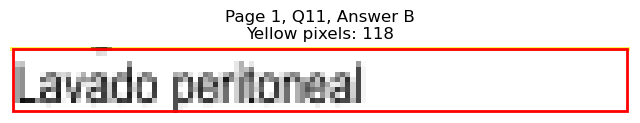

Page 1, Q11 - C: Detected box: x0=85.0, y0=735.8, x1=173.5, y1=747.9
Page 1, Q11, C: Yellow pixels: 0
Page 1, Q11, C: Total non-white pixels: 472
Page 1, Q11, C: Yellow percentage: 0.0%


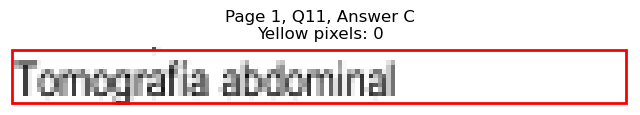

Page 1, Q11 - D: Detected box: x0=336.7, y0=711.7, x1=417.6, y1=723.8
Page 1, Q11, D: Yellow pixels: 0
Page 1, Q11, D: Total non-white pixels: 410
Page 1, Q11, D: Yellow percentage: 0.0%


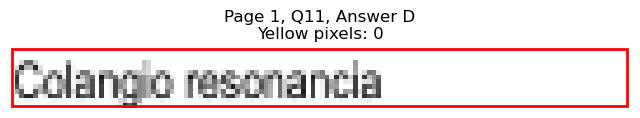

Page 1, Q11 - E: Detected box: x0=336.7, y0=723.7, x1=398.5, y1=735.8
Page 1, Q11, E: Yellow pixels: 0
Page 1, Q11, E: Total non-white pixels: 330
Page 1, Q11, E: Yellow percentage: 0.0%


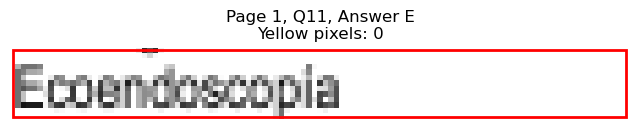


Page 1, Q11 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=97.0, y1=121.3
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 48
Page 2, Q1, A: Yellow percentage: 0.0%


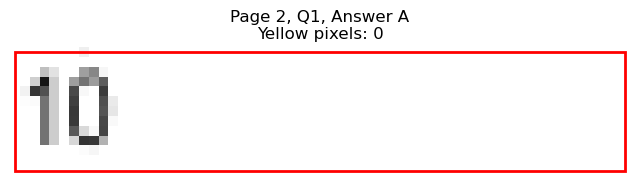

Page 2, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=97.0, y1=133.3
Page 2, Q1, B: Yellow pixels: 63
Page 2, Q1, B: Total non-white pixels: 107
Page 2, Q1, B: Yellow percentage: 58.9%


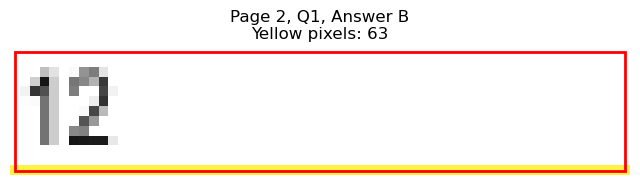

Page 2, Q1 - C: Detected box: x0=70.8, y0=133.2, x1=79.5, y1=145.3
Page 2, Q1, C: Yellow pixels: 665
Page 2, Q1, C: Total non-white pixels: 780
Page 2, Q1, C: Yellow percentage: 85.3%


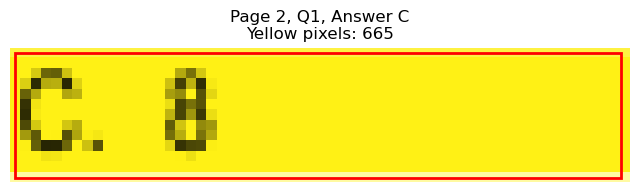

Page 2, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=348.7, y1=121.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 40
Page 2, Q1, D: Yellow percentage: 0.0%


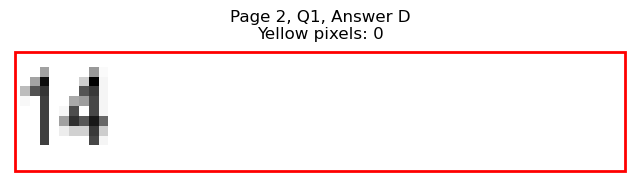

Page 2, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=348.7, y1=133.3
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 52
Page 2, Q1, E: Yellow percentage: 0.0%


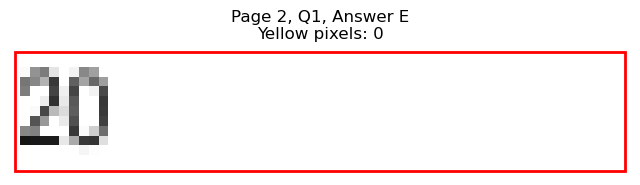


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=237.2, y1=181.5
Page 2, Q2, A: Yellow pixels: 190
Page 2, Q2, A: Total non-white pixels: 1010
Page 2, Q2, A: Yellow percentage: 18.8%


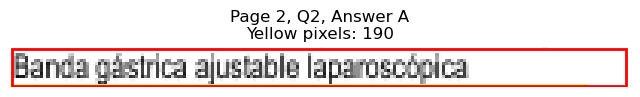

Page 2, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=235.4, y1=193.5
Page 2, Q2, B: Yellow pixels: 1865
Page 2, Q2, B: Total non-white pixels: 2483
Page 2, Q2, B: Yellow percentage: 75.1%


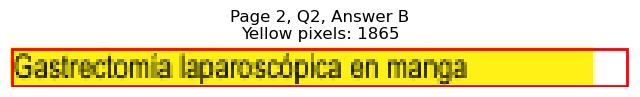

Page 2, Q2 - C: Detected box: x0=228.2, y0=193.4, x1=275.2, y1=205.5
Page 2, Q2, C: Yellow pixels: 46
Page 2, Q2, C: Total non-white pixels: 303
Page 2, Q2, C: Yellow percentage: 15.2%


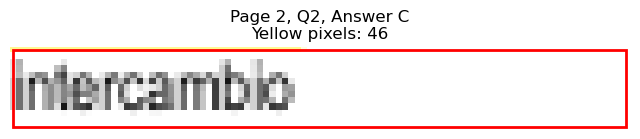

Page 2, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=469.8, y1=181.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 690
Page 2, Q2, D: Yellow percentage: 0.0%


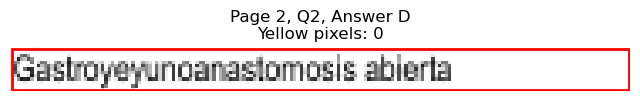

Page 2, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=510.6, y1=193.5
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 871
Page 2, Q2, E: Yellow percentage: 0.0%


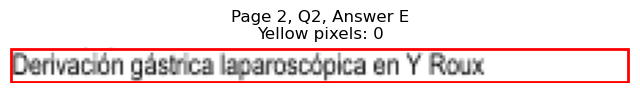


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=109.3, y1=253.8
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 146
Page 2, Q3, A: Yellow percentage: 0.0%


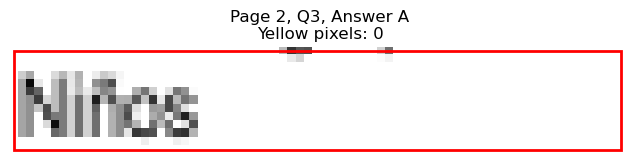

Page 2, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=116.1, y1=265.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 149
Page 2, Q3, B: Yellow percentage: 0.0%


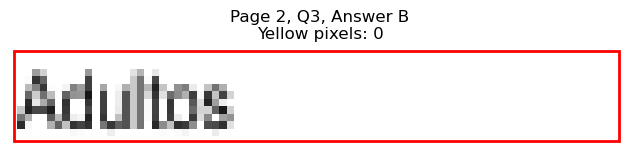

Page 2, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=138.1, y1=277.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 249
Page 2, Q3, C: Yellow percentage: 0.0%


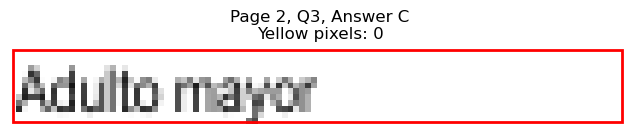

Page 2, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=391.9, y1=253.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 400
Page 2, Q3, D: Yellow percentage: 0.0%


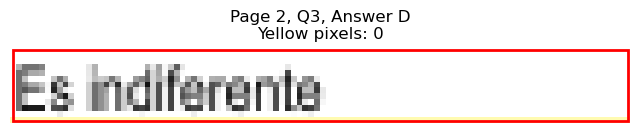

Page 2, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=386.5, y1=265.8
Page 2, Q3, E: Yellow pixels: 997
Page 2, Q3, E: Total non-white pixels: 1313
Page 2, Q3, E: Yellow percentage: 75.9%


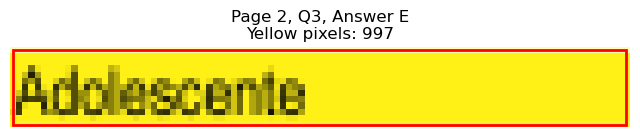


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=227.2, y1=350.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 709
Page 2, Q4, A: Yellow percentage: 0.0%


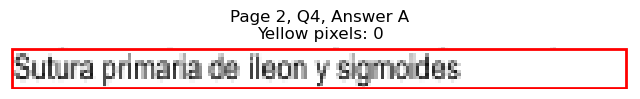

Page 2, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=256.4, y1=362.3
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 863
Page 2, Q4, B: Yellow percentage: 0.0%


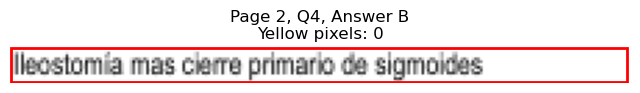

Page 2, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=230.9, y1=374.3
Page 2, Q4, C: Yellow pixels: 197
Page 2, Q4, C: Total non-white pixels: 944
Page 2, Q4, C: Yellow percentage: 20.9%


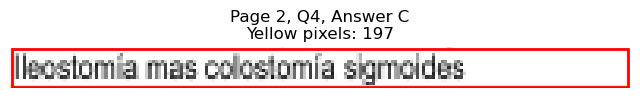

Page 2, Q4 - D: Detected box: x0=85.0, y0=374.2, x1=249.8, y1=386.3
Page 2, Q4, D: Yellow pixels: 1960
Page 2, Q4, D: Total non-white pixels: 2808
Page 2, Q4, D: Yellow percentage: 69.8%


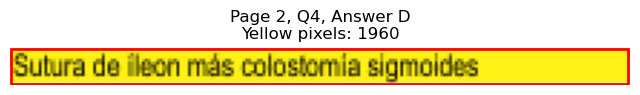

Page 2, Q4 - E: Detected box: x0=85.0, y0=386.3, x1=296.6, y1=398.4
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 1323
Page 2, Q4, E: Yellow percentage: 0.0%


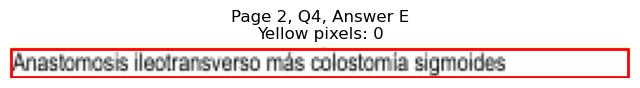


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=199.9, y1=446.5
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 575
Page 2, Q5, A: Yellow percentage: 0.0%


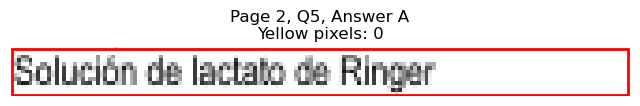

Page 2, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=152.1, y1=458.7
Page 2, Q5, B: Yellow pixels: 119
Page 2, Q5, B: Total non-white pixels: 454
Page 2, Q5, B: Yellow percentage: 26.2%


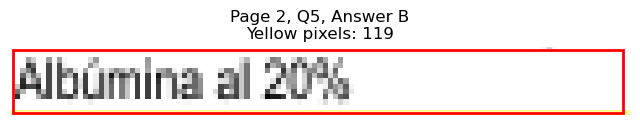

Page 2, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=132.4, y1=470.7
Page 2, Q5, C: Yellow pixels: 1081
Page 2, Q5, C: Total non-white pixels: 1287
Page 2, Q5, C: Yellow percentage: 84.0%


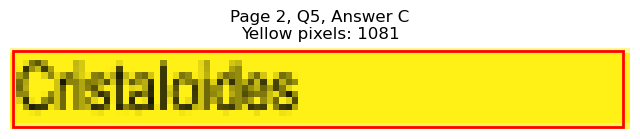

Page 2, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=393.7, y1=446.5
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 277
Page 2, Q5, D: Yellow percentage: 0.0%


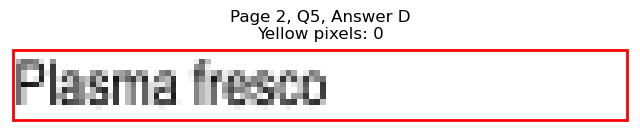

Page 2, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=416.6, y1=458.7
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 394
Page 2, Q5, E: Yellow percentage: 0.0%


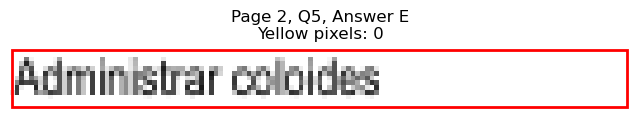


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=111.3, y1=506.8
Page 2, Q6, A: Yellow pixels: 829
Page 2, Q6, A: Total non-white pixels: 1014
Page 2, Q6, A: Yellow percentage: 81.8%


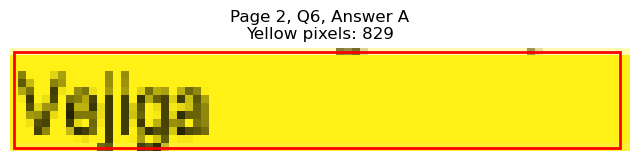

Page 2, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=140.1, y1=518.9
Page 2, Q6, B: Yellow pixels: 101
Page 2, Q6, B: Total non-white pixels: 406
Page 2, Q6, B: Yellow percentage: 24.9%


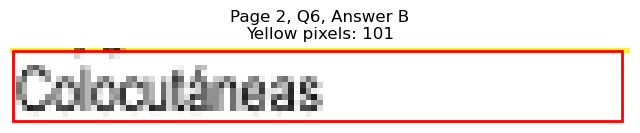

Page 2, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=108.4, y1=530.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 116
Page 2, Q6, C: Yellow percentage: 0.0%


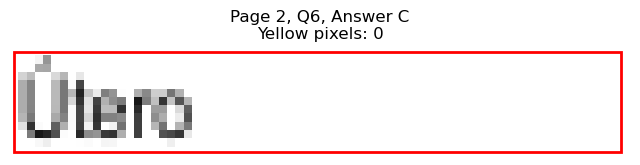

Page 2, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=372.1, y1=506.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 184
Page 2, Q6, D: Yellow percentage: 0.0%


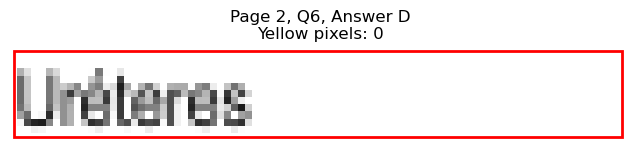

Page 2, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=390.8, y1=518.9
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 274
Page 2, Q6, E: Yellow percentage: 0.0%


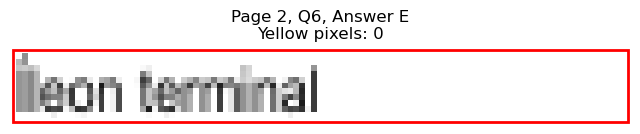


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=591.2, x1=162.5, y1=603.3
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 405
Page 2, Q7, A: Yellow percentage: 0.0%


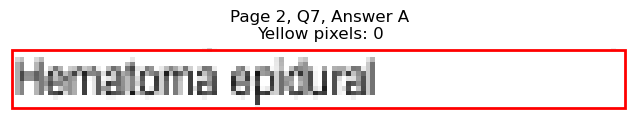

Page 2, Q7 - B: Detected box: x0=85.0, y0=603.2, x1=176.9, y1=615.3
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 478
Page 2, Q7, B: Yellow percentage: 0.0%


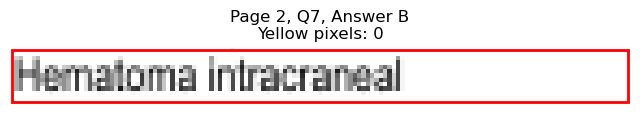

Page 2, Q7 - C: Detected box: x0=85.0, y0=615.2, x1=203.7, y1=627.3
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 589
Page 2, Q7, C: Yellow percentage: 0.0%


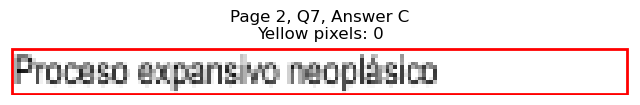

Page 2, Q7 - D: Detected box: x0=336.7, y0=591.2, x1=443.0, y1=603.3
Page 2, Q7, D: Yellow pixels: 1447
Page 2, Q7, D: Total non-white pixels: 2054
Page 2, Q7, D: Yellow percentage: 70.4%


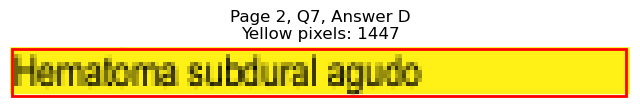

Page 2, Q7 - E: Detected box: x0=336.7, y0=603.2, x1=413.2, y1=615.3
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 504
Page 2, Q7, E: Yellow percentage: 0.0%


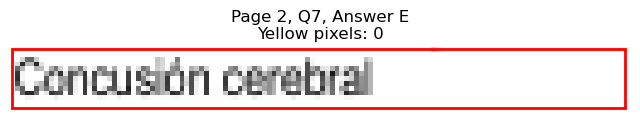


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=209.6, y1=663.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 586
Page 2, Q8, A: Yellow percentage: 0.0%


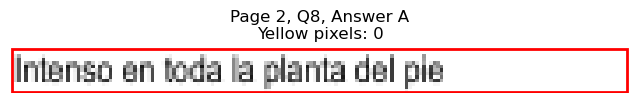

Page 2, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=237.2, y1=675.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 738
Page 2, Q8, B: Yellow percentage: 0.0%


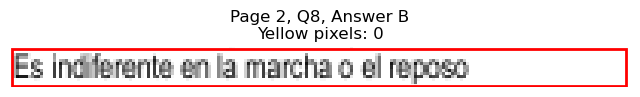

Page 2, Q8 - C: Detected box: x0=85.0, y0=675.4, x1=225.8, y1=687.5
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 654
Page 2, Q8, C: Yellow percentage: 0.0%


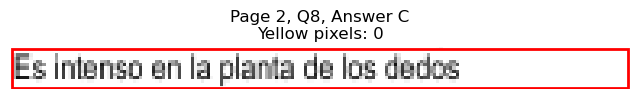

Page 2, Q8 - D: Detected box: x0=85.0, y0=687.5, x1=282.7, y1=699.7
Page 2, Q8, D: Yellow pixels: 249
Page 2, Q8, D: Total non-white pixels: 1210
Page 2, Q8, D: Yellow percentage: 20.6%


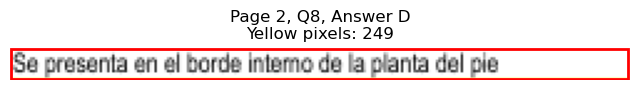

Page 2, Q8 - E: Detected box: x0=85.0, y0=699.5, x1=316.3, y1=711.7
Page 2, Q8, E: Yellow pixels: 2811
Page 2, Q8, E: Total non-white pixels: 3679
Page 2, Q8, E: Yellow percentage: 76.4%


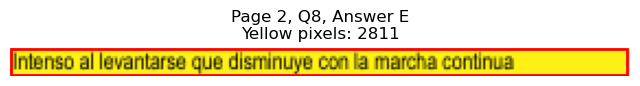


Page 2, Q8 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=171.6, y1=133.3
Page 3, Q1, A: Yellow pixels: 138
Page 3, Q1, A: Total non-white pixels: 592
Page 3, Q1, A: Yellow percentage: 23.3%


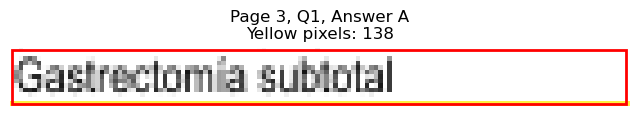

Page 3, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=163.5, y1=145.3
Page 3, Q1, B: Yellow pixels: 1219
Page 3, Q1, B: Total non-white pixels: 1690
Page 3, Q1, B: Yellow percentage: 72.1%


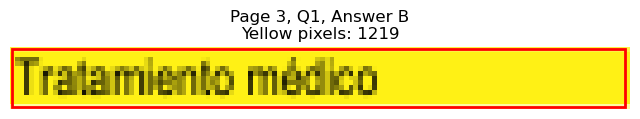

Page 3, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=133.9, y1=157.4
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 331
Page 3, Q1, C: Yellow percentage: 0.0%


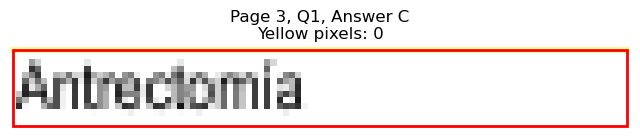

Page 3, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=409.4, y1=133.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 373
Page 3, Q1, D: Yellow percentage: 0.0%


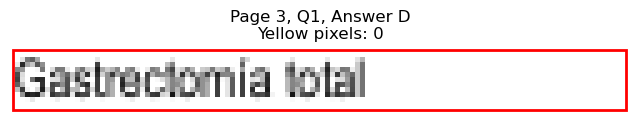

Page 3, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=489.8, y1=145.3
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 775
Page 3, Q1, E: Yellow percentage: 0.0%


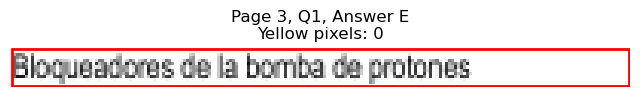


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=149.7, y1=193.5
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 316
Page 3, Q2, A: Yellow percentage: 0.0%


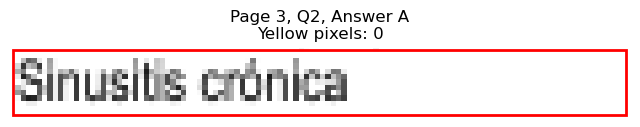

Page 3, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=152.9, y1=205.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 368
Page 3, Q2, B: Yellow percentage: 0.0%


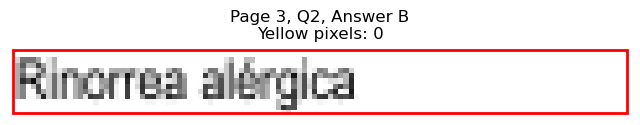

Page 3, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=151.1, y1=217.7
Page 3, Q2, C: Yellow pixels: 1235
Page 3, Q2, C: Total non-white pixels: 1534
Page 3, Q2, C: Yellow percentage: 80.5%


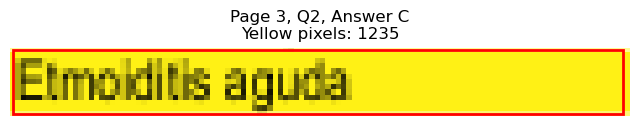

Page 3, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=414.2, y1=193.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 406
Page 3, Q2, D: Yellow percentage: 0.0%


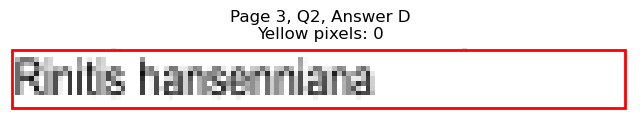

Page 3, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=403.3, y1=205.5
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 353
Page 3, Q2, E: Yellow percentage: 0.0%


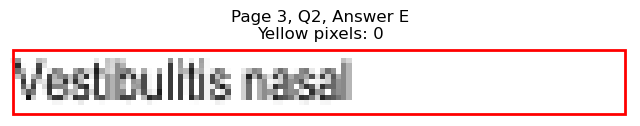


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=164.9, y1=253.8
Page 3, Q3, A: Yellow pixels: 1252
Page 3, Q3, A: Total non-white pixels: 1703
Page 3, Q3, A: Yellow percentage: 73.5%


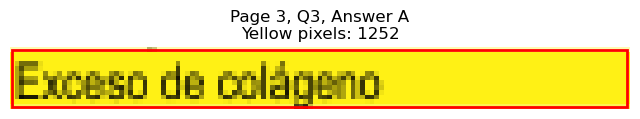

Page 3, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=185.5, y1=265.8
Page 3, Q3, B: Yellow pixels: 148
Page 3, Q3, B: Total non-white pixels: 645
Page 3, Q3, B: Yellow percentage: 22.9%


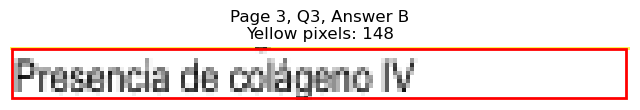

Page 3, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=187.0, y1=277.9
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 528
Page 3, Q3, C: Yellow percentage: 0.0%


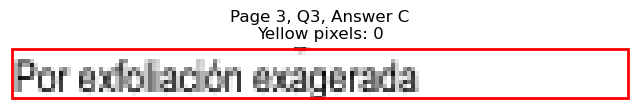

Page 3, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=429.1, y1=253.8
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 444
Page 3, Q3, D: Yellow percentage: 0.0%


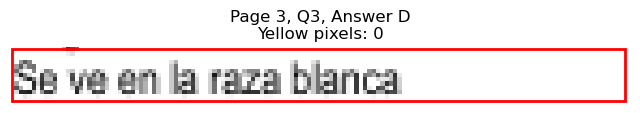

Page 3, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=440.1, y1=265.8
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 505
Page 3, Q3, E: Yellow percentage: 0.0%


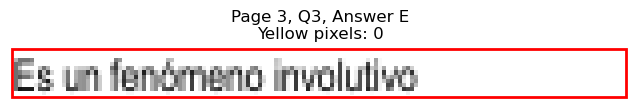


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=158.7, y1=338.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 400
Page 3, Q4, A: Yellow percentage: 0.0%


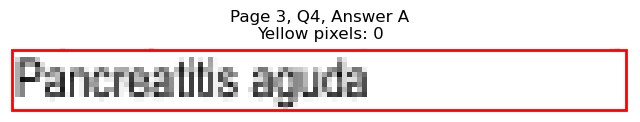

Page 3, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=138.1, y1=350.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 243
Page 3, Q4, B: Yellow percentage: 0.0%


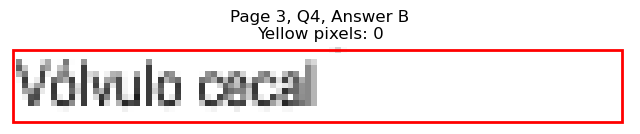

Page 3, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=119.4, y1=362.3
Page 3, Q4, C: Yellow pixels: 881
Page 3, Q4, C: Total non-white pixels: 1118
Page 3, Q4, C: Yellow percentage: 78.8%


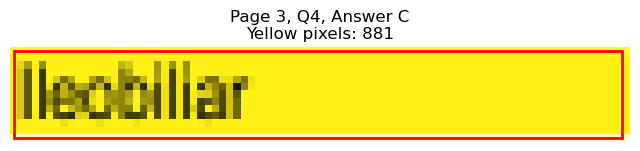

Page 3, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=467.4, y1=338.2
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 666
Page 3, Q4, D: Yellow percentage: 0.0%


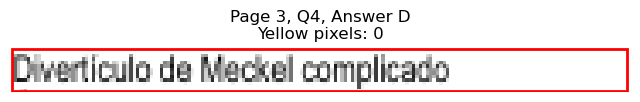

Page 3, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=440.1, y1=350.2
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 543
Page 3, Q4, E: Yellow percentage: 0.0%


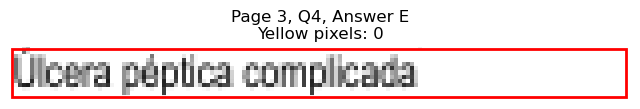


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=217.6, y1=410.4
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 647
Page 3, Q5, A: Yellow percentage: 0.0%


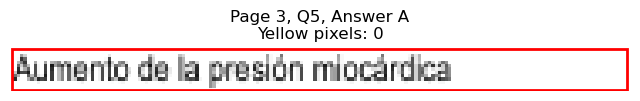

Page 3, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=164.4, y1=422.5
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 415
Page 3, Q5, B: Yellow percentage: 0.0%


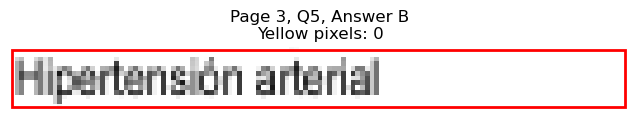

Page 3, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=234.3, y1=434.5
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 756
Page 3, Q5, C: Yellow percentage: 0.0%


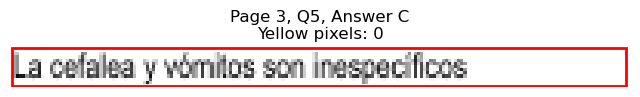

Page 3, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=445.4, y1=410.4
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 552
Page 3, Q5, D: Yellow percentage: 0.0%


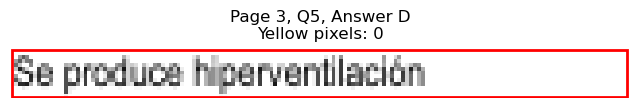

Page 3, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=432.9, y1=422.5
Page 3, Q5, E: Yellow pixels: 1529
Page 3, Q5, E: Total non-white pixels: 1911
Page 3, Q5, E: Yellow percentage: 80.0%


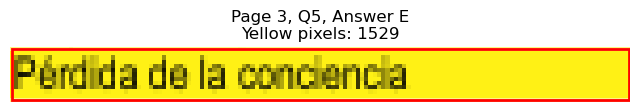


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=140.1, y1=470.7
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 284
Page 3, Q6, A: Yellow percentage: 0.0%


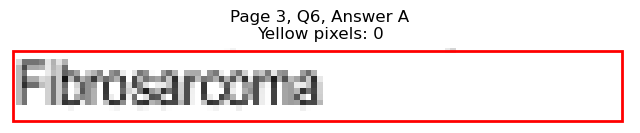

Page 3, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=152.1, y1=482.8
Page 3, Q6, B: Yellow pixels: 1140
Page 3, Q6, B: Total non-white pixels: 1547
Page 3, Q6, B: Yellow percentage: 73.7%


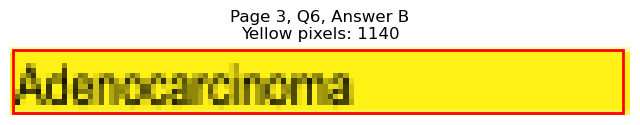

Page 3, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=153.5, y1=494.8
Page 3, Q6, C: Yellow pixels: 120
Page 3, Q6, C: Total non-white pixels: 443
Page 3, Q6, C: Yellow percentage: 27.1%


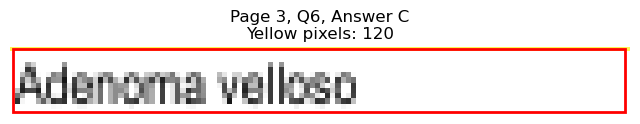

Page 3, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=373.5, y1=470.7
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 181
Page 3, Q6, D: Yellow percentage: 0.0%


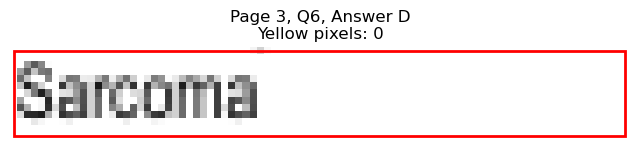

Page 3, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=405.6, y1=482.8
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 333
Page 3, Q6, E: Yellow percentage: 0.0%


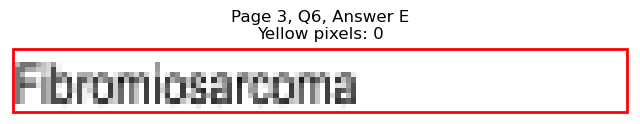


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=186.5, y1=567.0
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 550
Page 3, Q7, A: Yellow percentage: 0.0%


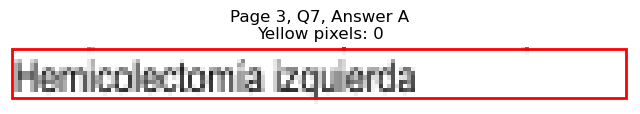

Page 3, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=163.0, y1=579.2
Page 3, Q7, B: Yellow pixels: 1220
Page 3, Q7, B: Total non-white pixels: 1677
Page 3, Q7, B: Yellow percentage: 72.7%


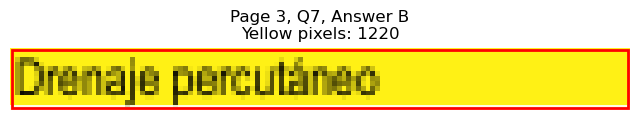

Page 3, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=173.5, y1=591.2
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 568
Page 3, Q7, C: Yellow percentage: 0.0%


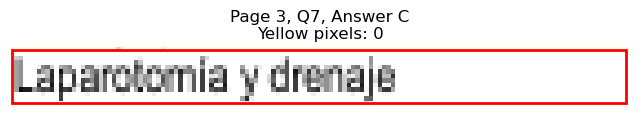

Page 3, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=422.8, y1=567.0
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 436
Page 3, Q7, D: Yellow percentage: 0.0%


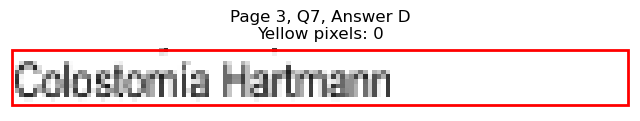

Page 3, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=429.1, y1=579.2
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 479
Page 3, Q7, E: Yellow percentage: 0.0%


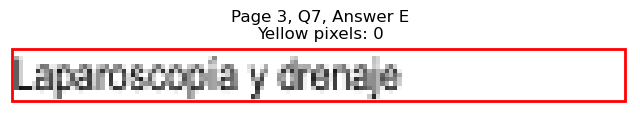


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=160.6, y1=627.3
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 394
Page 3, Q8, A: Yellow percentage: 0.0%


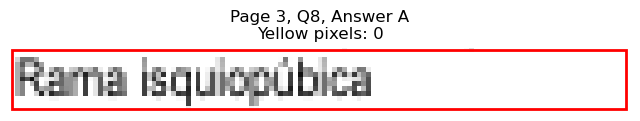

Page 3, Q8 - B: Detected box: x0=85.0, y0=627.3, x1=148.2, y1=639.4
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 326
Page 3, Q8, B: Yellow percentage: 0.0%


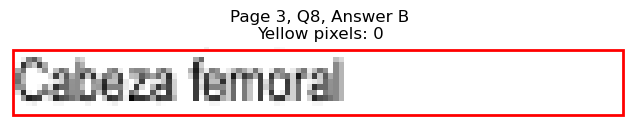

Page 3, Q8 - C: Detected box: x0=85.0, y0=639.3, x1=187.9, y1=651.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 519
Page 3, Q8, C: Yellow percentage: 0.0%


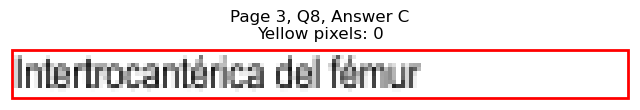

Page 3, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=361.5, y1=627.3
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 115
Page 3, Q8, D: Yellow percentage: 0.0%


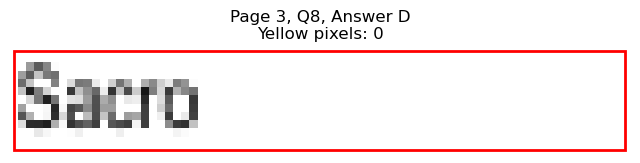

Page 3, Q8 - E: Detected box: x0=336.7, y0=627.3, x1=377.4, y1=639.4
Page 3, Q8, E: Yellow pixels: 942
Page 3, Q8, E: Total non-white pixels: 1196
Page 3, Q8, E: Yellow percentage: 78.8%


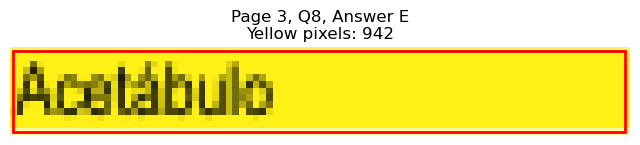


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=675.4, x1=131.5, y1=687.5
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 251
Page 3, Q9, A: Yellow percentage: 0.0%


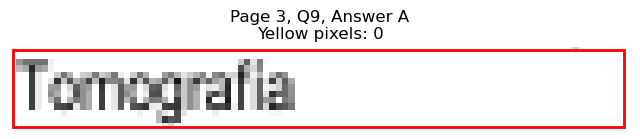

Page 3, Q9 - B: Detected box: x0=85.0, y0=687.5, x1=124.3, y1=699.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 206
Page 3, Q9, B: Yellow percentage: 0.0%


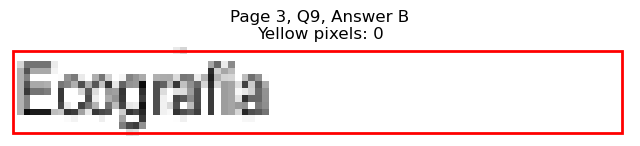

Page 3, Q9 - C: Detected box: x0=85.0, y0=699.5, x1=140.1, y1=711.7
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 283
Page 3, Q9, C: Yellow percentage: 0.0%


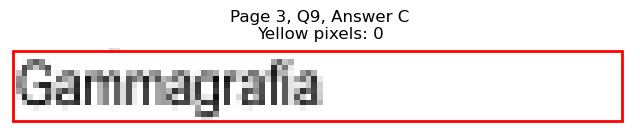

Page 3, Q9 - D: Detected box: x0=336.7, y0=675.4, x1=426.7, y1=687.5
Page 3, Q9, D: Yellow pixels: 1452
Page 3, Q9, D: Total non-white pixels: 1833
Page 3, Q9, D: Yellow percentage: 79.2%


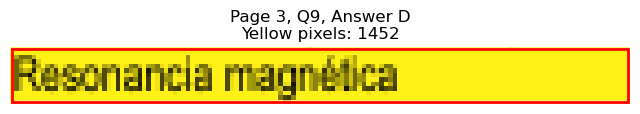

Page 3, Q9 - E: Detected box: x0=336.7, y0=687.5, x1=388.9, y1=699.7
Page 3, Q9, E: Yellow pixels: 103
Page 3, Q9, E: Total non-white pixels: 356
Page 3, Q9, E: Yellow percentage: 28.9%


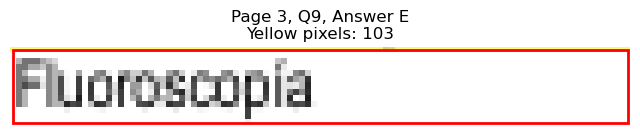


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=153.0, y1=747.9
Page 3, Q10, A: Yellow pixels: 1139
Page 3, Q10, A: Total non-white pixels: 1560
Page 3, Q10, A: Yellow percentage: 73.0%


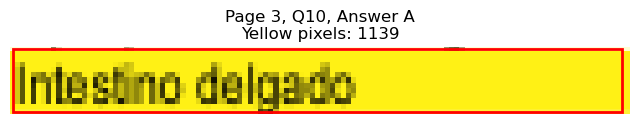

Page 3, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=109.8, y1=759.9
Page 3, Q10, B: Yellow pixels: 72
Page 3, Q10, B: Total non-white pixels: 210
Page 3, Q10, B: Yellow percentage: 34.3%


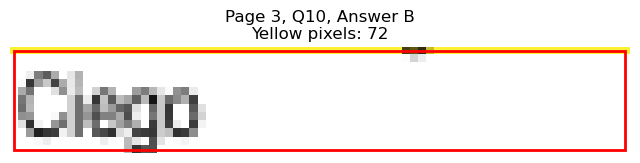

Page 3, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=143.4, y1=771.9
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 289
Page 3, Q10, C: Yellow percentage: 0.0%


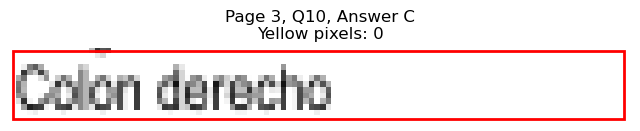

Page 3, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=404.1, y1=747.9
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 330
Page 3, Q10, D: Yellow percentage: 0.0%


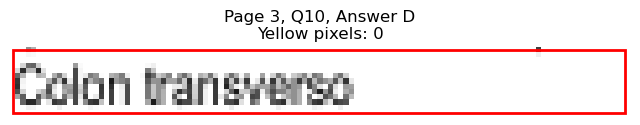

Page 3, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=399.0, y1=759.9
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 294
Page 3, Q10, E: Yellow percentage: 0.0%


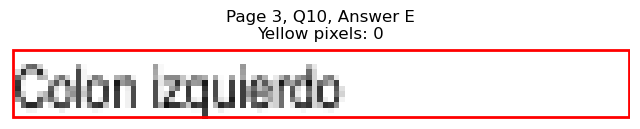


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=144.4, y1=109.2
Page 4, Q1, A: Yellow pixels: 1067
Page 4, Q1, A: Total non-white pixels: 1443
Page 4, Q1, A: Yellow percentage: 73.9%


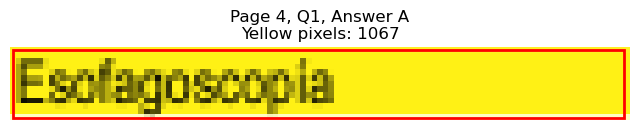

Page 4, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=146.8, y1=121.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 417
Page 4, Q1, B: Yellow percentage: 0.0%


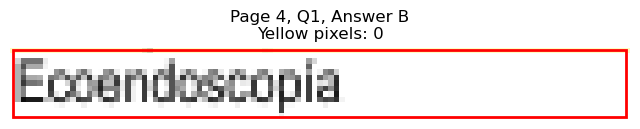

Page 4, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=124.2, y1=133.3
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 205
Page 4, Q1, C: Yellow percentage: 0.0%


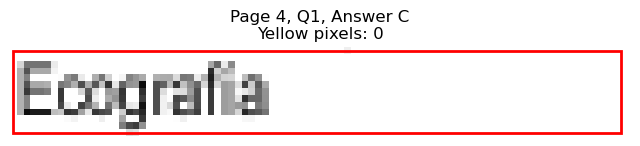

Page 4, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=425.2, y1=109.2
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 430
Page 4, Q1, D: Yellow percentage: 0.0%


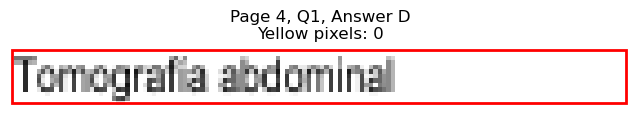

Page 4, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=426.7, y1=121.3
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 464
Page 4, Q1, E: Yellow percentage: 0.0%


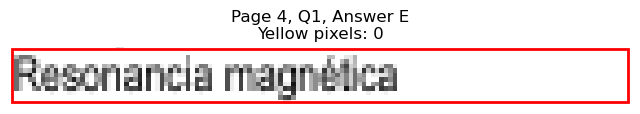


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=175.9, y1=169.4
Page 4, Q2, A: Yellow pixels: 1465
Page 4, Q2, A: Total non-white pixels: 1846
Page 4, Q2, A: Yellow percentage: 79.4%


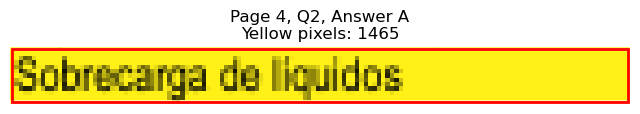

Page 4, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=136.2, y1=181.5
Page 4, Q2, B: Yellow pixels: 103
Page 4, Q2, B: Total non-white pixels: 363
Page 4, Q2, B: Yellow percentage: 28.4%


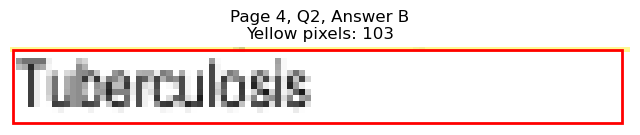

Page 4, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=157.2, y1=193.5
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 370
Page 4, Q2, C: Yellow percentage: 0.0%


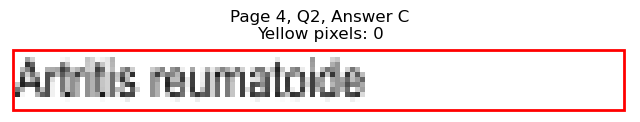

Page 4, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=378.3, y1=169.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 228
Page 4, Q2, D: Yellow percentage: 0.0%


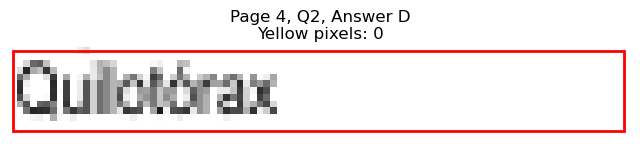

Page 4, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=414.2, y1=181.5
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 390
Page 4, Q2, E: Yellow percentage: 0.0%


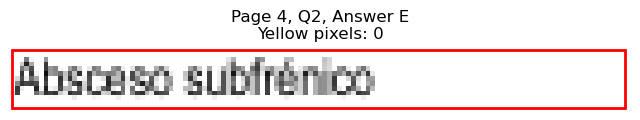


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=218.1, y1=229.7
Page 4, Q3, A: Yellow pixels: 1875
Page 4, Q3, A: Total non-white pixels: 2405
Page 4, Q3, A: Yellow percentage: 78.0%


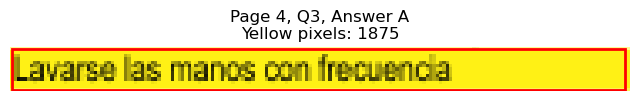

Page 4, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=197.9, y1=241.8
Page 4, Q3, B: Yellow pixels: 164
Page 4, Q3, B: Total non-white pixels: 732
Page 4, Q3, B: Yellow percentage: 22.4%


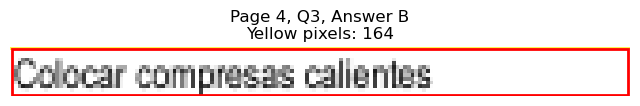

Page 4, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=233.3, y1=253.8
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 751
Page 4, Q3, C: Yellow percentage: 0.0%


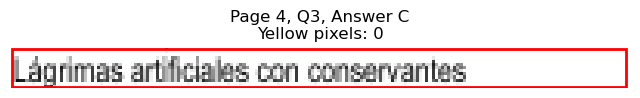

Page 4, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=432.4, y1=229.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 466
Page 4, Q3, D: Yellow percentage: 0.0%


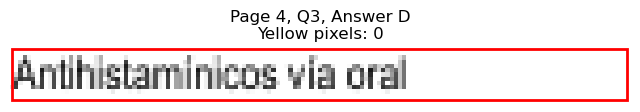

Page 4, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=477.5, y1=241.8
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 720
Page 4, Q3, E: Yellow percentage: 0.0%


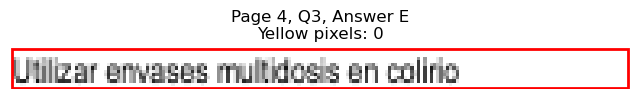


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=159.6, y1=314.0
Page 4, Q4, A: Yellow pixels: 126
Page 4, Q4, A: Total non-white pixels: 640
Page 4, Q4, A: Yellow percentage: 19.7%


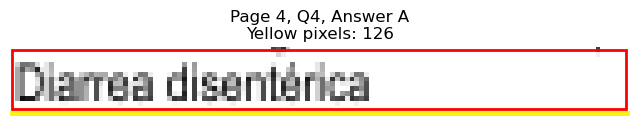

Page 4, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=172.2, y1=326.0
Page 4, Q4, B: Yellow pixels: 1288
Page 4, Q4, B: Total non-white pixels: 1946
Page 4, Q4, B: Yellow percentage: 66.2%


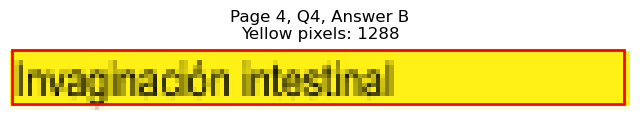

Page 4, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=162.5, y1=338.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 529
Page 4, Q4, C: Yellow percentage: 0.0%


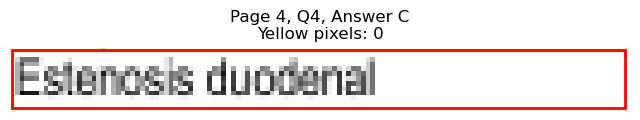

Page 4, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=420.0, y1=314.0
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 451
Page 4, Q4, D: Yellow percentage: 0.0%


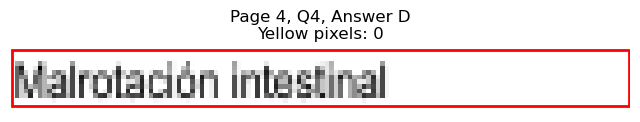

Page 4, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=407.1, y1=326.0
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 369
Page 4, Q4, E: Yellow percentage: 0.0%


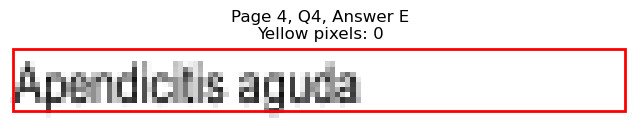


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=146.3, y1=386.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 303
Page 4, Q5, A: Yellow percentage: 0.0%


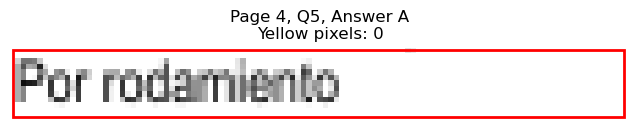

Page 4, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=116.5, y1=398.4
Page 4, Q5, B: Yellow pixels: 884
Page 4, Q5, B: Total non-white pixels: 1079
Page 4, Q5, B: Yellow percentage: 81.9%


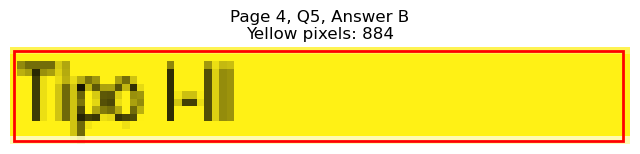

Page 4, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=127.6, y1=410.4
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 331
Page 4, Q5, C: Yellow percentage: 0.0%


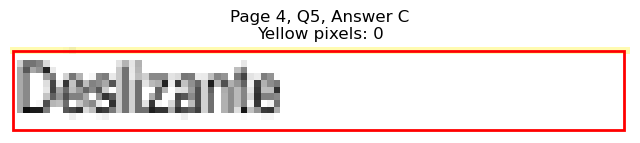

Page 4, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=360.7, y1=386.3
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 99
Page 4, Q5, D: Yellow percentage: 0.0%


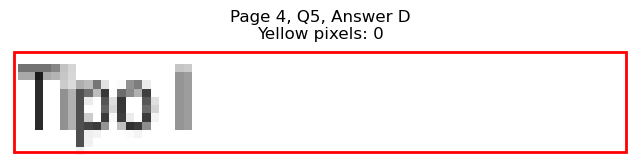

Page 4, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=394.2, y1=398.4
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 327
Page 4, Q5, E: Yellow percentage: 0.0%


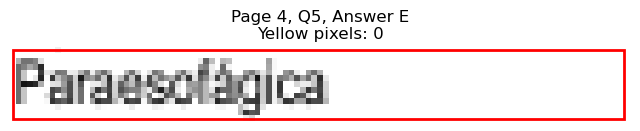


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=446.6, x1=156.7, y1=458.7
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 364
Page 4, Q6, A: Yellow percentage: 0.0%


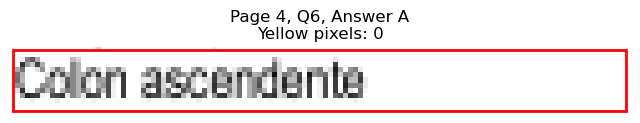

Page 4, Q6 - B: Detected box: x0=85.0, y0=458.6, x1=152.4, y1=470.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 335
Page 4, Q6, B: Yellow percentage: 0.0%


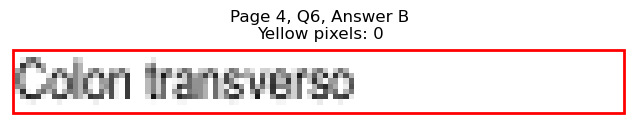

Page 4, Q6 - C: Detected box: x0=85.0, y0=470.7, x1=147.3, y1=482.8
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 317
Page 4, Q6, C: Yellow percentage: 0.0%


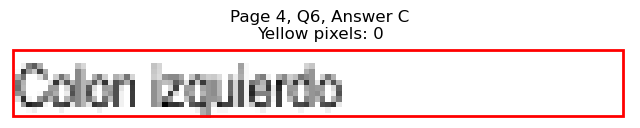

Page 4, Q6 - D: Detected box: x0=336.7, y0=446.6, x1=402.7, y1=458.7
Page 4, Q6, D: Yellow pixels: 117
Page 4, Q6, D: Total non-white pixels: 442
Page 4, Q6, D: Yellow percentage: 26.5%


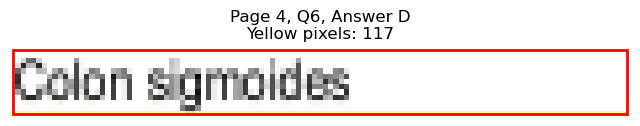

Page 4, Q6 - E: Detected box: x0=336.7, y0=458.6, x1=404.7, y1=470.7
Page 4, Q6, E: Yellow pixels: 1254
Page 4, Q6, E: Total non-white pixels: 1547
Page 4, Q6, E: Yellow percentage: 81.1%


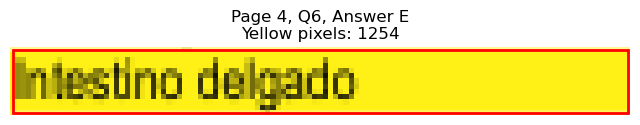


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=118.9, y1=518.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 262
Page 4, Q7, A: Yellow percentage: 0.0%


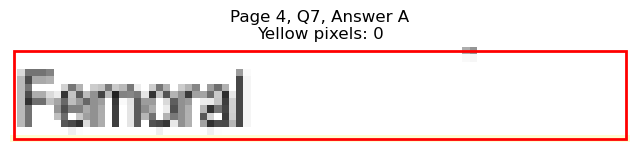

Page 4, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=131.4, y1=530.9
Page 4, Q7, B: Yellow pixels: 974
Page 4, Q7, B: Total non-white pixels: 1274
Page 4, Q7, B: Yellow percentage: 76.5%


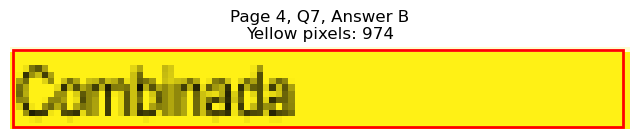

Page 4, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=114.6, y1=543.0
Page 4, Q7, C: Yellow pixels: 81
Page 4, Q7, C: Total non-white pixels: 237
Page 4, Q7, C: Yellow percentage: 34.2%


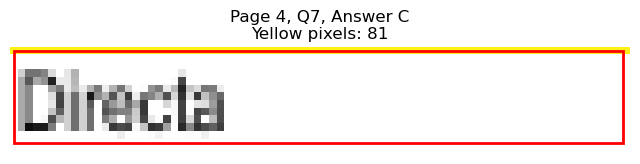

Page 4, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=372.1, y1=518.9
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 189
Page 4, Q7, D: Yellow percentage: 0.0%


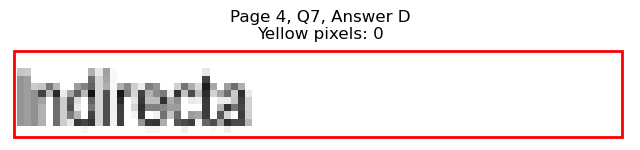

Page 4, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=374.0, y1=530.9
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 211
Page 4, Q7, E: Yellow percentage: 0.0%


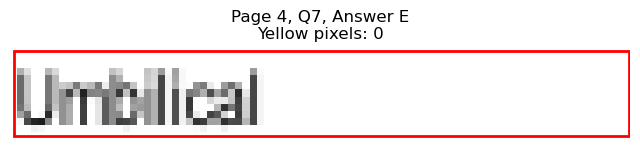


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=116.5, y1=579.2
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 170
Page 4, Q8, A: Yellow percentage: 0.0%


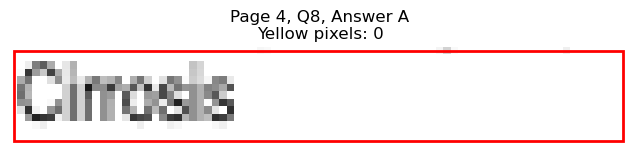

Page 4, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=153.9, y1=591.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 370
Page 4, Q8, B: Yellow percentage: 0.0%


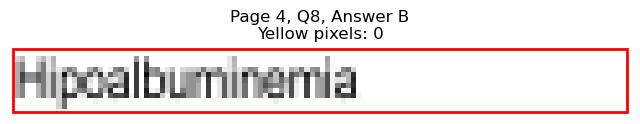

Page 4, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=136.2, y1=603.3
Page 4, Q8, C: Yellow pixels: 995
Page 4, Q8, C: Total non-white pixels: 1339
Page 4, Q8, C: Yellow percentage: 74.3%


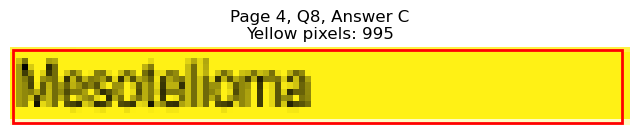

Page 4, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=408.4, y1=579.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 368
Page 4, Q8, D: Yellow percentage: 0.0%


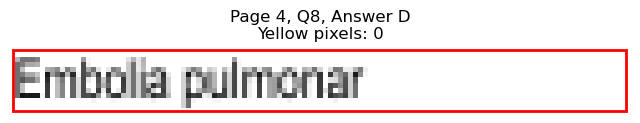

Page 4, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=411.8, y1=591.2
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 357
Page 4, Q8, E: Yellow percentage: 0.0%


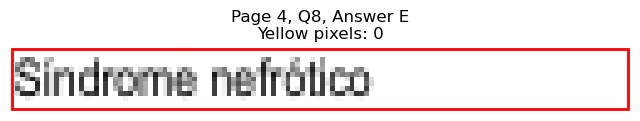


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=189.9, y1=639.4
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 537
Page 4, Q9, A: Yellow percentage: 0.0%


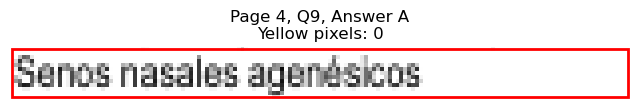

Page 4, Q9 - B: Detected box: x0=85.0, y0=639.3, x1=188.4, y1=651.4
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 544
Page 4, Q9, B: Yellow percentage: 0.0%


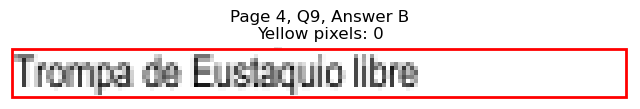

Page 4, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=146.8, y1=663.5
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 347
Page 4, Q9, C: Yellow percentage: 0.0%


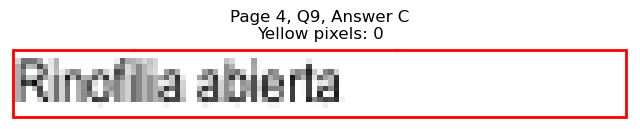

Page 4, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=409.9, y1=639.4
Page 4, Q9, D: Yellow pixels: 1185
Page 4, Q9, D: Total non-white pixels: 1612
Page 4, Q9, D: Yellow percentage: 73.5%


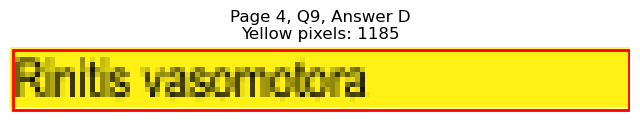

Page 4, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=445.4, y1=651.4
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 729
Page 4, Q9, E: Yellow percentage: 0.0%


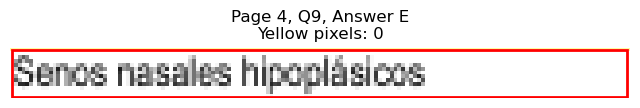


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=85.0, y0=699.5, x1=153.9, y1=711.7
Page 4, Q10, A: Yellow pixels: 1267
Page 4, Q10, A: Total non-white pixels: 1560
Page 4, Q10, A: Yellow percentage: 81.2%


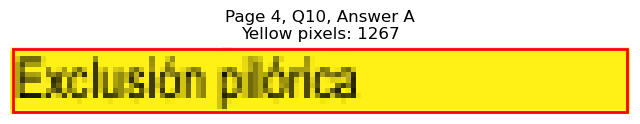

Page 4, Q10 - B: Detected box: x0=85.0, y0=711.7, x1=238.7, y1=723.8
Page 4, Q10, B: Yellow pixels: 190
Page 4, Q10, B: Total non-white pixels: 914
Page 4, Q10, B: Yellow percentage: 20.8%


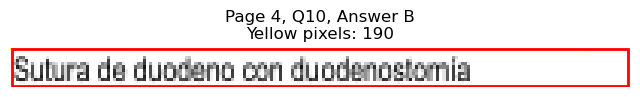

Page 4, Q10 - C: Detected box: x0=85.0, y0=723.7, x1=230.5, y1=735.8
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 706
Page 4, Q10, C: Yellow percentage: 0.0%


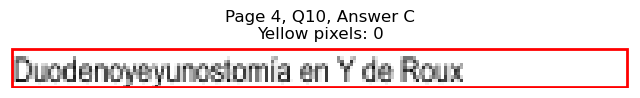

Page 4, Q10 - D: Detected box: x0=336.7, y0=699.5, x1=483.2, y1=711.7
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 731
Page 4, Q10, D: Yellow percentage: 0.0%


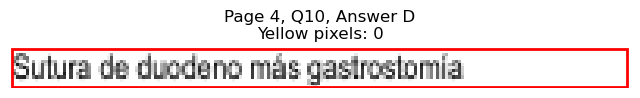

Page 4, Q10 - E: Detected box: x0=336.7, y0=711.7, x1=504.8, y1=723.8
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 882
Page 4, Q10, E: Yellow percentage: 0.0%


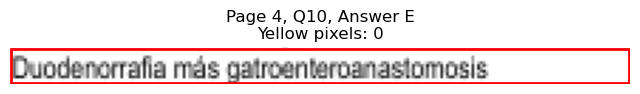


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=230.0, y1=133.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 728
Page 5, Q1, A: Yellow percentage: 0.0%


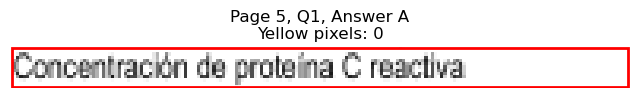

Page 5, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=164.4, y1=145.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 409
Page 5, Q1, B: Yellow percentage: 0.0%


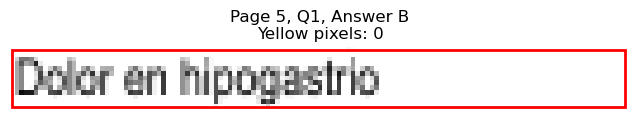

Page 5, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=176.4, y1=157.4
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 482
Page 5, Q1, C: Yellow percentage: 0.0%


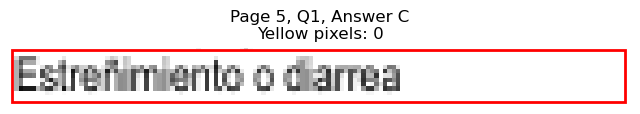

Page 5, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=421.4, y1=133.3
Page 5, Q1, D: Yellow pixels: 136
Page 5, Q1, D: Total non-white pixels: 590
Page 5, Q1, D: Yellow percentage: 23.1%


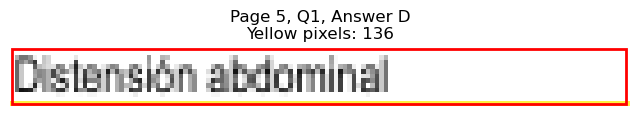

Page 5, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=422.5, y1=145.3
Page 5, Q1, E: Yellow pixels: 1137
Page 5, Q1, E: Total non-white pixels: 1781
Page 5, Q1, E: Yellow percentage: 63.8%


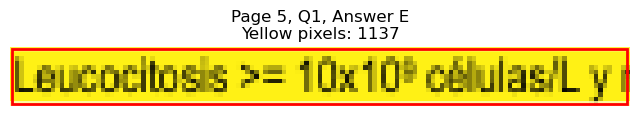


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=155.3, y1=205.5
Page 5, Q2, A: Yellow pixels: 1308
Page 5, Q2, A: Total non-white pixels: 1586
Page 5, Q2, A: Yellow percentage: 82.5%


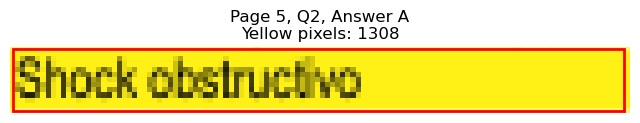

Page 5, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=129.5, y1=217.7
Page 5, Q2, B: Yellow pixels: 96
Page 5, Q2, B: Total non-white pixels: 328
Page 5, Q2, B: Yellow percentage: 29.3%


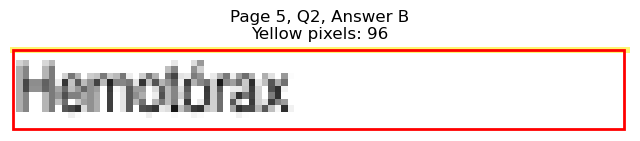

Page 5, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=167.3, y1=229.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 405
Page 5, Q2, C: Yellow percentage: 0.0%


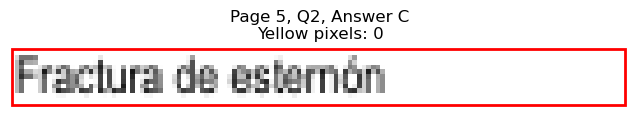

Page 5, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=435.3, y1=205.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 520
Page 5, Q2, D: Yellow percentage: 0.0%


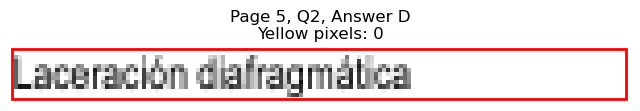

Page 5, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=412.9, y1=217.7
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 377
Page 5, Q2, E: Yellow percentage: 0.0%


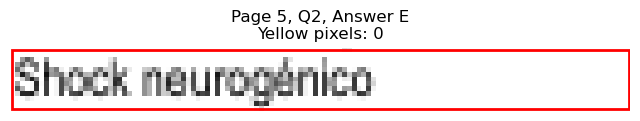


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=168.3, y1=277.9
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 423
Page 5, Q3, A: Yellow percentage: 0.0%


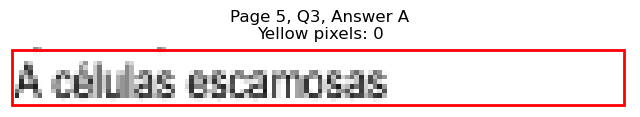

Page 5, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=135.7, y1=289.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 265
Page 5, Q3, B: Yellow percentage: 0.0%


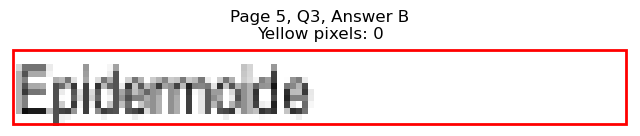

Page 5, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=152.1, y1=302.0
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 342
Page 5, Q3, C: Yellow percentage: 0.0%


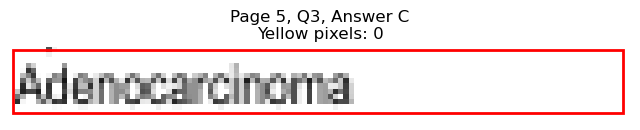

Page 5, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=379.3, y1=277.9
Page 5, Q3, D: Yellow pixels: 945
Page 5, Q3, D: Total non-white pixels: 1222
Page 5, Q3, D: Yellow percentage: 77.3%


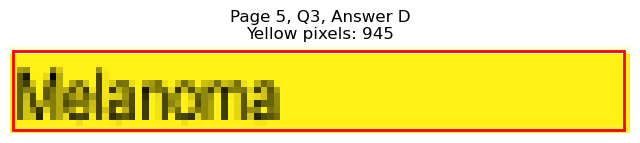

Page 5, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=376.9, y1=289.9
Page 5, Q3, E: Yellow pixels: 91
Page 5, Q3, E: Total non-white pixels: 316
Page 5, Q3, E: Yellow percentage: 28.8%


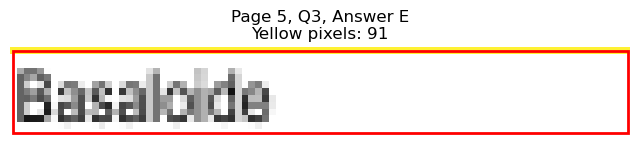


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=179.4, y1=338.2
Page 5, Q4, A: Yellow pixels: 1366
Page 5, Q4, A: Total non-white pixels: 1898
Page 5, Q4, A: Yellow percentage: 72.0%


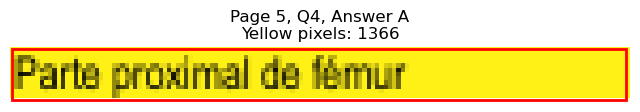

Page 5, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=113.7, y1=350.2
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 246
Page 5, Q4, B: Yellow percentage: 0.0%


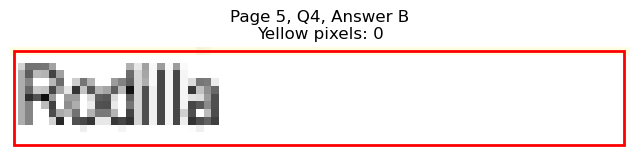

Page 5, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=140.1, y1=362.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 289
Page 5, Q4, C: Yellow percentage: 0.0%


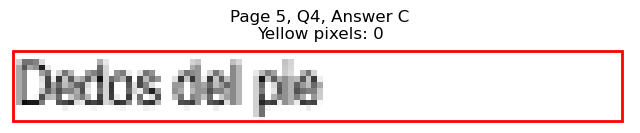

Page 5, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=432.0, y1=338.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 450
Page 5, Q4, D: Yellow percentage: 0.0%


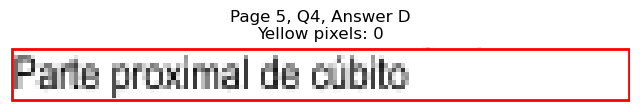

Page 5, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=364.4, y1=350.2
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 119
Page 5, Q4, E: Yellow percentage: 0.0%


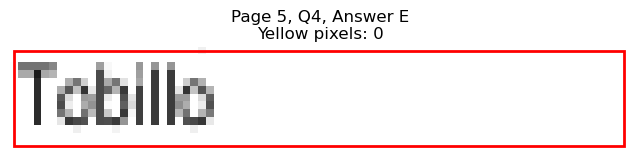


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=181.2, y1=398.4
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 456
Page 5, Q5, A: Yellow percentage: 0.0%


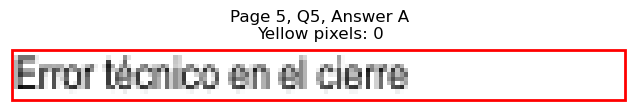

Page 5, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=162.5, y1=410.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 398
Page 5, Q5, B: Yellow percentage: 0.0%


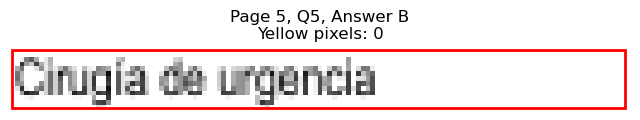

Page 5, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=209.9, y1=422.5
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 616
Page 5, Q5, C: Yellow percentage: 0.0%


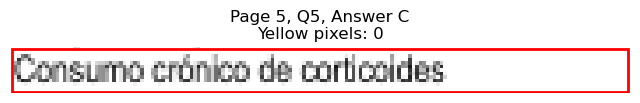

Page 5, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=420.9, y1=398.4
Page 5, Q5, D: Yellow pixels: 1286
Page 5, Q5, D: Total non-white pixels: 1755
Page 5, Q5, D: Yellow percentage: 73.3%


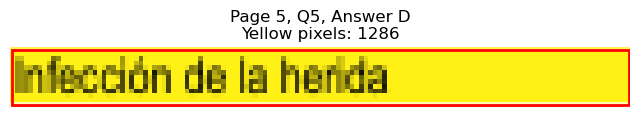

Page 5, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=385.5, y1=410.4
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 350
Page 5, Q5, E: Yellow percentage: 0.0%


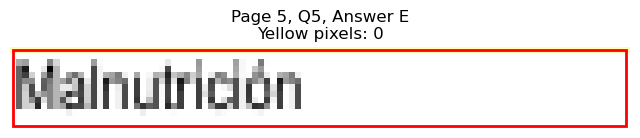


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=162.5, y1=482.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 396
Page 5, Q6, A: Yellow percentage: 0.0%


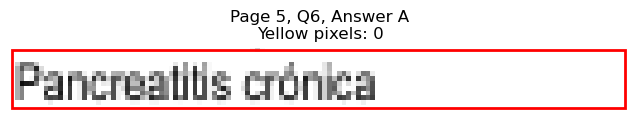

Page 5, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=159.6, y1=494.8
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 382
Page 5, Q6, B: Yellow percentage: 0.0%


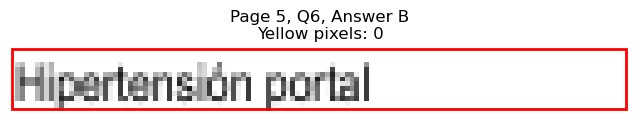

Page 5, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=201.8, y1=506.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 614
Page 5, Q6, C: Yellow percentage: 0.0%


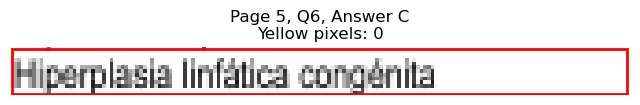

Page 5, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=452.0, y1=482.8
Page 5, Q6, D: Yellow pixels: 1501
Page 5, Q6, D: Total non-white pixels: 2171
Page 5, Q6, D: Yellow percentage: 69.1%


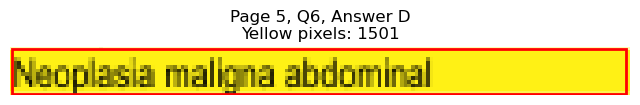

Page 5, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=413.7, y1=494.8
Page 5, Q6, E: Yellow pixels: 124
Page 5, Q6, E: Total non-white pixels: 529
Page 5, Q6, E: Yellow percentage: 23.4%


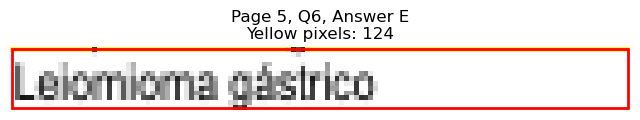


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=171.6, y1=543.0
Page 5, Q7, A: Yellow pixels: 1284
Page 5, Q7, A: Total non-white pixels: 1796
Page 5, Q7, A: Yellow percentage: 71.5%


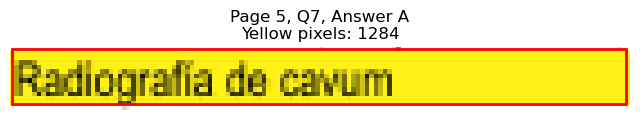

Page 5, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=184.6, y1=555.0
Page 5, Q7, B: Yellow pixels: 147
Page 5, Q7, B: Total non-white pixels: 646
Page 5, Q7, B: Yellow percentage: 22.8%


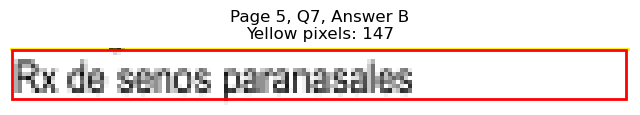

Page 5, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=133.8, y1=567.0
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 245
Page 5, Q7, C: Yellow percentage: 0.0%


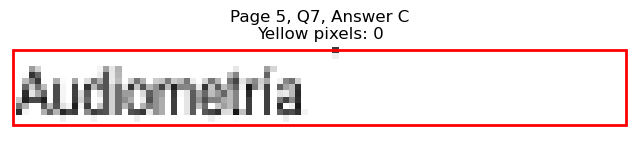

Page 5, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=393.2, y1=543.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 312
Page 5, Q7, D: Yellow percentage: 0.0%


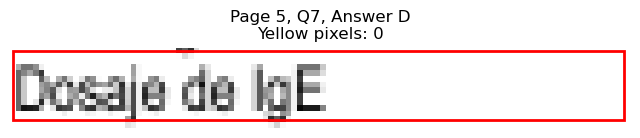

Page 5, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=377.4, y1=555.0
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 205
Page 5, Q7, E: Yellow percentage: 0.0%


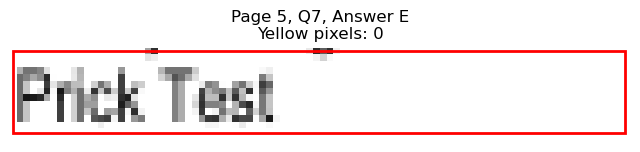


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=169.2, y1=603.3
Page 5, Q8, A: Yellow pixels: 136
Page 5, Q8, A: Total non-white pixels: 575
Page 5, Q8, A: Yellow percentage: 23.7%


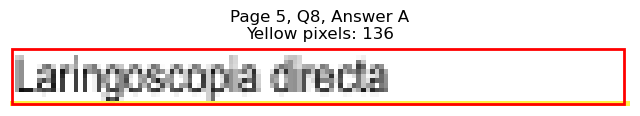

Page 5, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=132.4, y1=615.3
Page 5, Q8, B: Yellow pixels: 1008
Page 5, Q8, B: Total non-white pixels: 1287
Page 5, Q8, B: Yellow percentage: 78.3%


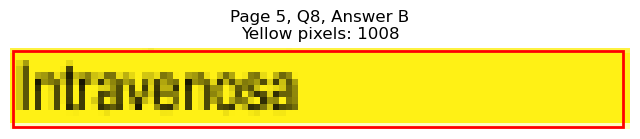

Page 5, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=154.0, y1=627.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 476
Page 5, Q8, C: Yellow percentage: 0.0%


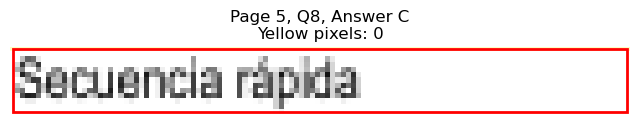

Page 5, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=378.3, y1=603.3
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 213
Page 5, Q8, D: Yellow percentage: 0.0%


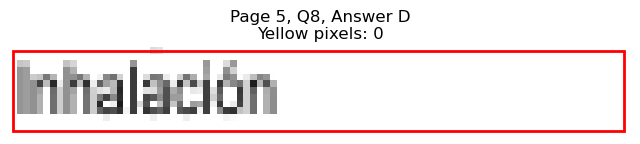

Page 5, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=383.1, y1=615.3
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 241
Page 5, Q8, E: Yellow percentage: 0.0%


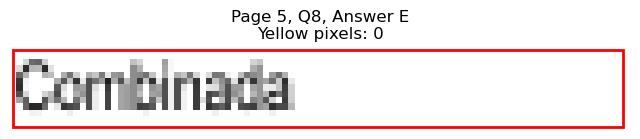


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=651.4, x1=120.9, y1=663.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 182
Page 5, Q9, A: Yellow percentage: 0.0%


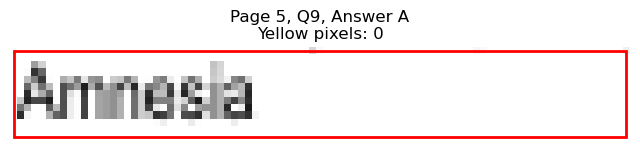

Page 5, Q9 - B: Detected box: x0=85.0, y0=663.4, x1=123.3, y1=675.5
Page 5, Q9, B: Yellow pixels: 90
Page 5, Q9, B: Total non-white pixels: 281
Page 5, Q9, B: Yellow percentage: 32.0%


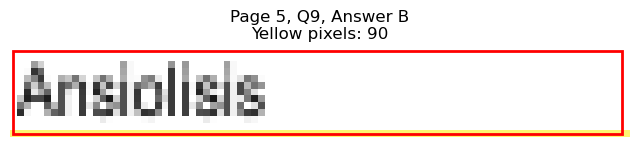

Page 5, Q9 - C: Detected box: x0=85.0, y0=675.4, x1=125.2, y1=687.5
Page 5, Q9, C: Yellow pixels: 1021
Page 5, Q9, C: Total non-white pixels: 1196
Page 5, Q9, C: Yellow percentage: 85.4%


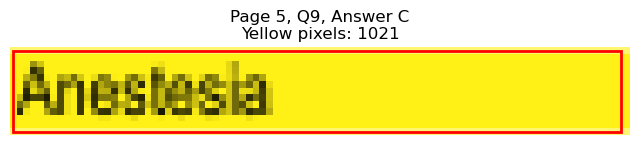

Page 5, Q9 - D: Detected box: x0=336.7, y0=651.4, x1=371.6, y1=663.5
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 197
Page 5, Q9, D: Yellow percentage: 0.0%


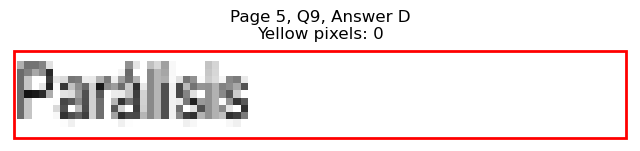

Page 5, Q9 - E: Detected box: x0=336.7, y0=663.4, x1=379.3, y1=675.5
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 234
Page 5, Q9, E: Yellow percentage: 0.0%


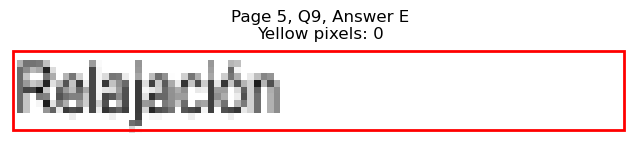


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=85.0, y0=747.8, x1=115.1, y1=759.9
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 158
Page 5, Q10, A: Yellow percentage: 0.0%


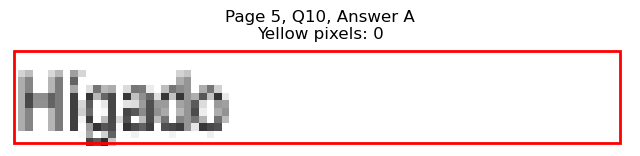

Page 5, Q10 - B: Detected box: x0=85.0, y0=759.8, x1=123.7, y1=771.9
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 202
Page 5, Q10, B: Yellow percentage: 0.0%


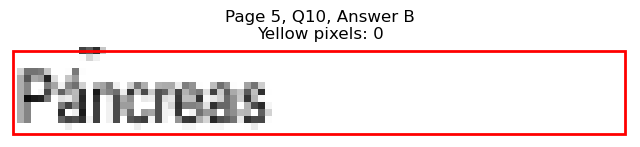

Page 5, Q10 - C: Detected box: x0=85.0, y0=771.9, x1=122.3, y1=784.0
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 181
Page 5, Q10, C: Yellow percentage: 0.0%


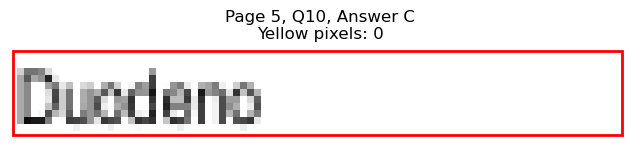

Page 5, Q10 - D: Detected box: x0=336.7, y0=747.8, x1=377.8, y1=759.9
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 322
Page 5, Q10, D: Yellow percentage: 0.0%


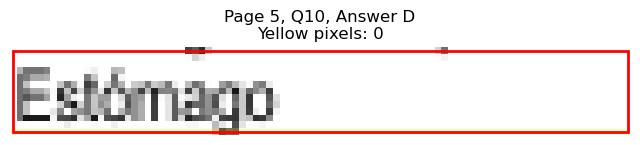

Page 5, Q10 - E: Detected box: x0=336.7, y0=759.8, x1=358.8, y1=771.9
Page 5, Q10, E: Yellow pixels: 790
Page 5, Q10, E: Total non-white pixels: 949
Page 5, Q10, E: Yellow percentage: 83.2%


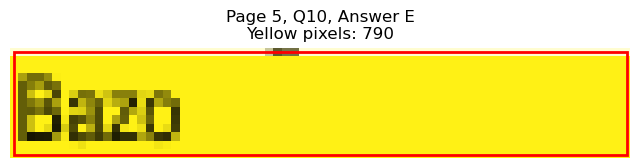


Page 5, Q10 - Selected Answer: E (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=133.8, y1=109.2
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 235
Page 6, Q1, A: Yellow percentage: 0.0%


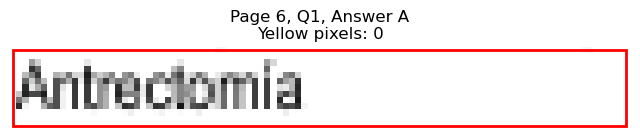

Page 6, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=197.5, y1=121.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 588
Page 6, Q1, B: Yellow percentage: 0.0%


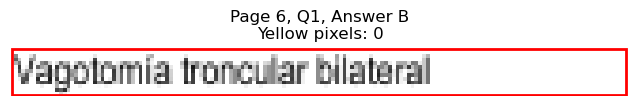

Page 6, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=171.6, y1=133.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 453
Page 6, Q1, C: Yellow percentage: 0.0%


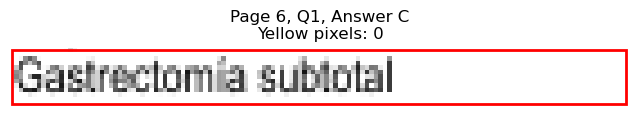

Page 6, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=416.6, y1=109.2
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 421
Page 6, Q1, D: Yellow percentage: 0.0%


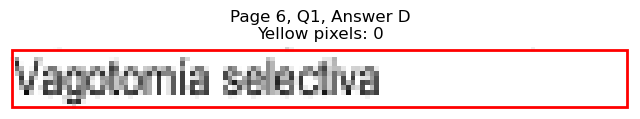

Page 6, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=409.4, y1=121.3
Page 6, Q1, E: Yellow pixels: 1194
Page 6, Q1, E: Total non-white pixels: 1612
Page 6, Q1, E: Yellow percentage: 74.1%


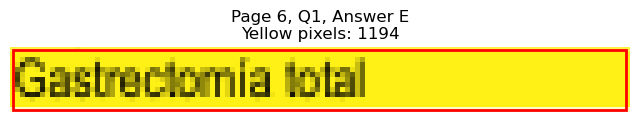


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=130.9, y1=169.4
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 236
Page 6, Q2, A: Yellow percentage: 0.0%


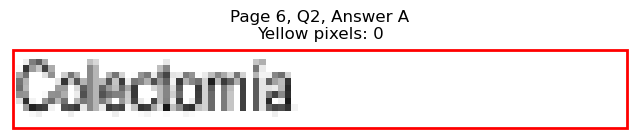

Page 6, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=140.5, y1=181.5
Page 6, Q2, B: Yellow pixels: 1155
Page 6, Q2, B: Total non-white pixels: 1391
Page 6, Q2, B: Yellow percentage: 83.0%


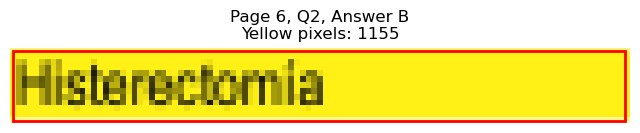

Page 6, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=139.6, y1=193.5
Page 6, Q2, C: Yellow pixels: 106
Page 6, Q2, C: Total non-white pixels: 393
Page 6, Q2, C: Yellow percentage: 27.0%


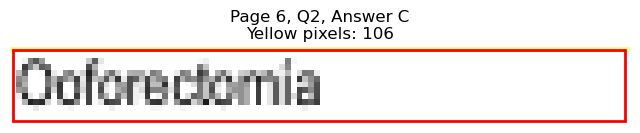

Page 6, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=425.7, y1=169.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 446
Page 6, Q2, D: Yellow percentage: 0.0%


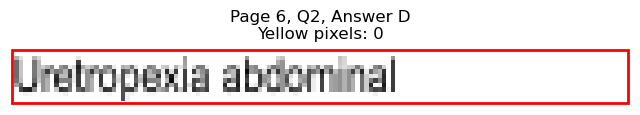

Page 6, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=423.8, y1=181.5
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 430
Page 6, Q2, E: Yellow percentage: 0.0%


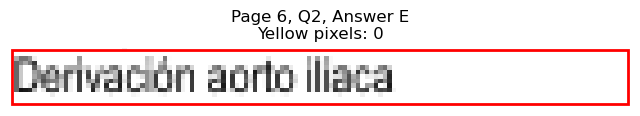


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=138.6, y1=229.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 274
Page 6, Q3, A: Yellow percentage: 0.0%


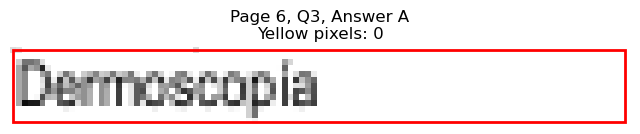

Page 6, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=141.5, y1=241.8
Page 6, Q3, B: Yellow pixels: 1066
Page 6, Q3, B: Total non-white pixels: 1404
Page 6, Q3, B: Yellow percentage: 75.9%


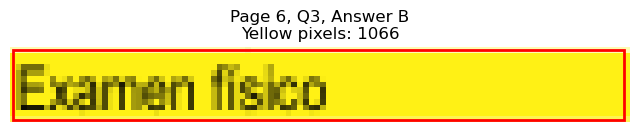

Page 6, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=115.6, y1=253.8
Page 6, Q3, C: Yellow pixels: 82
Page 6, Q3, C: Total non-white pixels: 239
Page 6, Q3, C: Yellow percentage: 34.3%


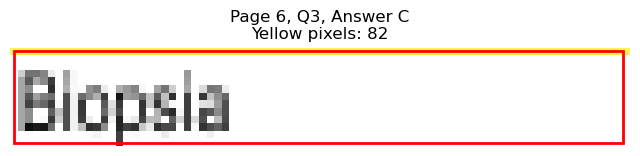

Page 6, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=378.8, y1=229.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 184
Page 6, Q3, D: Yellow percentage: 0.0%


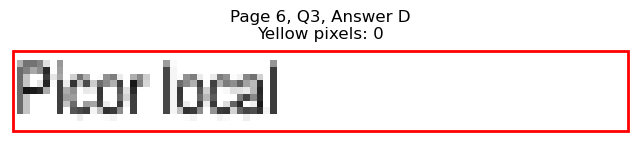

Page 6, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=376.4, y1=241.8
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 212
Page 6, Q3, E: Yellow percentage: 0.0%


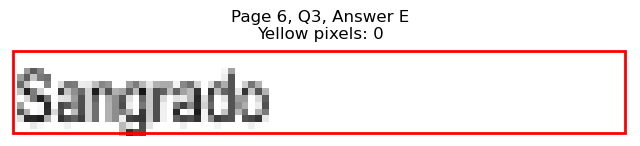


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=277.8, x1=130.9, y1=289.9
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 237
Page 6, Q4, A: Yellow percentage: 0.0%


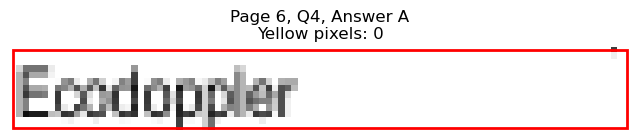

Page 6, Q4 - B: Detected box: x0=85.0, y0=289.9, x1=175.0, y1=302.0
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 487
Page 6, Q4, B: Yellow percentage: 0.0%


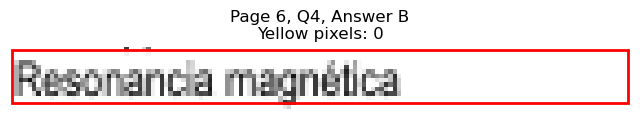

Page 6, Q4 - C: Detected box: x0=85.0, y0=301.9, x1=128.5, y1=314.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 246
Page 6, Q4, C: Yellow percentage: 0.0%


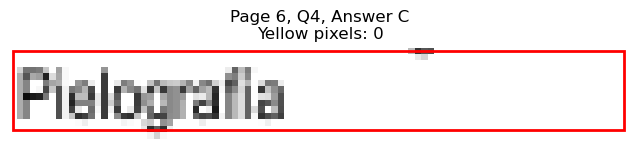

Page 6, Q4 - D: Detected box: x0=336.7, y0=277.8, x1=386.5, y1=289.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 257
Page 6, Q4, D: Yellow percentage: 0.0%


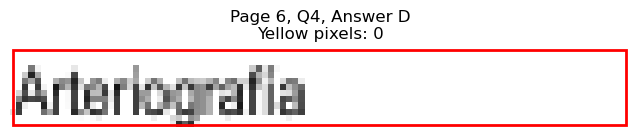

Page 6, Q4 - E: Detected box: x0=336.7, y0=289.9, x1=394.2, y1=302.0
Page 6, Q4, E: Yellow pixels: 1068
Page 6, Q4, E: Total non-white pixels: 1419
Page 6, Q4, E: Yellow percentage: 75.3%


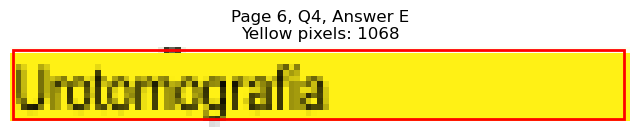


Page 6, Q4 - Selected Answer: E (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=338.1, x1=173.5, y1=350.2
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 474
Page 6, Q5, A: Yellow percentage: 0.0%


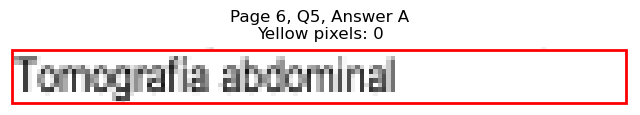

Page 6, Q5 - B: Detected box: x0=85.0, y0=350.2, x1=175.0, y1=362.3
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 479
Page 6, Q5, B: Yellow percentage: 0.0%


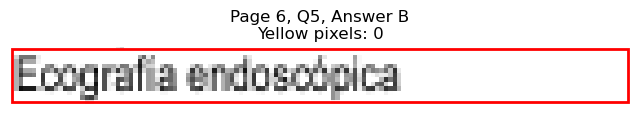

Page 6, Q5 - C: Detected box: x0=85.0, y0=362.2, x1=201.8, y1=374.3
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 640
Page 6, Q5, C: Yellow percentage: 0.0%


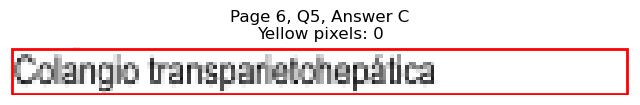

Page 6, Q5 - D: Detected box: x0=336.7, y0=338.1, x1=426.7, y1=350.2
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 462
Page 6, Q5, D: Yellow percentage: 0.0%


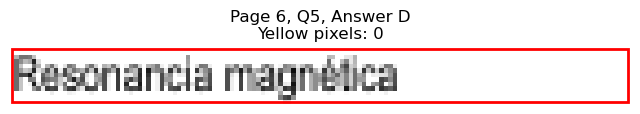

Page 6, Q5 - E: Detected box: x0=336.7, y0=350.2, x1=363.0, y1=362.3
Page 6, Q5, E: Yellow pixels: 803
Page 6, Q5, E: Total non-white pixels: 1001
Page 6, Q5, E: Yellow percentage: 80.2%


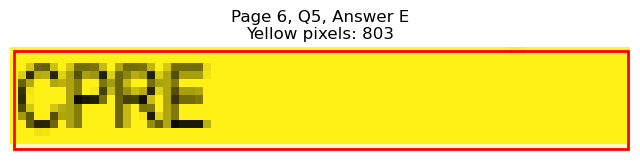


Page 6, Q5 - Selected Answer: E (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=410.4, x1=198.1, y1=422.5
Page 6, Q6, A: Yellow pixels: 165
Page 6, Q6, A: Total non-white pixels: 741
Page 6, Q6, A: Yellow percentage: 22.3%


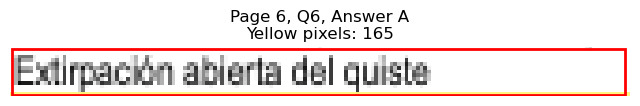

Page 6, Q6 - B: Detected box: x0=85.0, y0=422.4, x1=163.5, y1=434.5
Page 6, Q6, B: Yellow pixels: 1349
Page 6, Q6, B: Total non-white pixels: 1690
Page 6, Q6, B: Yellow percentage: 79.8%


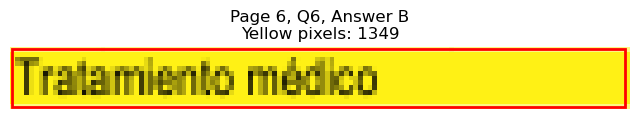

Page 6, Q6 - C: Detected box: x0=85.0, y0=434.4, x1=163.9, y1=446.5
Page 6, Q6, C: Yellow pixels: 130
Page 6, Q6, C: Total non-white pixels: 515
Page 6, Q6, C: Yellow percentage: 25.2%


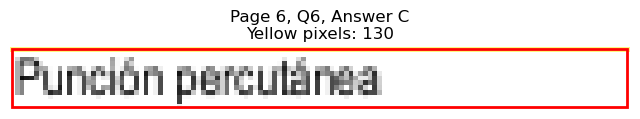

Page 6, Q6 - D: Detected box: x0=336.7, y0=410.4, x1=445.4, y1=422.5
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 576
Page 6, Q6, D: Yellow percentage: 0.0%


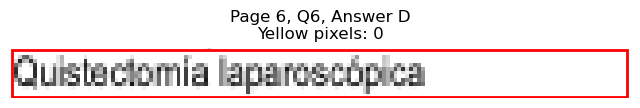

Page 6, Q6 - E: Detected box: x0=336.7, y0=422.4, x1=472.2, y1=434.5
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 653
Page 6, Q6, E: Yellow percentage: 0.0%


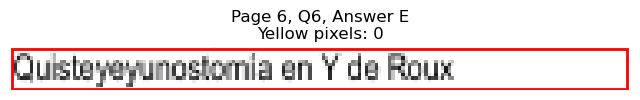


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=470.7, x1=186.5, y1=482.8
Page 6, Q7, A: Yellow pixels: 5
Page 6, Q7, A: Total non-white pixels: 640
Page 6, Q7, A: Yellow percentage: 0.8%


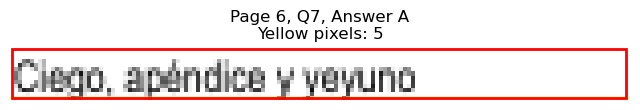

Page 6, Q7 - B: Detected box: x0=85.0, y0=482.7, x1=221.5, y1=494.8
Page 6, Q7, B: Yellow pixels: 1689
Page 6, Q7, B: Total non-white pixels: 2444
Page 6, Q7, B: Yellow percentage: 69.1%


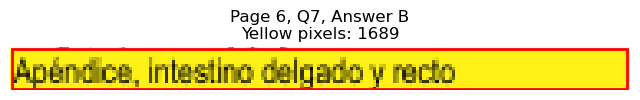

Page 6, Q7 - C: Detected box: x0=85.0, y0=494.7, x1=236.5, y1=506.8
Page 6, Q7, C: Yellow pixels: 182
Page 6, Q7, C: Total non-white pixels: 943
Page 6, Q7, C: Yellow percentage: 19.3%


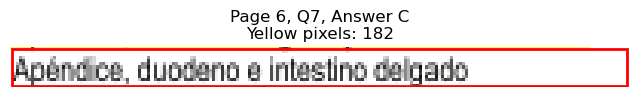

Page 6, Q7 - D: Detected box: x0=336.7, y0=470.7, x1=429.6, y1=482.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 455
Page 6, Q7, D: Yellow percentage: 0.0%


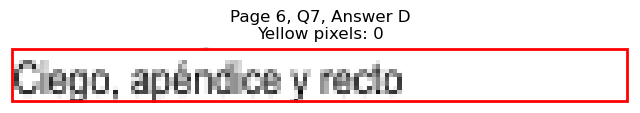

Page 6, Q7 - E: Detected box: x0=336.7, y0=482.7, x1=463.5, y1=494.8
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 636
Page 6, Q7, E: Yellow percentage: 0.0%


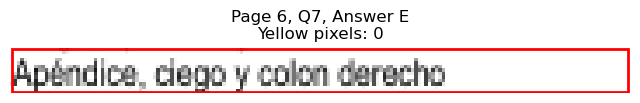


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=554.9, x1=142.0, y1=567.0
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 288
Page 6, Q8, A: Yellow percentage: 0.0%


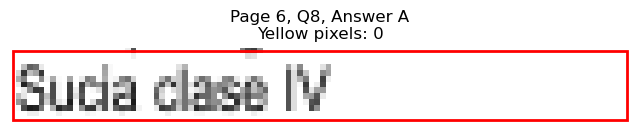

Page 6, Q8 - B: Detected box: x0=85.0, y0=567.1, x1=190.5, y1=579.2
Page 6, Q8, B: Yellow pixels: 157
Page 6, Q8, B: Total non-white pixels: 682
Page 6, Q8, B: Yellow percentage: 23.0%


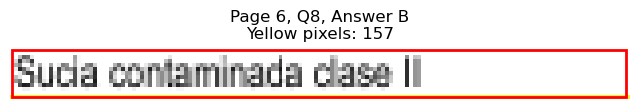

Page 6, Q8 - C: Detected box: x0=85.0, y0=579.1, x1=170.7, y1=591.2
Page 6, Q8, C: Yellow pixels: 1285
Page 6, Q8, C: Total non-white pixels: 1781
Page 6, Q8, C: Yellow percentage: 72.2%


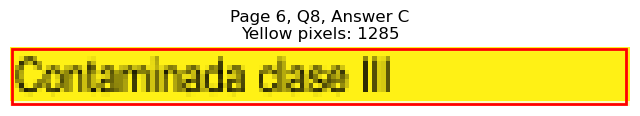

Page 6, Q8 - D: Detected box: x0=336.7, y0=554.9, x1=391.8, y1=567.0
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 255
Page 6, Q8, D: Yellow percentage: 0.0%


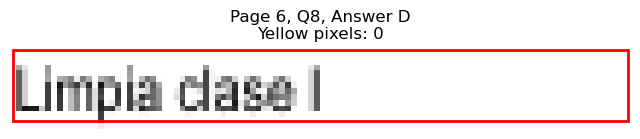

Page 6, Q8 - E: Detected box: x0=336.7, y0=567.1, x1=445.9, y1=579.2
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 511
Page 6, Q8, E: Yellow percentage: 0.0%


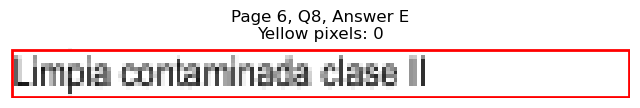


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=615.2, x1=168.7, y1=627.3
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 405
Page 6, Q9, A: Yellow percentage: 0.0%


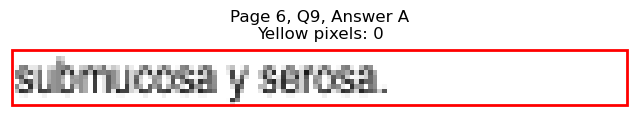

Page 6, Q9 - B: Detected box: x0=85.0, y0=627.3, x1=201.8, y1=639.4
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 549
Page 6, Q9, B: Yellow percentage: 0.0%


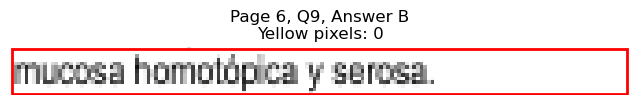

Page 6, Q9 - C: Detected box: x0=85.0, y0=639.3, x1=154.8, y1=651.4
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 317
Page 6, Q9, C: Yellow percentage: 0.0%


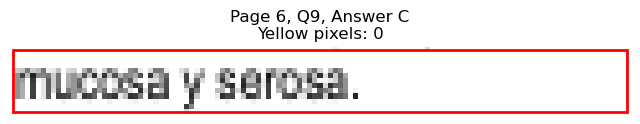

Page 6, Q9 - D: Detected box: x0=336.7, y0=615.2, x1=495.1, y1=627.3
Page 6, Q9, D: Yellow pixels: 1722
Page 6, Q9, D: Total non-white pixels: 2470
Page 6, Q9, D: Yellow percentage: 69.7%


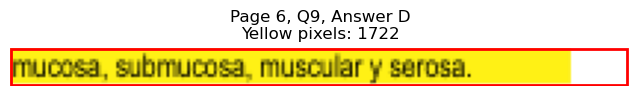

Page 6, Q9 - E: Detected box: x0=336.7, y0=627.3, x1=456.3, y1=639.4
Page 6, Q9, E: Yellow pixels: 1
Page 6, Q9, E: Total non-white pixels: 764
Page 6, Q9, E: Yellow percentage: 0.1%


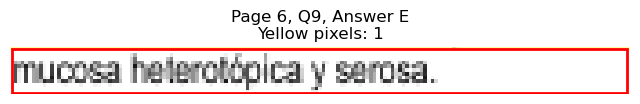


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=85.0, y0=699.5, x1=131.4, y1=711.7
Page 6, Q10, A: Yellow pixels: 1084
Page 6, Q10, A: Total non-white pixels: 1274
Page 6, Q10, A: Yellow percentage: 85.1%


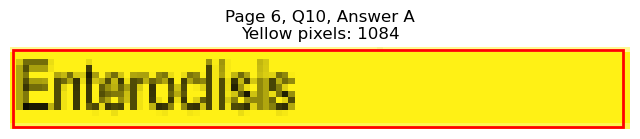

Page 6, Q10 - B: Detected box: x0=85.0, y0=711.7, x1=190.9, y1=723.8
Page 6, Q10, B: Yellow pixels: 157
Page 6, Q10, B: Total non-white pixels: 670
Page 6, Q10, B: Yellow percentage: 23.4%


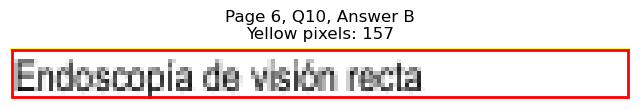

Page 6, Q10 - C: Detected box: x0=85.0, y0=723.7, x1=190.4, y1=735.8
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 539
Page 6, Q10, C: Yellow percentage: 0.0%


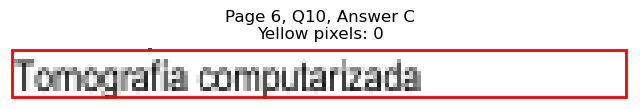

Page 6, Q10 - D: Detected box: x0=336.7, y0=338.1, x1=426.7, y1=350.2
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 462
Page 6, Q10, D: Yellow percentage: 0.0%


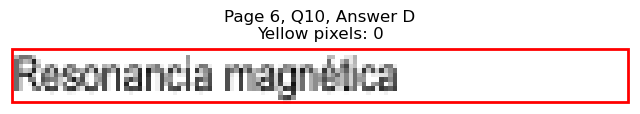

Page 6, Q10 - E: Detected box: x0=336.7, y0=711.7, x1=373.7, y1=723.8
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 212
Page 6, Q10, E: Yellow percentage: 0.0%


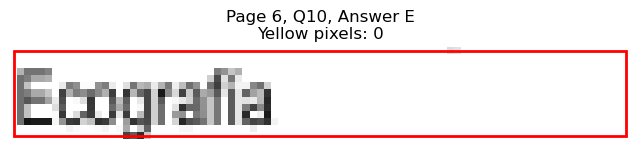


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=116.5, y1=109.2
Page 7, Q1, A: Yellow pixels: 883
Page 7, Q1, A: Total non-white pixels: 1079
Page 7, Q1, A: Yellow percentage: 81.8%


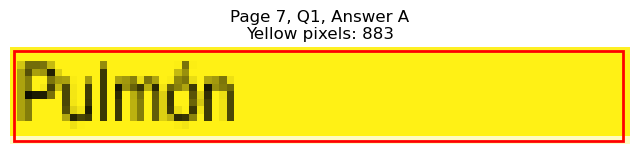

Page 7, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=119.4, y1=121.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 272
Page 7, Q1, B: Yellow percentage: 0.0%


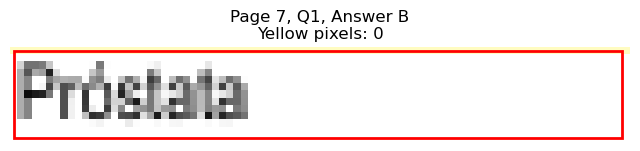

Page 7, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=126.1, y1=133.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 224
Page 7, Q1, C: Yellow percentage: 0.0%


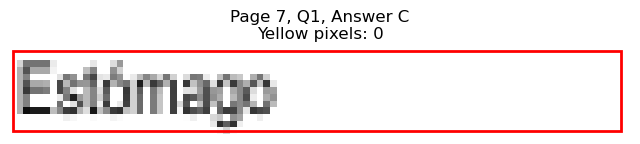

Page 7, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=380.7, y1=109.2
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 210
Page 7, Q1, D: Yellow percentage: 0.0%


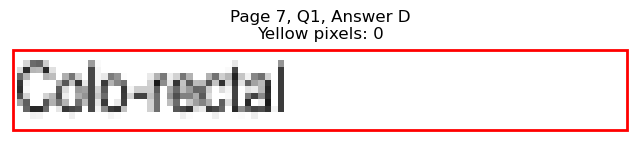

Page 7, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=366.8, y1=121.3
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 170
Page 7, Q1, E: Yellow percentage: 0.0%


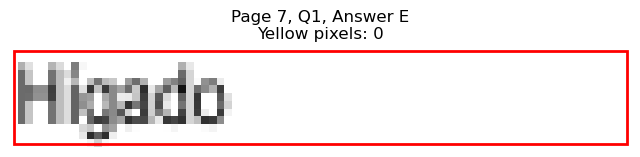


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=164.9, y1=169.4
Page 7, Q2, A: Yellow pixels: 1374
Page 7, Q2, A: Total non-white pixels: 1703
Page 7, Q2, A: Yellow percentage: 80.7%


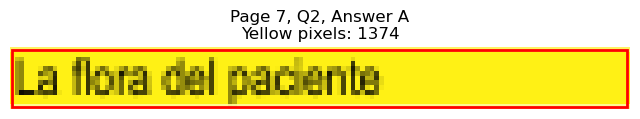

Page 7, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=222.4, y1=181.5
Page 7, Q2, B: Yellow pixels: 189
Page 7, Q2, B: Total non-white pixels: 923
Page 7, Q2, B: Yellow percentage: 20.5%


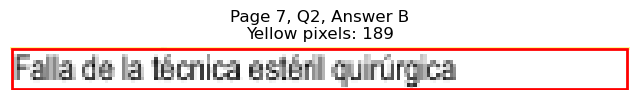

Page 7, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=175.0, y1=193.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 445
Page 7, Q2, C: Yellow percentage: 0.0%


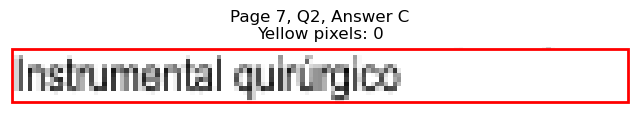

Page 7, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=420.4, y1=169.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 438
Page 7, Q2, D: Yellow percentage: 0.0%


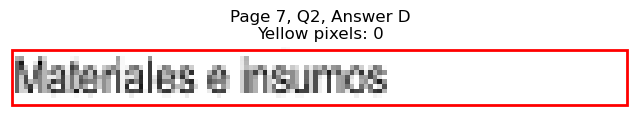

Page 7, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=416.1, y1=181.5
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 386
Page 7, Q2, E: Yellow percentage: 0.0%


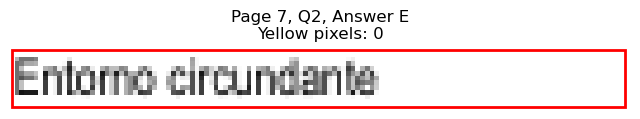


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=157.7, y1=241.8
Page 7, Q3, A: Yellow pixels: 1180
Page 7, Q3, A: Total non-white pixels: 1612
Page 7, Q3, A: Yellow percentage: 73.2%


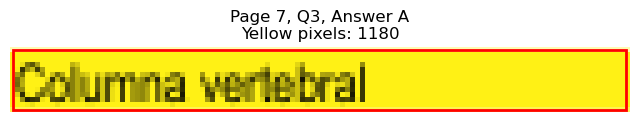

Page 7, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=106.1, y1=253.8
Page 7, Q3, B: Yellow pixels: 73
Page 7, Q3, B: Total non-white pixels: 186
Page 7, Q3, B: Yellow percentage: 39.2%


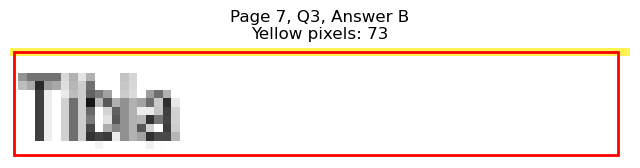

Page 7, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=115.1, y1=265.8
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 146
Page 7, Q3, C: Yellow percentage: 0.0%


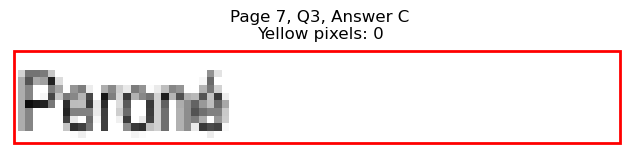

Page 7, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=363.9, y1=241.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 135
Page 7, Q3, D: Yellow percentage: 0.0%


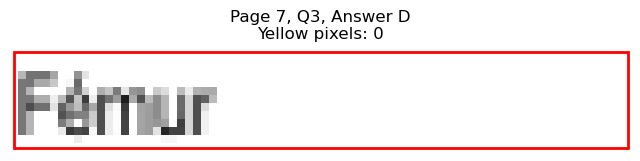

Page 7, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=367.3, y1=253.8
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 154
Page 7, Q3, E: Yellow percentage: 0.0%


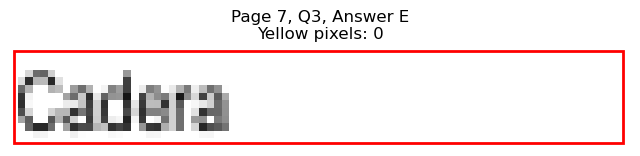


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=313.9, x1=109.8, y1=326.0
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 137
Page 7, Q4, A: Yellow percentage: 0.0%


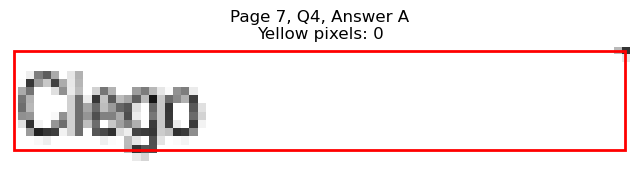

Page 7, Q4 - B: Detected box: x0=85.0, y0=326.1, x1=126.1, y1=338.2
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 226
Page 7, Q4, B: Yellow percentage: 0.0%


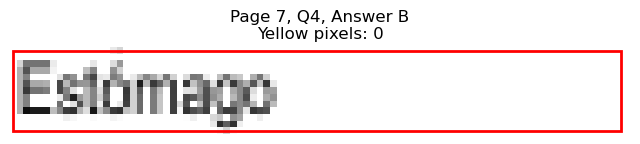

Page 7, Q4 - C: Detected box: x0=85.0, y0=338.1, x1=153.0, y1=350.2
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 377
Page 7, Q4, C: Yellow percentage: 0.0%


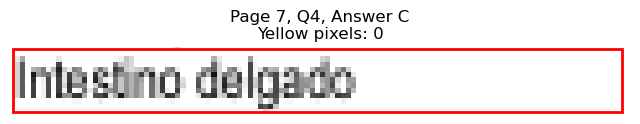

Page 7, Q4 - D: Detected box: x0=336.7, y0=313.9, x1=402.7, y1=326.0
Page 7, Q4, D: Yellow pixels: 1150
Page 7, Q4, D: Total non-white pixels: 1638
Page 7, Q4, D: Yellow percentage: 70.2%


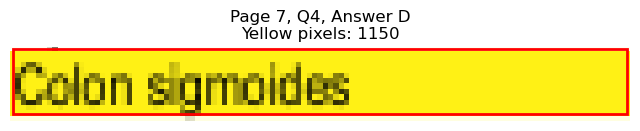

Page 7, Q4 - E: Detected box: x0=336.7, y0=326.1, x1=404.1, y1=338.2
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 443
Page 7, Q4, E: Yellow percentage: 0.0%


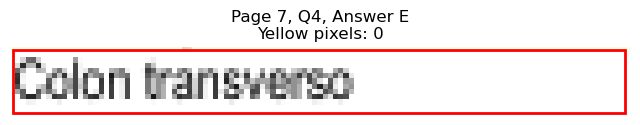


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=188.9, y1=398.4
Page 7, Q5, A: Yellow pixels: 1468
Page 7, Q5, A: Total non-white pixels: 2015
Page 7, Q5, A: Yellow percentage: 72.9%


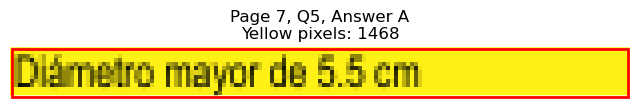

Page 7, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=160.1, y1=410.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 504
Page 7, Q5, B: Yellow percentage: 0.0%


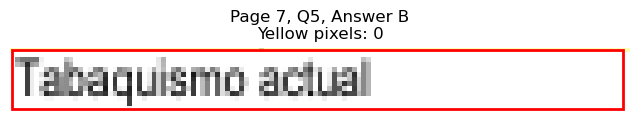

Page 7, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=164.4, y1=422.5
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 414
Page 7, Q5, C: Yellow percentage: 0.0%


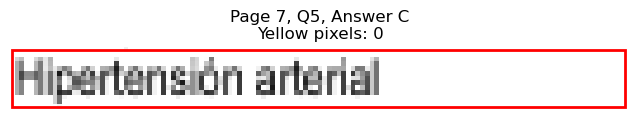

Page 7, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=396.6, y1=398.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 298
Page 7, Q5, D: Yellow percentage: 0.0%


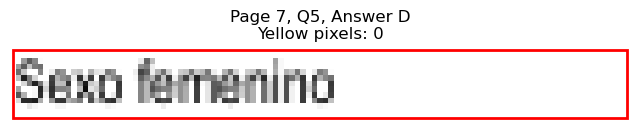

Page 7, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=407.5, y1=410.4
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 366
Page 7, Q5, E: Yellow percentage: 0.0%


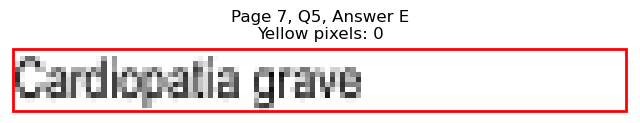


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=163.0, y1=482.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 414
Page 7, Q6, A: Yellow percentage: 0.0%


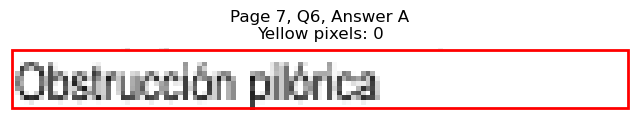

Page 7, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=148.2, y1=494.8
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 304
Page 7, Q6, B: Yellow percentage: 0.0%


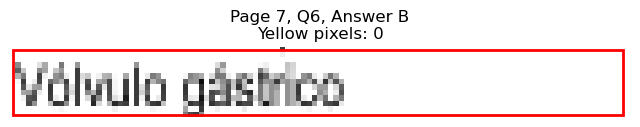

Page 7, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=163.9, y1=506.8
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 416
Page 7, Q6, C: Yellow percentage: 0.0%


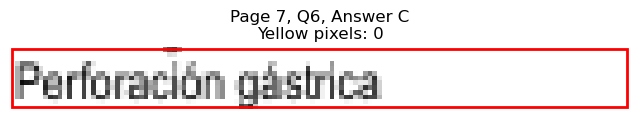

Page 7, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=410.4, y1=482.8
Page 7, Q6, D: Yellow pixels: 1
Page 7, Q6, D: Total non-white pixels: 516
Page 7, Q6, D: Yellow percentage: 0.2%


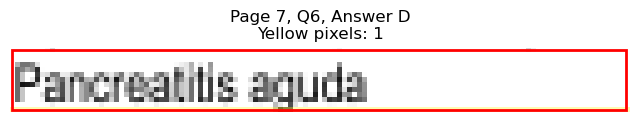

Page 7, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=423.3, y1=494.8
Page 7, Q6, E: Yellow pixels: 1264
Page 7, Q6, E: Total non-white pixels: 1794
Page 7, Q6, E: Yellow percentage: 70.5%


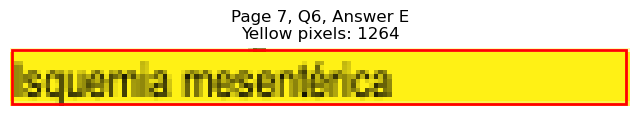


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=530.9, x1=154.3, y1=543.0
Page 7, Q7, A: Yellow pixels: 121
Page 7, Q7, A: Total non-white pixels: 589
Page 7, Q7, A: Yellow percentage: 20.5%


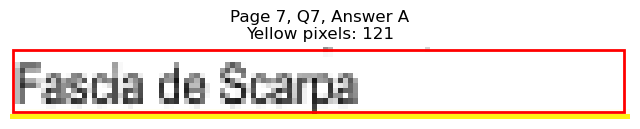

Page 7, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=153.5, y1=555.0
Page 7, Q7, B: Yellow pixels: 1162
Page 7, Q7, B: Total non-white pixels: 1562
Page 7, Q7, B: Yellow percentage: 74.4%


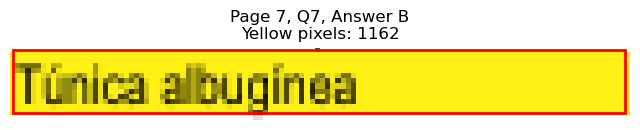

Page 7, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=142.9, y1=567.0
Page 7, Q7, C: Yellow pixels: 105
Page 7, Q7, C: Total non-white pixels: 415
Page 7, Q7, C: Yellow percentage: 25.3%


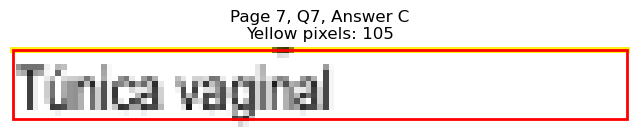

Page 7, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=398.0, y1=543.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 300
Page 7, Q7, D: Yellow percentage: 0.0%


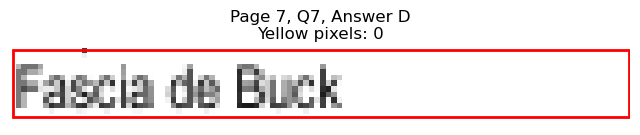

Page 7, Q7 - E: Detected box: x0=336.7, y0=542.9, x1=416.6, y1=555.0
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 403
Page 7, Q7, E: Yellow percentage: 0.0%


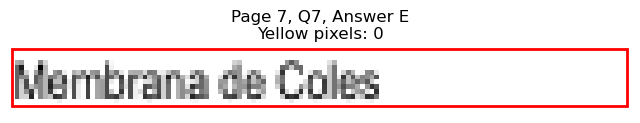


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=173.5, y1=603.3
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 476
Page 7, Q8, A: Yellow percentage: 0.0%


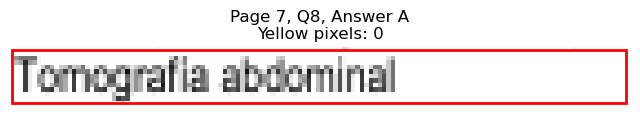

Page 7, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=175.0, y1=615.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 484
Page 7, Q8, B: Yellow percentage: 0.0%


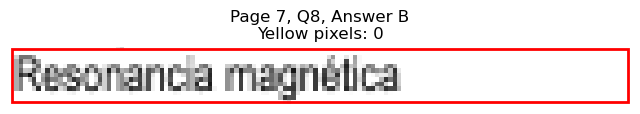

Page 7, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=166.3, y1=627.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 425
Page 7, Q8, C: Yellow percentage: 0.0%


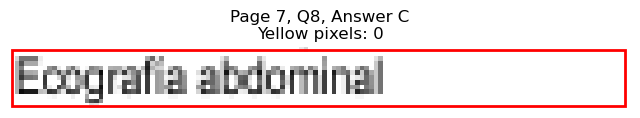

Page 7, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=454.4, y1=603.3
Page 7, Q8, D: Yellow pixels: 1555
Page 7, Q8, D: Total non-white pixels: 2197
Page 7, Q8, D: Yellow percentage: 70.8%


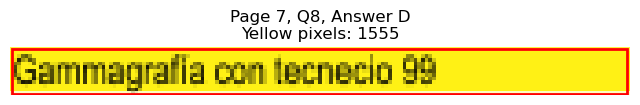

Page 7, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=406.5, y1=615.3
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 484
Page 7, Q8, E: Yellow percentage: 0.0%


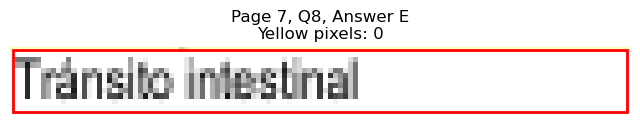


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=126.1, y1=675.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 227
Page 7, Q9, A: Yellow percentage: 0.0%


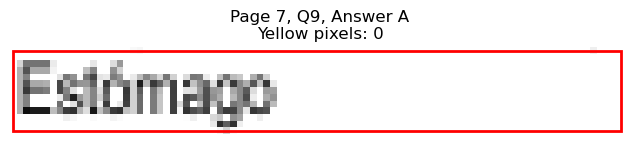

Page 7, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=122.3, y1=687.5
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 184
Page 7, Q9, B: Yellow percentage: 0.0%


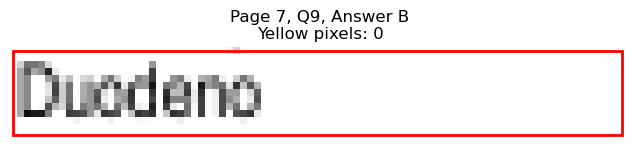

Page 7, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=116.5, y1=699.7
Page 7, Q9, C: Yellow pixels: 975
Page 7, Q9, C: Total non-white pixels: 1079
Page 7, Q9, C: Yellow percentage: 90.4%


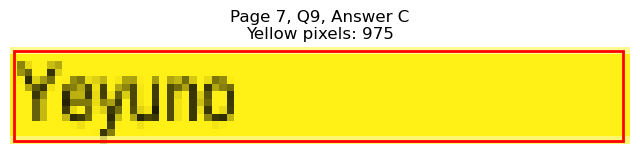

Page 7, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=404.1, y1=675.5
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 329
Page 7, Q9, D: Yellow percentage: 0.0%


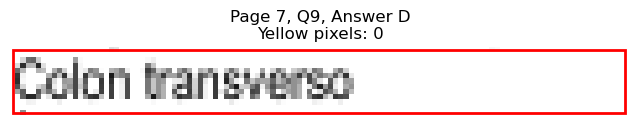

Page 7, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=357.8, y1=687.5
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 105
Page 7, Q9, E: Yellow percentage: 0.0%


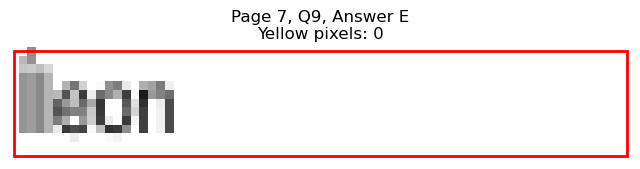


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=188.9, y1=735.8
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 528
Page 7, Q10, A: Yellow percentage: 0.0%


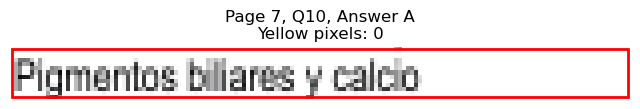

Page 7, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=145.8, y1=747.9
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 331
Page 7, Q10, B: Yellow percentage: 0.0%


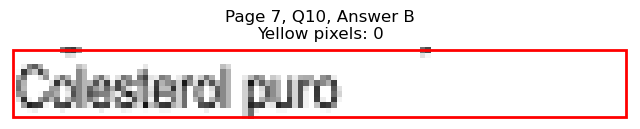

Page 7, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=153.5, y1=759.9
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 342
Page 7, Q10, C: Yellow percentage: 0.0%


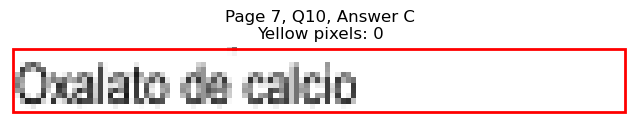

Page 7, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=420.9, y1=735.8
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 429
Page 7, Q10, D: Yellow percentage: 0.0%


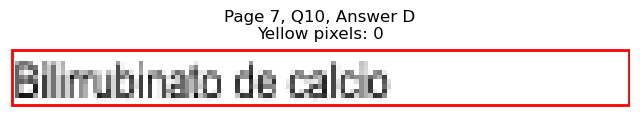

Page 7, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=480.8, y1=747.9
Page 7, Q10, E: Yellow pixels: 1670
Page 7, Q10, E: Total non-white pixels: 2470
Page 7, Q10, E: Yellow percentage: 67.6%


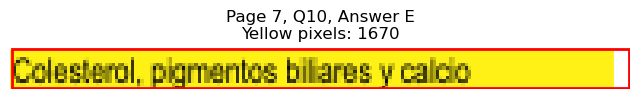


Page 7, Q10 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=214.7, y1=121.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 596
Page 8, Q1, A: Yellow percentage: 0.0%


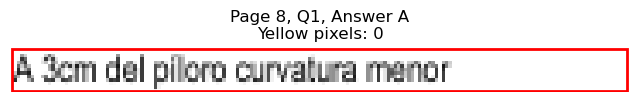

Page 8, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=205.1, y1=133.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 614
Page 8, Q1, B: Yellow percentage: 0.0%


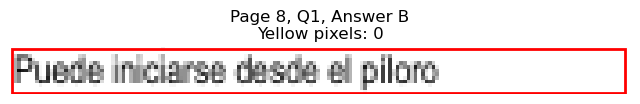

Page 8, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=242.9, y1=145.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 737
Page 8, Q1, C: Yellow percentage: 0.0%


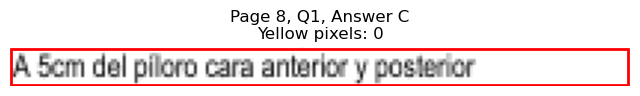

Page 8, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=488.9, y1=121.3
Page 8, Q1, D: Yellow pixels: 190
Page 8, Q1, D: Total non-white pixels: 922
Page 8, Q1, D: Yellow percentage: 20.6%


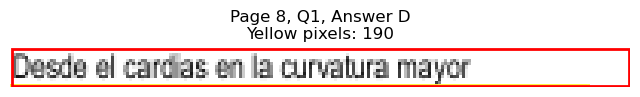

Page 8, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=466.4, y1=133.3
Page 8, Q1, E: Yellow pixels: 1721
Page 8, Q1, E: Total non-white pixels: 2353
Page 8, Q1, E: Yellow percentage: 73.1%


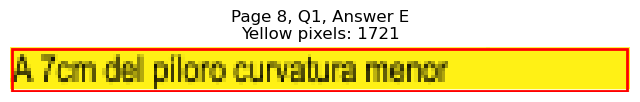


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=119.9, y1=193.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 181
Page 8, Q2, A: Yellow percentage: 0.0%


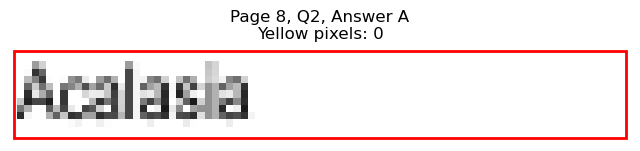

Page 8, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=163.5, y1=205.5
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 400
Page 8, Q2, B: Yellow percentage: 0.0%


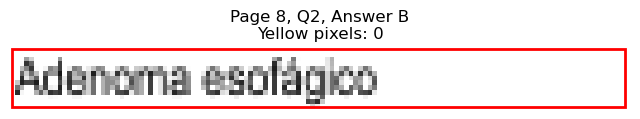

Page 8, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=142.5, y1=217.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 283
Page 8, Q2, C: Yellow percentage: 0.0%


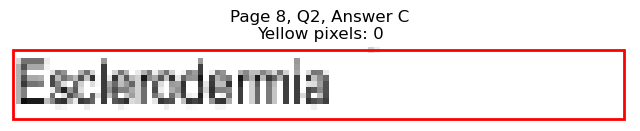

Page 8, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=408.4, y1=193.5
Page 8, Q2, D: Yellow pixels: 1295
Page 8, Q2, D: Total non-white pixels: 1599
Page 8, Q2, D: Yellow percentage: 81.0%


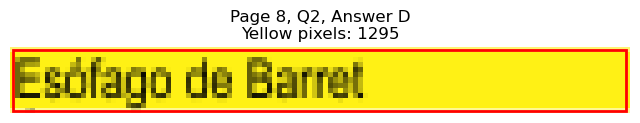

Page 8, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=421.9, y1=205.5
Page 8, Q2, E: Yellow pixels: 135
Page 8, Q2, E: Total non-white pixels: 585
Page 8, Q2, E: Yellow percentage: 23.1%


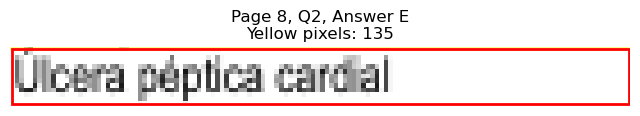


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=143.9, y1=253.8
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 296
Page 8, Q3, A: Yellow percentage: 0.0%


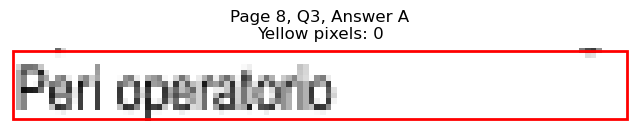

Page 8, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=202.7, y1=265.8
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 612
Page 8, Q3, B: Yellow percentage: 0.0%


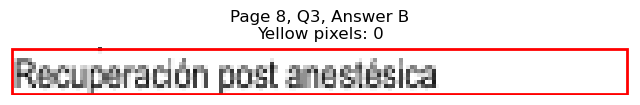

Page 8, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=253.5, y1=277.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 803
Page 8, Q3, C: Yellow percentage: 0.0%


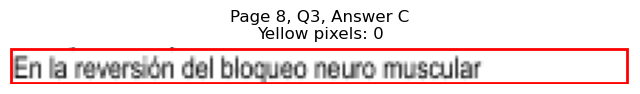

Page 8, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=375.9, y1=253.8
Page 8, Q3, D: Yellow pixels: 921
Page 8, Q3, D: Total non-white pixels: 1170
Page 8, Q3, D: Yellow percentage: 78.7%


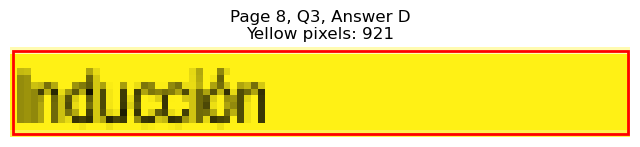

Page 8, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=405.7, y1=265.8
Page 8, Q3, E: Yellow pixels: 120
Page 8, Q3, E: Total non-white pixels: 456
Page 8, Q3, E: Yellow percentage: 26.3%


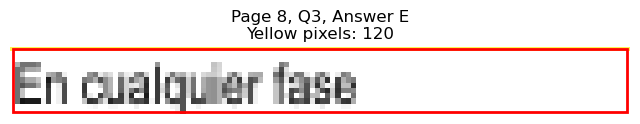


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=175.1, y1=350.2
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 466
Page 8, Q4, A: Yellow percentage: 0.0%


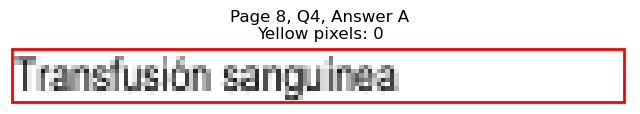

Page 8, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=213.8, y1=362.3
Page 8, Q4, B: Yellow pixels: 180
Page 8, Q4, B: Total non-white pixels: 806
Page 8, Q4, B: Yellow percentage: 22.3%


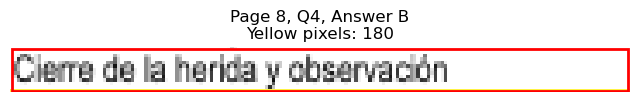

Page 8, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=135.7, y1=374.3
Page 8, Q4, C: Yellow pixels: 1026
Page 8, Q4, C: Total non-white pixels: 1326
Page 8, Q4, C: Yellow percentage: 77.4%


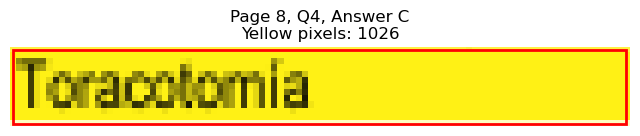

Page 8, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=469.8, y1=350.2
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 662
Page 8, Q4, D: Yellow percentage: 0.0%


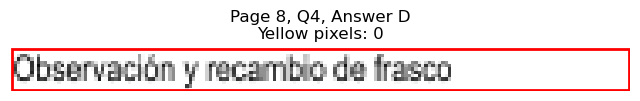

Page 8, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=461.1, y1=362.3
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 626
Page 8, Q4, E: Yellow percentage: 0.0%


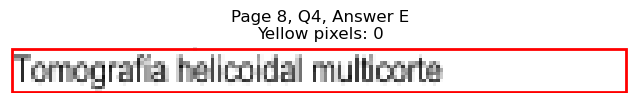


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=126.1, y1=410.4
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 228
Page 8, Q5, A: Yellow percentage: 0.0%


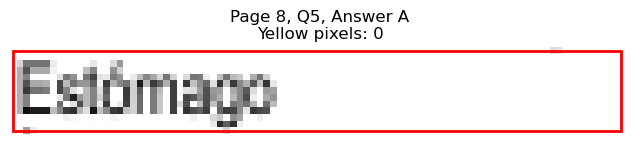

Page 8, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=106.1, y1=422.5
Page 8, Q5, B: Yellow pixels: 856
Page 8, Q5, B: Total non-white pixels: 949
Page 8, Q5, B: Yellow percentage: 90.2%


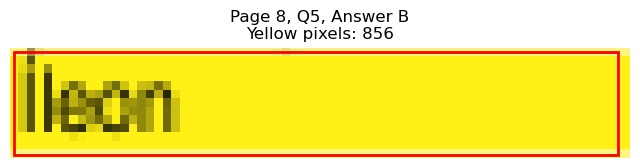

Page 8, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=116.5, y1=434.5
Page 8, Q5, C: Yellow pixels: 83
Page 8, Q5, C: Total non-white pixels: 219
Page 8, Q5, C: Yellow percentage: 37.9%


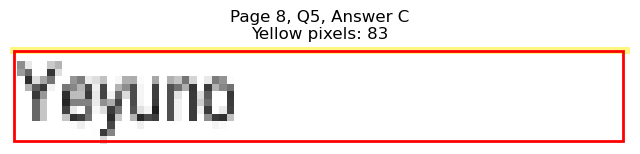

Page 8, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=374.0, y1=410.4
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 188
Page 8, Q5, D: Yellow percentage: 0.0%


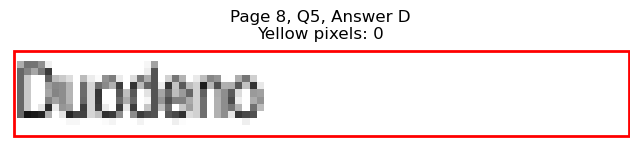

Page 8, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=361.5, y1=422.5
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 112
Page 8, Q5, E: Yellow percentage: 0.0%


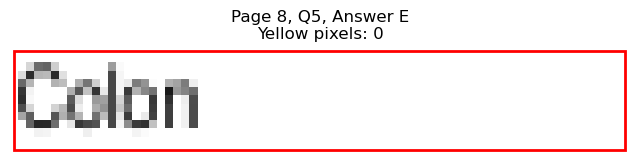


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=170.2, y1=470.7
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 430
Page 8, Q6, A: Yellow percentage: 0.0%


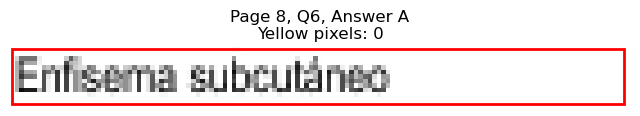

Page 8, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=162.0, y1=482.8
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 523
Page 8, Q6, B: Yellow percentage: 0.0%


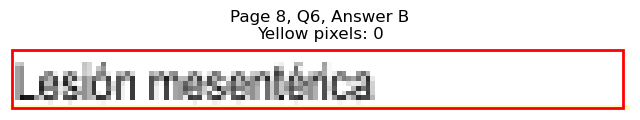

Page 8, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=129.5, y1=494.8
Page 8, Q6, C: Yellow pixels: 959
Page 8, Q6, C: Total non-white pixels: 1248
Page 8, Q6, C: Yellow percentage: 76.8%


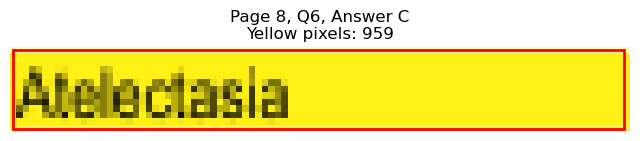

Page 8, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=399.0, y1=470.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 300
Page 8, Q6, D: Yellow percentage: 0.0%


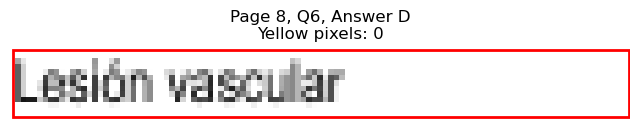

Page 8, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=417.6, y1=482.8
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 378
Page 8, Q6, E: Yellow percentage: 0.0%


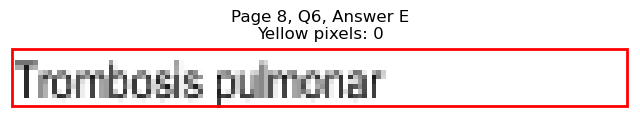


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=153.4, y1=530.9
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 349
Page 8, Q7, A: Yellow percentage: 0.0%


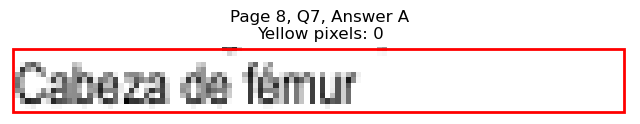

Page 8, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=132.9, y1=543.0
Page 8, Q7, B: Yellow pixels: 99
Page 8, Q7, B: Total non-white pixels: 479
Page 8, Q7, B: Yellow percentage: 20.7%


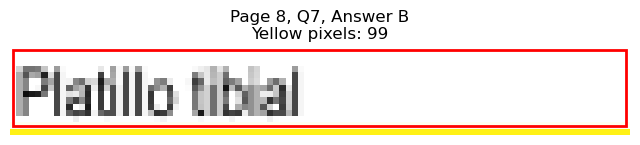

Page 8, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=157.8, y1=555.0
Page 8, Q7, C: Yellow pixels: 1180
Page 8, Q7, C: Total non-white pixels: 1612
Page 8, Q7, C: Yellow percentage: 73.2%


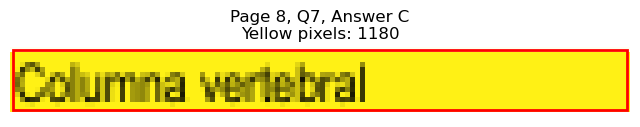

Page 8, Q7 - D: Detected box: x0=336.7, y0=518.8, x1=366.8, y1=530.9
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 151
Page 8, Q7, D: Yellow percentage: 0.0%


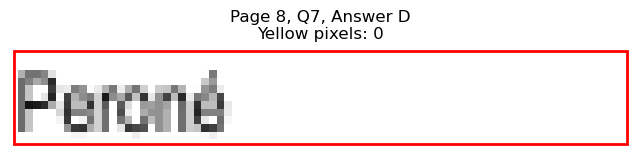

Page 8, Q7 - E: Detected box: x0=336.7, y0=530.9, x1=367.3, y1=543.0
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 154
Page 8, Q7, E: Yellow percentage: 0.0%


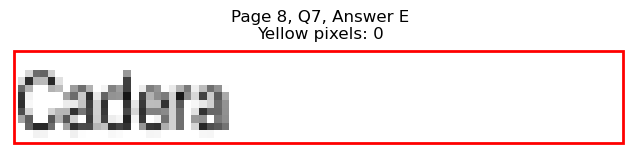


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=163.5, y1=603.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 411
Page 8, Q8, A: Yellow percentage: 0.0%


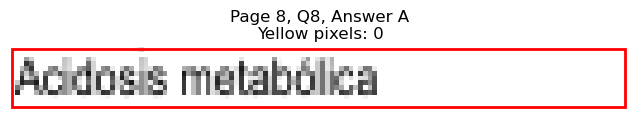

Page 8, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=166.8, y1=615.3
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 433
Page 8, Q8, B: Yellow percentage: 0.0%


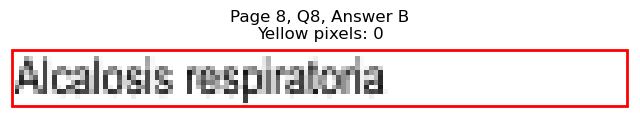

Page 8, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=165.4, y1=627.3
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 424
Page 8, Q8, C: Yellow percentage: 0.0%


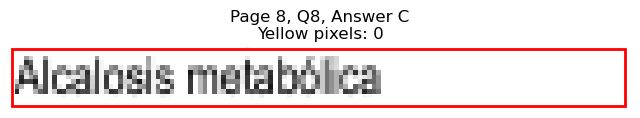

Page 8, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=428.7, y1=603.3
Page 8, Q8, D: Yellow pixels: 1334
Page 8, Q8, D: Total non-white pixels: 1859
Page 8, Q8, D: Yellow percentage: 71.8%


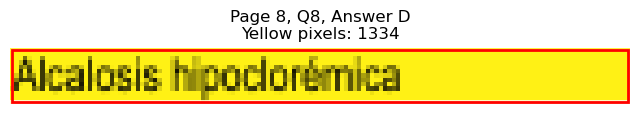

Page 8, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=429.6, y1=615.3
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 628
Page 8, Q8, E: Yellow percentage: 0.0%


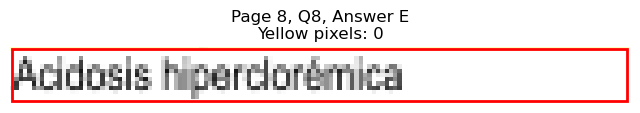


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=85.0, y0=651.4, x1=165.4, y1=663.5
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 418
Page 8, Q9, A: Yellow percentage: 0.0%


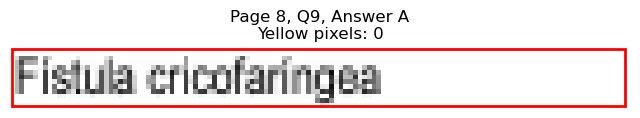

Page 8, Q9 - B: Detected box: x0=85.0, y0=663.4, x1=134.3, y1=675.5
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 265
Page 8, Q9, B: Yellow percentage: 0.0%


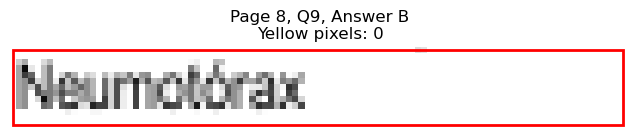

Page 8, Q9 - C: Detected box: x0=85.0, y0=675.4, x1=132.4, y1=687.5
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 247
Page 8, Q9, C: Yellow percentage: 0.0%


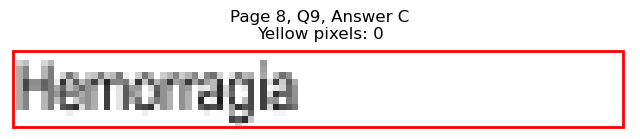

Page 8, Q9 - D: Detected box: x0=336.7, y0=651.4, x1=417.6, y1=663.5
Page 8, Q9, D: Yellow pixels: 1363
Page 8, Q9, D: Total non-white pixels: 1716
Page 8, Q9, D: Yellow percentage: 79.4%


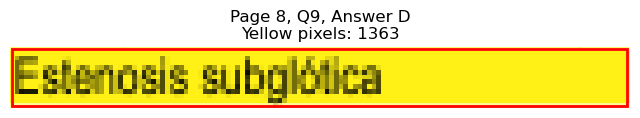

Page 8, Q9 - E: Detected box: x0=336.7, y0=663.4, x1=445.9, y1=675.5
Page 8, Q9, E: Yellow pixels: 160
Page 8, Q9, E: Total non-white pixels: 683
Page 8, Q9, E: Yellow percentage: 23.4%


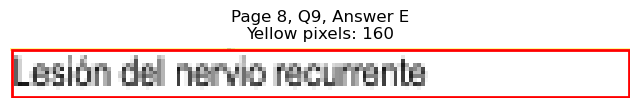


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=85.0, y0=711.7, x1=178.3, y1=723.8
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 511
Page 8, Q10, A: Yellow percentage: 0.0%


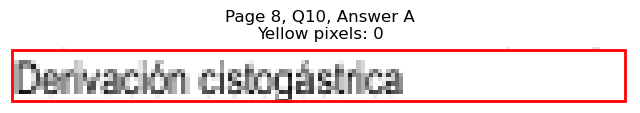

Page 8, Q10 - B: Detected box: x0=85.0, y0=723.7, x1=200.3, y1=735.8
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 608
Page 8, Q10, B: Yellow percentage: 0.0%


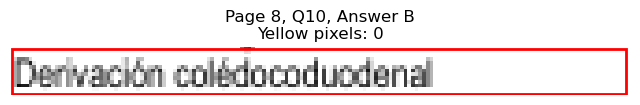

Page 8, Q10 - C: Detected box: x0=85.0, y0=735.8, x1=185.1, y1=747.9
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 499
Page 8, Q10, C: Yellow percentage: 0.0%


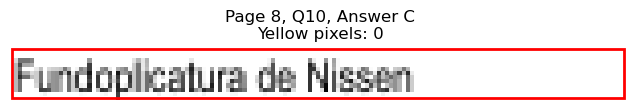

Page 8, Q10 - D: Detected box: x0=336.7, y0=711.7, x1=433.9, y1=723.8
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 643
Page 8, Q10, D: Yellow percentage: 0.0%


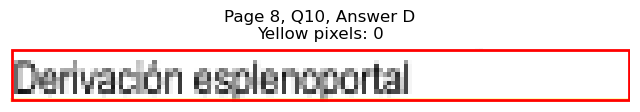

Page 8, Q10 - E: Detected box: x0=336.7, y0=723.7, x1=489.0, y1=735.8
Page 8, Q10, E: Yellow pixels: 1702
Page 8, Q10, E: Total non-white pixels: 2470
Page 8, Q10, E: Yellow percentage: 68.9%


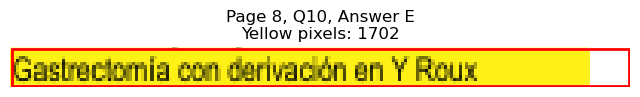


Page 8, Q10 - Selected Answer: E (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=152.4, y1=109.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 357
Page 9, Q1, A: Yellow percentage: 0.0%


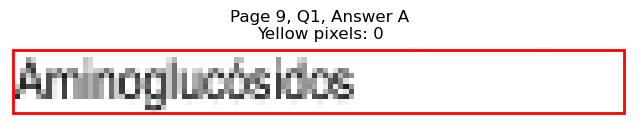

Page 9, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=136.7, y1=121.3
Page 9, Q1, B: Yellow pixels: 1011
Page 9, Q1, B: Total non-white pixels: 1339
Page 9, Q1, B: Yellow percentage: 75.5%


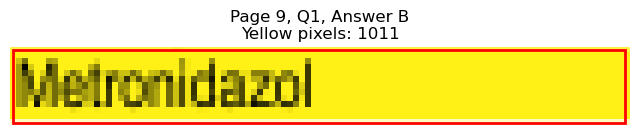

Page 9, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=152.4, y1=133.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 475
Page 9, Q1, C: Yellow percentage: 0.0%


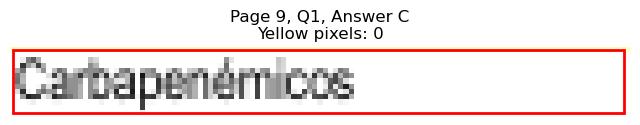

Page 9, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=397.5, y1=109.2
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 310
Page 9, Q1, D: Yellow percentage: 0.0%


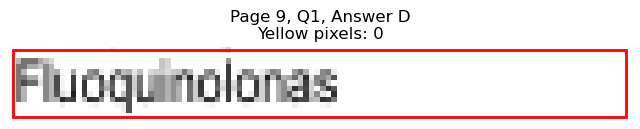

Page 9, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=380.2, y1=121.3
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 240
Page 9, Q1, E: Yellow percentage: 0.0%


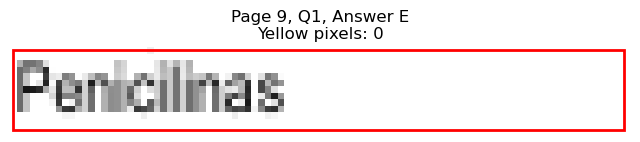


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=274.0, y1=169.4
Page 9, Q2, A: Yellow pixels: 2339
Page 9, Q2, A: Total non-white pixels: 3133
Page 9, Q2, A: Yellow percentage: 74.7%


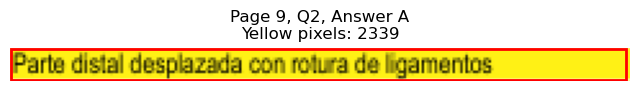

Page 9, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=152.4, y1=181.5
Page 9, Q2, B: Yellow pixels: 119
Page 9, Q2, B: Total non-white pixels: 450
Page 9, Q2, B: Yellow percentage: 26.4%


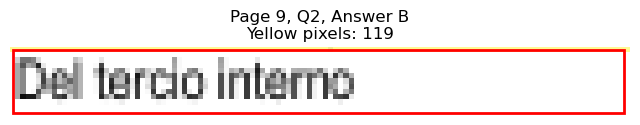

Page 9, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=284.6, y1=193.5
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 1013
Page 9, Q2, C: Yellow percentage: 0.0%


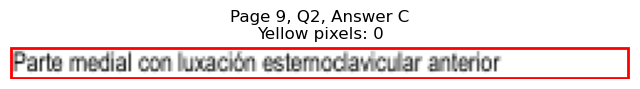

Page 9, Q2 - D: Detected box: x0=85.0, y0=193.4, x1=288.9, y1=205.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 1048
Page 9, Q2, D: Yellow percentage: 0.0%


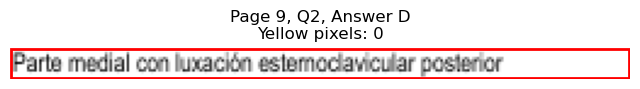

Page 9, Q2 - E: Detected box: x0=85.0, y0=205.5, x1=204.2, y1=217.7
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 594
Page 9, Q2, E: Yellow percentage: 0.0%


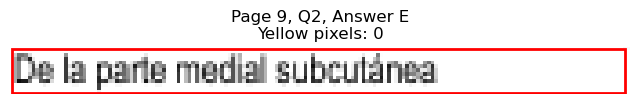


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=121.8, y1=253.8
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 191
Page 9, Q3, A: Yellow percentage: 0.0%


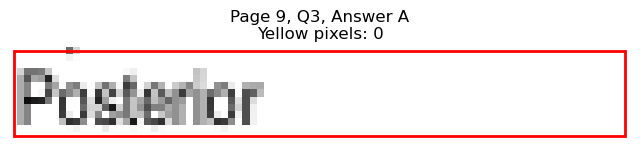

Page 9, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=114.1, y1=265.8
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 140
Page 9, Q3, B: Yellow percentage: 0.0%


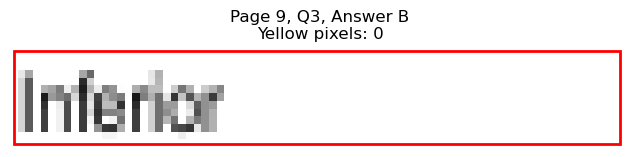

Page 9, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=113.7, y1=277.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 133
Page 9, Q3, C: Yellow percentage: 0.0%


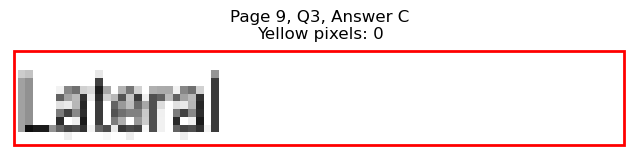

Page 9, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=371.6, y1=253.8
Page 9, Q3, D: Yellow pixels: 1
Page 9, Q3, D: Total non-white pixels: 259
Page 9, Q3, D: Yellow percentage: 0.4%


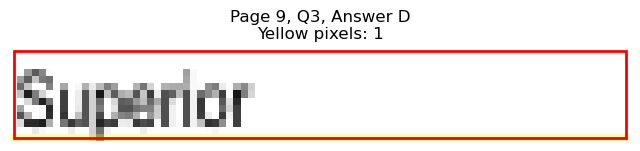

Page 9, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=369.2, y1=265.8
Page 9, Q3, E: Yellow pixels: 886
Page 9, Q3, E: Total non-white pixels: 1092
Page 9, Q3, E: Yellow percentage: 81.1%


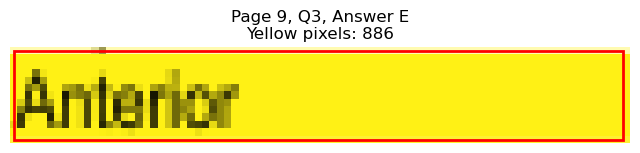


Page 9, Q3 - Selected Answer: E (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=155.3, y1=314.0
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 372
Page 9, Q4, A: Yellow percentage: 0.0%


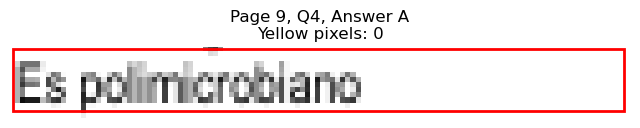

Page 9, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=176.4, y1=326.0
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 469
Page 9, Q4, B: Yellow percentage: 0.0%


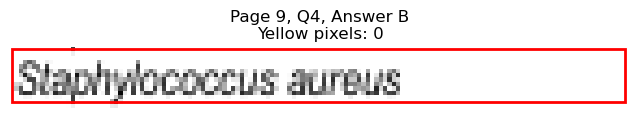

Page 9, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=181.7, y1=338.2
Page 9, Q4, C: Yellow pixels: 1378
Page 9, Q4, C: Total non-white pixels: 1924
Page 9, Q4, C: Yellow percentage: 71.6%


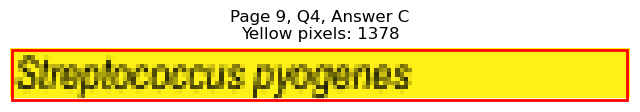

Page 9, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=474.6, y1=314.0
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 707
Page 9, Q4, D: Yellow percentage: 0.0%


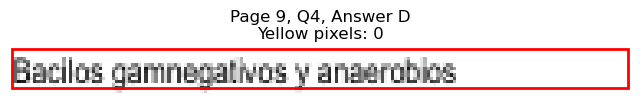

Page 9, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=411.8, y1=326.0
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 435
Page 9, Q4, E: Yellow percentage: 0.0%


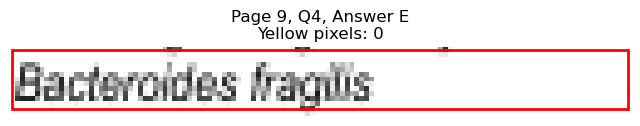


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=220.5, y1=374.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 674
Page 9, Q5, A: Yellow percentage: 0.0%


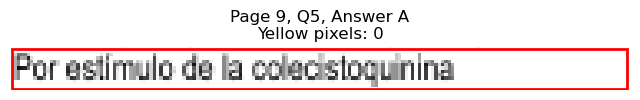

Page 9, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=273.7, y1=386.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 950
Page 9, Q5, B: Yellow percentage: 0.0%


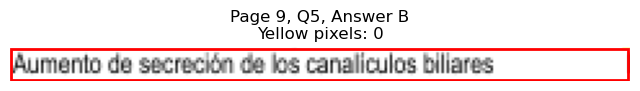

Page 9, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=197.9, y1=398.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 584
Page 9, Q5, C: Yellow percentage: 0.0%


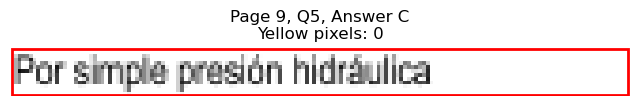

Page 9, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=477.0, y1=374.3
Page 9, Q5, D: Yellow pixels: 1682
Page 9, Q5, D: Total non-white pixels: 2470
Page 9, Q5, D: Yellow percentage: 68.1%


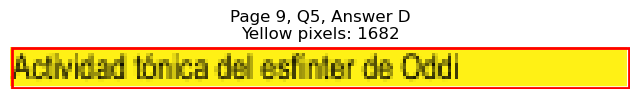

Page 9, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=440.1, y1=386.3
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 661
Page 9, Q5, E: Yellow percentage: 0.0%


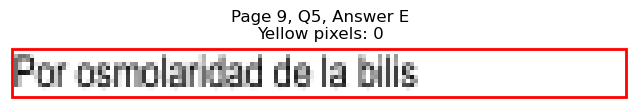


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=422.4, x1=191.8, y1=434.5
Page 9, Q6, A: Yellow pixels: 1625
Page 9, Q6, A: Total non-white pixels: 2054
Page 9, Q6, A: Yellow percentage: 79.1%


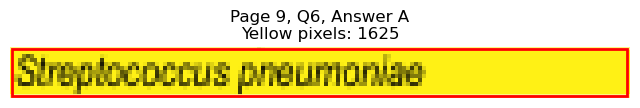

Page 9, Q6 - B: Detected box: x0=85.0, y0=434.4, x1=183.1, y1=446.5
Page 9, Q6, B: Yellow pixels: 150
Page 9, Q6, B: Total non-white pixels: 649
Page 9, Q6, B: Yellow percentage: 23.1%


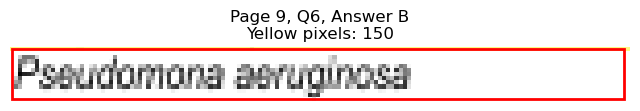

Page 9, Q6 - C: Detected box: x0=85.0, y0=446.6, x1=194.2, y1=458.7
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 589
Page 9, Q6, C: Yellow percentage: 0.0%


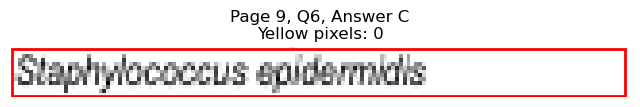

Page 9, Q6 - D: Detected box: x0=336.7, y0=422.4, x1=431.5, y1=434.5
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 479
Page 9, Q6, D: Yellow percentage: 0.0%


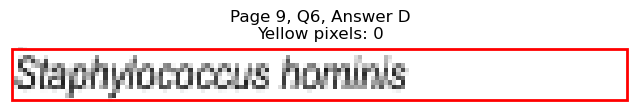

Page 9, Q6 - E: Detected box: x0=336.7, y0=434.4, x1=420.9, y1=446.5
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 463
Page 9, Q6, E: Yellow percentage: 0.0%


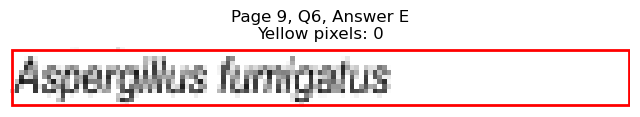


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=482.7, x1=133.3, y1=494.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 247
Page 9, Q7, A: Yellow percentage: 0.0%


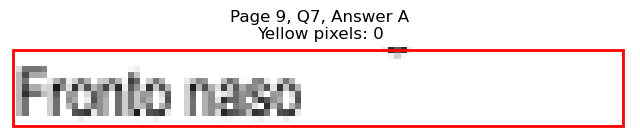

Page 9, Q7 - B: Detected box: x0=85.0, y0=494.7, x1=151.1, y1=506.8
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 304
Page 9, Q7, B: Yellow percentage: 0.0%


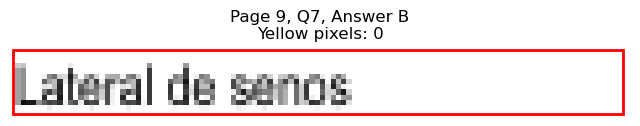

Page 9, Q7 - C: Detected box: x0=85.0, y0=506.8, x1=132.4, y1=518.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 241
Page 9, Q7, C: Yellow percentage: 0.0%


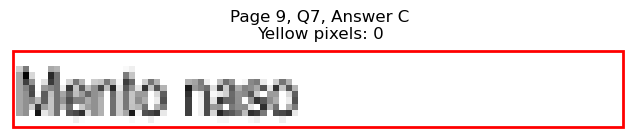

Page 9, Q7 - D: Detected box: x0=336.7, y0=482.7, x1=391.3, y1=494.8
Page 9, Q7, D: Yellow pixels: 1042
Page 9, Q7, D: Total non-white pixels: 1378
Page 9, Q7, D: Yellow percentage: 75.6%


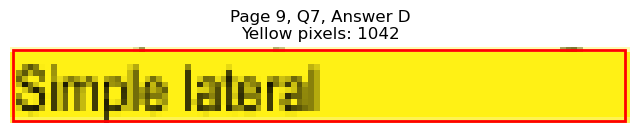

Page 9, Q7 - E: Detected box: x0=336.7, y0=494.7, x1=395.1, y1=506.8
Page 9, Q7, E: Yellow pixels: 109
Page 9, Q7, E: Total non-white pixels: 412
Page 9, Q7, E: Yellow percentage: 26.5%


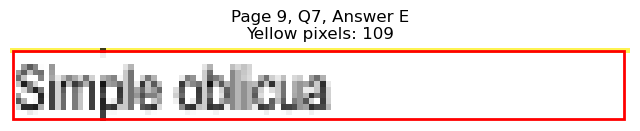


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=542.9, x1=178.8, y1=555.0
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 499
Page 9, Q8, A: Yellow percentage: 0.0%


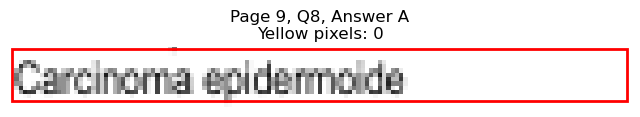

Page 9, Q8 - B: Detected box: x0=85.0, y0=554.9, x1=152.1, y1=567.0
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 343
Page 9, Q8, B: Yellow percentage: 0.0%


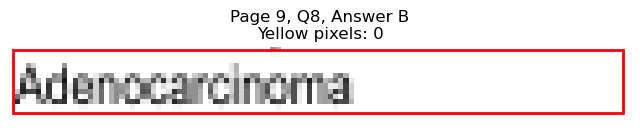

Page 9, Q8 - C: Detected box: x0=85.0, y0=567.1, x1=127.6, y1=579.2
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 221
Page 9, Q8, C: Yellow percentage: 0.0%


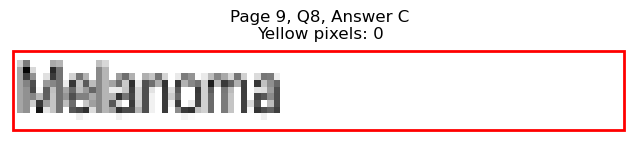

Page 9, Q8 - D: Detected box: x0=336.7, y0=542.9, x1=394.2, y1=555.0
Page 9, Q8, D: Yellow pixels: 109
Page 9, Q8, D: Total non-white pixels: 508
Page 9, Q8, D: Yellow percentage: 21.5%


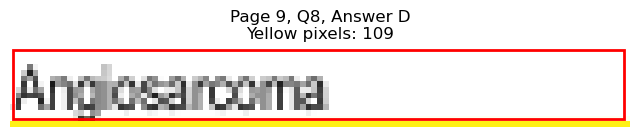

Page 9, Q8 - E: Detected box: x0=336.7, y0=554.9, x1=467.9, y1=567.0
Page 9, Q8, E: Yellow pixels: 1684
Page 9, Q8, E: Total non-white pixels: 2548
Page 9, Q8, E: Yellow percentage: 66.1%


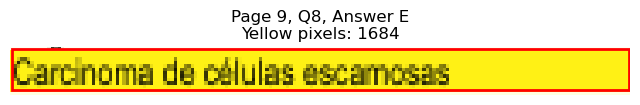


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=603.2, x1=119.4, y1=615.3
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 178
Page 9, Q9, A: Yellow percentage: 0.0%


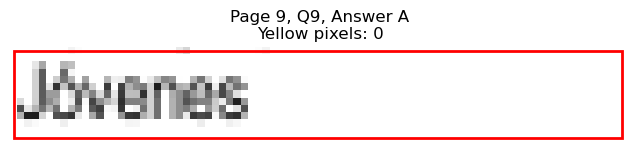

Page 9, Q9 - B: Detected box: x0=85.0, y0=615.2, x1=116.1, y1=627.3
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 149
Page 9, Q9, B: Yellow percentage: 0.0%


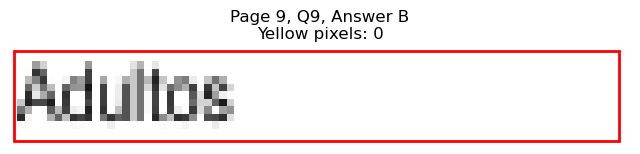

Page 9, Q9 - C: Detected box: x0=85.0, y0=627.3, x1=138.1, y1=639.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 251
Page 9, Q9, C: Yellow percentage: 0.0%


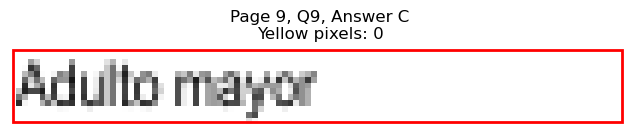

Page 9, Q9 - D: Detected box: x0=336.7, y0=603.2, x1=440.6, y1=615.3
Page 9, Q9, D: Yellow pixels: 155
Page 9, Q9, D: Total non-white pixels: 681
Page 9, Q9, D: Yellow percentage: 22.8%


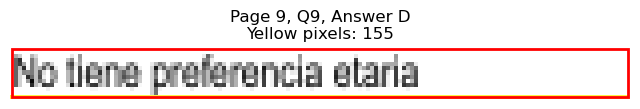

Page 9, Q9 - E: Detected box: x0=336.7, y0=615.2, x1=361.0, y1=627.3
Page 9, Q9, E: Yellow pixels: 804
Page 9, Q9, E: Total non-white pixels: 988
Page 9, Q9, E: Yellow percentage: 81.4%


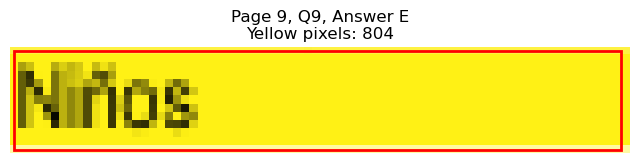


Page 9, Q9 - Selected Answer: E (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=85.0, y0=663.4, x1=98.4, y1=675.5
Page 9, Q10, A: Yellow pixels: 797
Page 9, Q10, A: Total non-white pixels: 845
Page 9, Q10, A: Yellow percentage: 94.3%


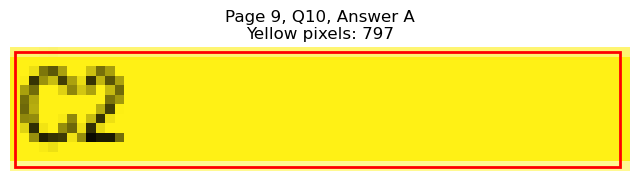

Page 9, Q10 - B: Detected box: x0=85.0, y0=675.4, x1=98.4, y1=687.5
Page 9, Q10, B: Yellow pixels: 65
Page 9, Q10, B: Total non-white pixels: 117
Page 9, Q10, B: Yellow percentage: 55.6%


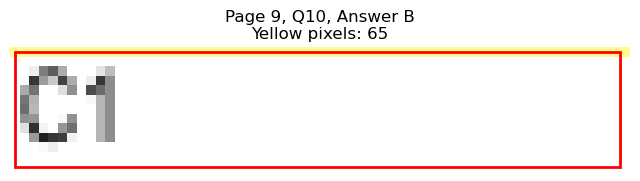

Page 9, Q10 - C: Detected box: x0=85.0, y0=687.5, x1=98.4, y1=699.7
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 63
Page 9, Q10, C: Yellow percentage: 0.0%


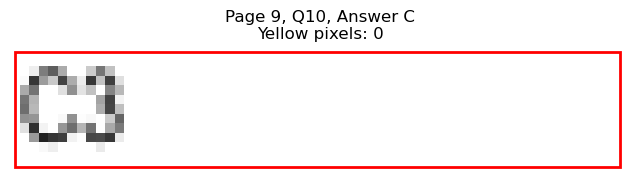

Page 9, Q10 - D: Detected box: x0=336.7, y0=663.4, x1=350.1, y1=675.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 58
Page 9, Q10, D: Yellow percentage: 0.0%


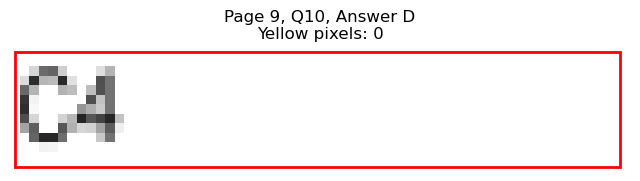

Page 9, Q10 - E: Detected box: x0=336.7, y0=675.4, x1=350.1, y1=687.5
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 62
Page 9, Q10, E: Yellow percentage: 0.0%


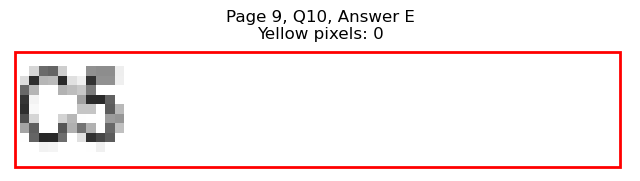


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=85.0, y0=723.7, x1=125.2, y1=735.8
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 207
Page 9, Q11, A: Yellow percentage: 0.0%


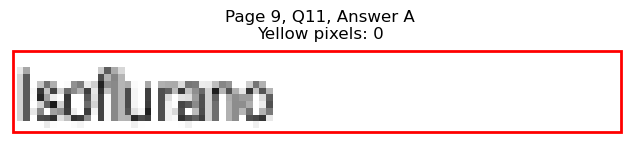

Page 9, Q11 - B: Detected box: x0=85.0, y0=735.8, x1=121.8, y1=747.9
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 200
Page 9, Q11, B: Yellow percentage: 0.0%


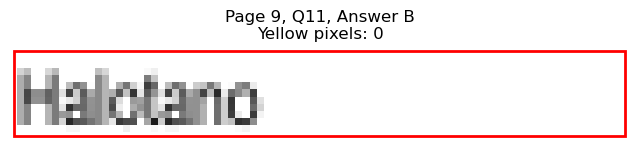

Page 9, Q11 - C: Detected box: x0=85.0, y0=747.8, x1=124.2, y1=759.9
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 198
Page 9, Q11, C: Yellow percentage: 0.0%


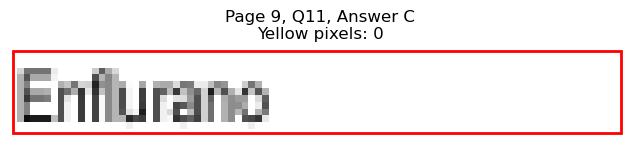

Page 9, Q11 - D: Detected box: x0=336.7, y0=723.7, x1=385.0, y1=735.8
Page 9, Q11, D: Yellow pixels: 1009
Page 9, Q11, D: Total non-white pixels: 1300
Page 9, Q11, D: Yellow percentage: 77.6%


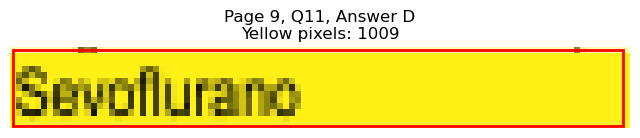

Page 9, Q11 - E: Detected box: x0=336.7, y0=735.8, x1=380.7, y1=747.9
Page 9, Q11, E: Yellow pixels: 95
Page 9, Q11, E: Total non-white pixels: 319
Page 9, Q11, E: Yellow percentage: 29.8%


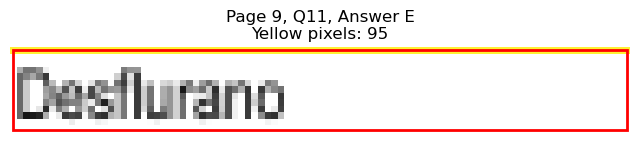


Page 9, Q11 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=149.2, y1=109.2
Page 10, Q1, A: Yellow pixels: 1102
Page 10, Q1, A: Total non-white pixels: 1508
Page 10, Q1, A: Yellow percentage: 73.1%


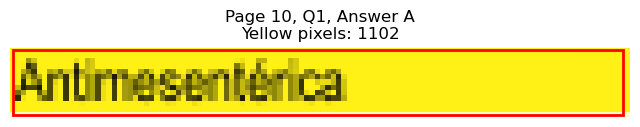

Page 10, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=113.8, y1=121.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 213
Page 10, Q1, B: Yellow percentage: 0.0%


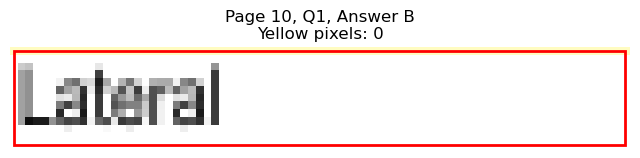

Page 10, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=134.3, y1=133.3
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 278
Page 10, Q1, C: Yellow percentage: 0.0%


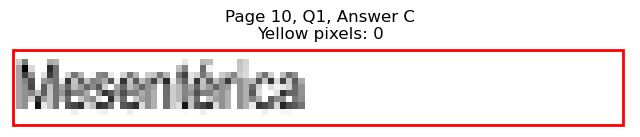

Page 10, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=421.4, y1=109.2
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 429
Page 10, Q1, D: Yellow percentage: 0.0%


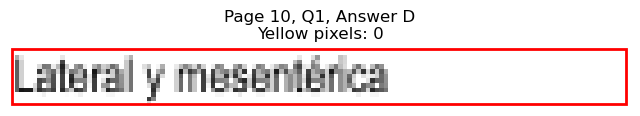

Page 10, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=454.4, y1=121.3
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 584
Page 10, Q1, E: Yellow percentage: 0.0%


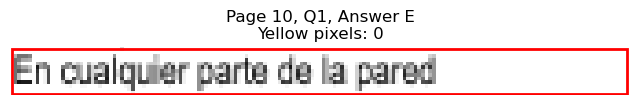


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=180.7, y1=169.4
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 487
Page 10, Q2, A: Yellow percentage: 0.0%


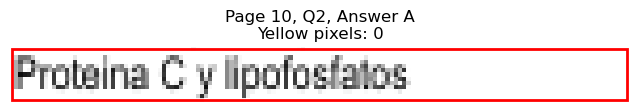

Page 10, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=193.7, y1=181.5
Page 10, Q2, B: Yellow pixels: 160
Page 10, Q2, B: Total non-white pixels: 707
Page 10, Q2, B: Yellow percentage: 22.6%


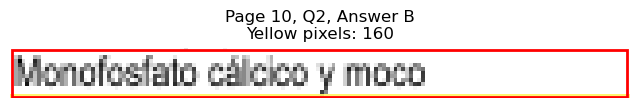

Page 10, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=190.4, y1=193.5
Page 10, Q2, C: Yellow pixels: 1608
Page 10, Q2, C: Total non-white pixels: 2041
Page 10, Q2, C: Yellow percentage: 78.8%


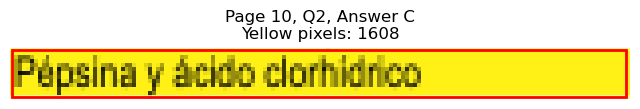

Page 10, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=460.7, y1=169.4
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 599
Page 10, Q2, D: Yellow percentage: 0.0%


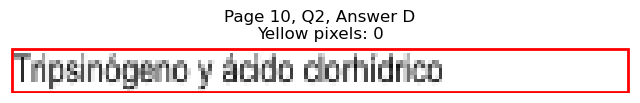

Page 10, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=459.2, y1=181.5
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 631
Page 10, Q2, E: Yellow percentage: 0.0%


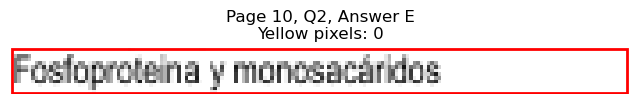


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=145.8, y1=253.8
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 440
Page 10, Q3, A: Yellow percentage: 0.0%


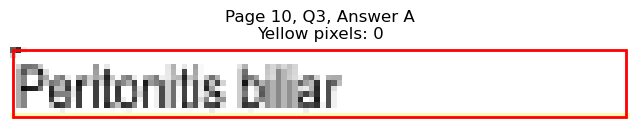

Page 10, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=182.2, y1=265.8
Page 10, Q3, B: Yellow pixels: 1386
Page 10, Q3, B: Total non-white pixels: 1937
Page 10, Q3, B: Yellow percentage: 71.6%


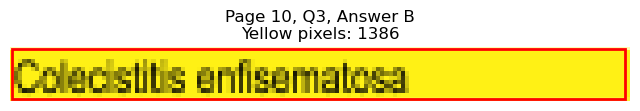

Page 10, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=152.9, y1=277.9
Page 10, Q3, C: Yellow pixels: 119
Page 10, Q3, C: Total non-white pixels: 480
Page 10, Q3, C: Yellow percentage: 24.8%


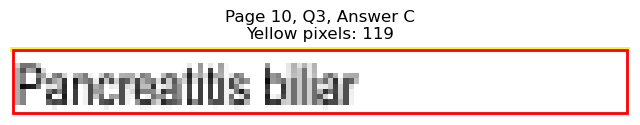

Page 10, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=419.5, y1=253.8
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 422
Page 10, Q3, D: Yellow percentage: 0.0%


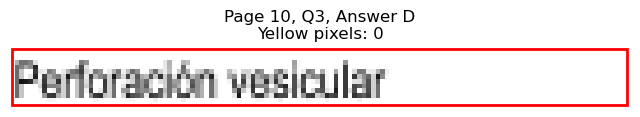

Page 10, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=423.8, y1=265.8
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 467
Page 10, Q3, E: Yellow percentage: 0.0%


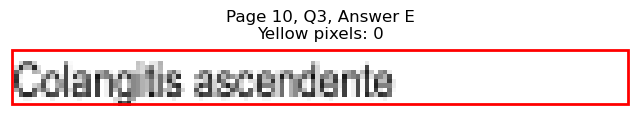


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=174.5, y1=314.0
Page 10, Q4, A: Yellow pixels: 141
Page 10, Q4, A: Total non-white pixels: 728
Page 10, Q4, A: Yellow percentage: 19.4%


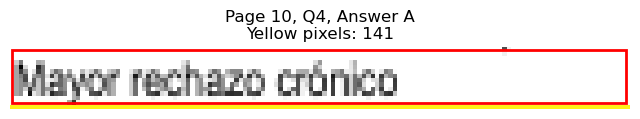

Page 10, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=197.9, y1=326.0
Page 10, Q4, B: Yellow pixels: 1488
Page 10, Q4, B: Total non-white pixels: 2296
Page 10, Q4, B: Yellow percentage: 64.8%


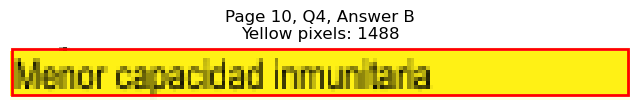

Page 10, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=244.9, y1=338.2
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 1002
Page 10, Q4, C: Yellow percentage: 0.0%


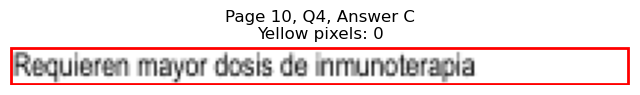

Page 10, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=460.2, y1=314.0
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 588
Page 10, Q4, D: Yellow percentage: 0.0%


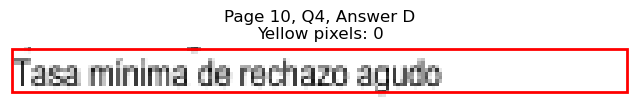

Page 10, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=488.9, y1=326.0
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 773
Page 10, Q4, E: Yellow percentage: 0.0%


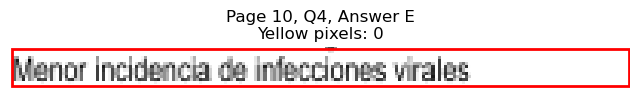


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=151.0, y1=386.3
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 371
Page 10, Q5, A: Yellow percentage: 0.0%


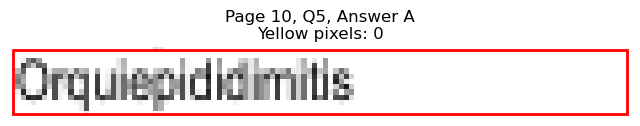

Page 10, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=144.9, y1=398.4
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 317
Page 10, Q5, B: Yellow percentage: 0.0%


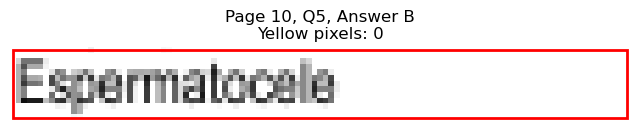

Page 10, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=161.1, y1=410.4
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 399
Page 10, Q5, C: Yellow percentage: 0.0%


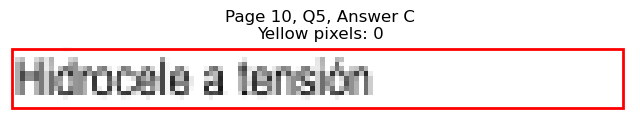

Page 10, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=379.3, y1=386.3
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 220
Page 10, Q5, D: Yellow percentage: 0.0%


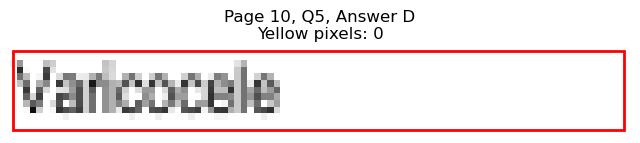

Page 10, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=403.6, y1=398.4
Page 10, Q5, E: Yellow pixels: 1152
Page 10, Q5, E: Total non-white pixels: 1534
Page 10, Q5, E: Yellow percentage: 75.1%


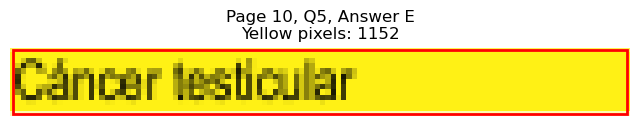


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=218.6, y1=446.5
Page 10, Q6, A: Yellow pixels: 1881
Page 10, Q6, A: Total non-white pixels: 2405
Page 10, Q6, A: Yellow percentage: 78.2%


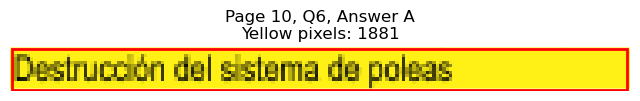

Page 10, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=186.5, y1=458.7
Page 10, Q6, B: Yellow pixels: 153
Page 10, Q6, B: Total non-white pixels: 621
Page 10, Q6, B: Yellow percentage: 24.6%


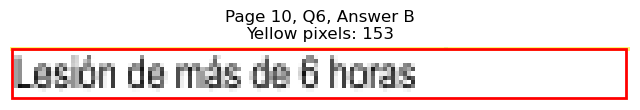

Page 10, Q6 - C: Detected box: x0=140.5, y0=458.6, x1=196.6, y1=470.7
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 442
Page 10, Q6, C: Yellow percentage: 0.0%


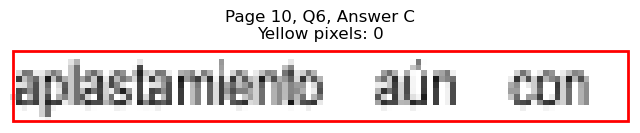

Page 10, Q6 - D: Detected box: x0=336.7, y0=434.4, x1=476.0, y1=446.5
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 675
Page 10, Q6, D: Yellow percentage: 0.0%


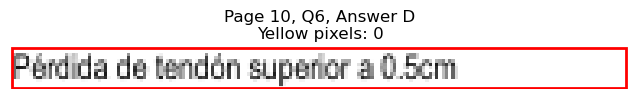

Page 10, Q6 - E: Detected box: x0=336.7, y0=446.6, x1=467.9, y1=458.7
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 631
Page 10, Q6, E: Yellow percentage: 0.0%


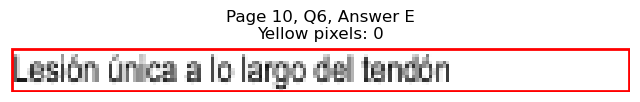


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=144.4, y1=518.9
Page 10, Q7, A: Yellow pixels: 1075
Page 10, Q7, A: Total non-white pixels: 1443
Page 10, Q7, A: Yellow percentage: 74.5%


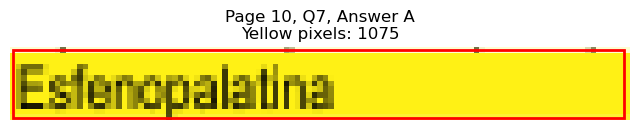

Page 10, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=146.3, y1=530.9
Page 10, Q7, B: Yellow pixels: 112
Page 10, Q7, B: Total non-white pixels: 436
Page 10, Q7, B: Yellow percentage: 25.7%


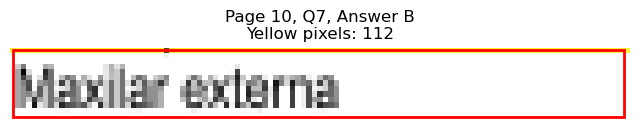

Page 10, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=135.7, y1=543.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 271
Page 10, Q7, C: Yellow percentage: 0.0%


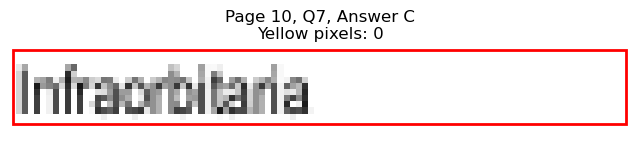

Page 10, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=362.0, y1=518.9
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 134
Page 10, Q7, D: Yellow percentage: 0.0%


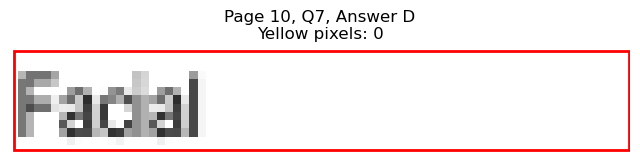

Page 10, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=402.8, y1=530.9
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 336
Page 10, Q7, E: Yellow percentage: 0.0%


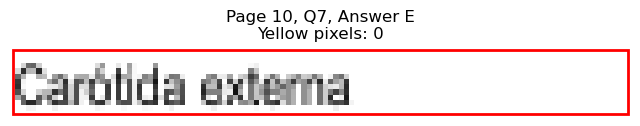


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=141.5, y1=579.2
Page 10, Q8, A: Yellow pixels: 1080
Page 10, Q8, A: Total non-white pixels: 1404
Page 10, Q8, A: Yellow percentage: 76.9%


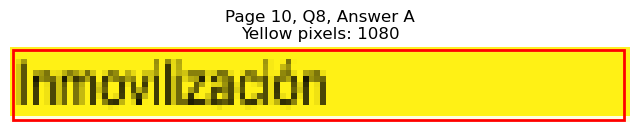

Page 10, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=148.2, y1=591.2
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 452
Page 10, Q8, B: Yellow percentage: 0.0%


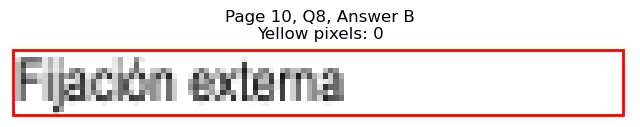

Page 10, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=192.7, y1=603.3
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 533
Page 10, Q8, C: Yellow percentage: 0.0%


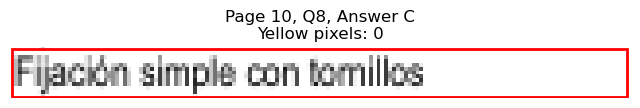

Page 10, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=464.0, y1=579.2
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 656
Page 10, Q8, D: Yellow percentage: 0.0%


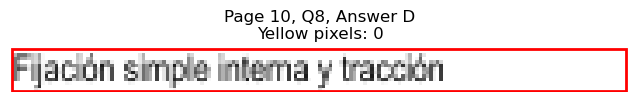

Page 10, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=447.7, y1=591.2
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 572
Page 10, Q8, E: Yellow percentage: 0.0%


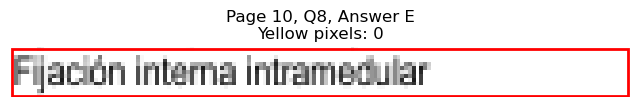


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=167.8, y1=675.5
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 425
Page 10, Q9, A: Yellow percentage: 0.0%


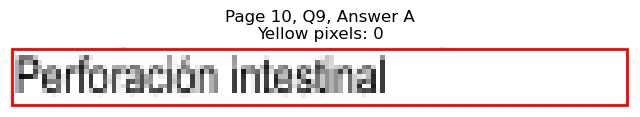

Page 10, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=208.5, y1=687.5
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 664
Page 10, Q9, B: Yellow percentage: 0.0%


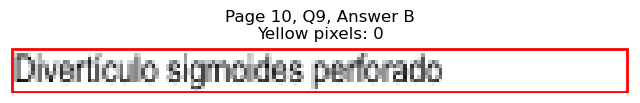

Page 10, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=194.7, y1=699.7
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 581
Page 10, Q9, C: Yellow percentage: 0.0%


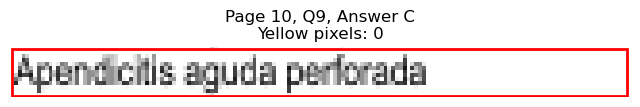

Page 10, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=433.4, y1=675.5
Page 10, Q9, D: Yellow pixels: 1516
Page 10, Q9, D: Total non-white pixels: 1924
Page 10, Q9, D: Yellow percentage: 78.8%


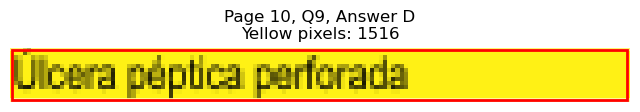

Page 10, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=467.4, y1=687.5
Page 10, Q9, E: Yellow pixels: 182
Page 10, Q9, E: Total non-white pixels: 847
Page 10, Q9, E: Yellow percentage: 21.5%


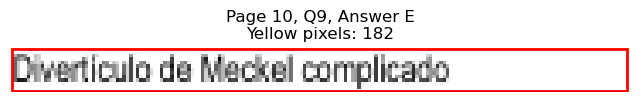


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=85.0, y0=735.8, x1=207.1, y1=747.9
Page 10, Q10, A: Yellow pixels: 1578
Page 10, Q10, A: Total non-white pixels: 2262
Page 10, Q10, A: Yellow percentage: 69.8%


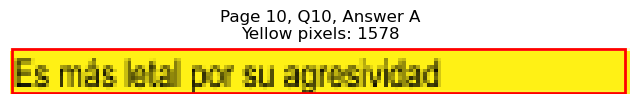

Page 10, Q10 - B: Detected box: x0=85.0, y0=747.8, x1=201.8, y1=759.9
Page 10, Q10, B: Yellow pixels: 163
Page 10, Q10, B: Total non-white pixels: 745
Page 10, Q10, B: Yellow percentage: 21.9%


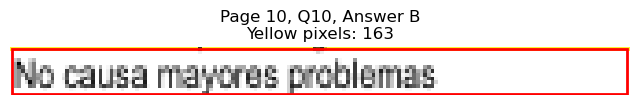

Page 10, Q10 - C: Detected box: x0=85.0, y0=759.8, x1=200.3, y1=771.9
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 582
Page 10, Q10, C: Yellow percentage: 0.0%


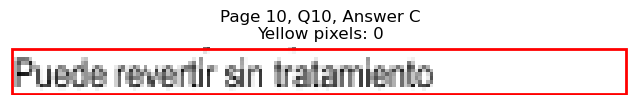

Page 10, Q10 - D: Detected box: x0=336.7, y0=735.8, x1=381.7, y1=747.9
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 213
Page 10, Q10, D: Yellow percentage: 0.0%


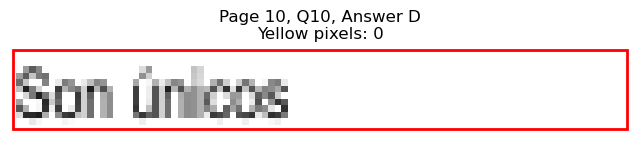

Page 10, Q10 - E: Detected box: x0=336.7, y0=747.8, x1=400.4, y1=759.9
Page 10, Q10, E: Yellow pixels: 0
Page 10, Q10, E: Total non-white pixels: 327
Page 10, Q10, E: Yellow percentage: 0.0%


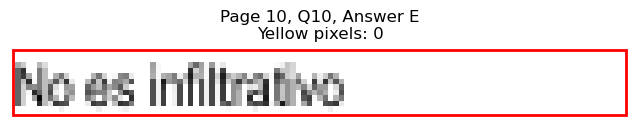


Page 10, Q10 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cómo se denomina el tumor que se origina en l...
1   ¿Qué lesión orienta la maniobra o prueba del c...
2   ¿Cuál es la zona donde las glándulas gástricas...
3   ¿Cuál es la importancia de la medición de la p...
4   ¿En qué días se inicia la fase proliferativa d...
..                                                ...
95  ¿Cuál es la contraindicación relativa para la ...
96  ¿De qué arteria procede principalmente la irri...
97  ¿Cuál es el tratamiento de la mayoría de las f...
98  Varón de 55 años, ingresa a emergencia en mal ...
99  ¿Cuál es una característica del tumor desmoide...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                           Leiomioma   
1          Ligamento cruzado anterior   
2                              Cuerpo   
3               Define el diagnóstico   
4                                 1-3   
..                                ...   
95  Destrucción del sistema de poleas   
96                     Esfenopalatina   
97                     Inmovilización   
98             Perforación intestinal   
99    Es más letal por su agresividad   

                                    option_B  \
0                             Leiomiosarcoma   
1                             Menisco medial   
2                        Región pre pilórica   
3   No tiene ninguna importancia diagnóstica   
4                                       4-12   
..                                       ...   
95                  Lesión de más de 6 horas   
96                           Maxilar externa   
97                          Fijación externa   
98           Divertículo sigmoides perforado   
99                No causa mayores problemas   

                                  option_C  \
0                             Linfosarcoma   
1              Ligamento cruzado posterior   
2                                    Antro   
3               Define la zona de incisión   
4                                    15-20   
..                                     ...   
95  Herida por aplastamiento aún con buena   
96                          Infraorbitaria   
97           Fijación simple con tornillos   
98             Apendicitis aguda perforada   
99          Puede revertir sin tratamiento   

                              option_D  \
0                       Adenocarcinoma   
1                      Menisco lateral   
2                              Cardias   
3   Establece el momento de la cirugía   
4                                25-30   
..                                 ...   
95  Pérdida de tendón superior a 0.5cm   
96                              Facial   
97  Fijación simple interna y tracción   
98            Úlcera péptica perforada   
99                          Son únicos   

                                       option_E  
0                                          GIST  
1                   Ligamento colateral lateral  
2                                         Fondo  
3   Sólo es coadyuvante a la valoración clínica  
4                                 Después de 30  
..                                          ...  
95           Lesión única a lo largo del tendón  
96                             Carótida externa  
97                Fijación interna intramedular  
98             Divertículo de Meckel complicado  
99                           No es infiltrativo  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               E
4               B
..            ...
95              A
96              A
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cómo se denomina el tumor que se origina en l...   
1   ¿Qué lesión orienta la maniobra o prueba del c...   
2   ¿Cuál es la zona donde las glándulas gástricas...   
3   ¿Cuál es la importancia de la medición de la p...   
4   ¿En qué días se inicia la fase proliferativa d...   
..                                                ...   
95  ¿Cuál es la contraindicación relativa para la ...   
96  ¿De qué arteria procede principalmente la irri...   
97  ¿Cuál es el tratamiento de la mayoría de las f...   
98  Varón de 55 años, ingresa a emergencia en mal ...   
99  ¿Cuál es una característica del tumor desmoide...   

                             option_A  \
0                           Leiomioma   
1          Ligamento cruzado anterior   
2                              Cuerpo   
3               Define el diagnóstico   
4                                 1-3   
..                                ...   
95  Destrucción del sistema de poleas   
96                     Esfenopalatina   
97                     Inmovilización   
98             Perforación intestinal   
99    Es más letal por su agresividad   

                                    option_B  \
0                             Leiomiosarcoma   
1                             Menisco medial   
2                        Región pre pilórica   
3   No tiene ninguna importancia diagnóstica   
4                                       4-12   
..                                       ...   
95                  Lesión de más de 6 horas   
96                           Maxilar externa   
97                          Fijación externa   
98           Divertículo sigmoides perforado   
99                No causa mayores problemas   

                                  option_C  \
0                             Linfosarcoma   
1              Ligamento cruzado posterior   
2                                    Antro   
3               Define la zona de incisión   
4                                    15-20   
..                                     ...   
95  Herida por aplastamiento aún con buena   
96                          Infraorbitaria   
97           Fijación simple con tornillos   
98             Apendicitis aguda perforada   
99          Puede revertir sin tratamiento   

                              option_D  \
0                       Adenocarcinoma   
1                      Menisco lateral   
2                              Cardias   
3   Establece el momento de la cirugía   
4                                25-30   
..                                 ...   
95  Pérdida de tendón superior a 0.5cm   
96                              Facial   
97  Fijación simple interna y tracción   
98            Úlcera péptica perforada   
99                          Son únicos   

                                       option_E correct_answer  
0                                          GIST              E  
1                   Ligamento colateral lateral              C  
2                                         Fondo              D  
3   Sólo es coadyuvante a la valoración clínica              E  
4                                 Después de 30              B  
..                                          ...            ...  
95           Lesión única a lo largo del tendón              A  
96                             Carótida externa              A  
97                Fijación interna intramedular              A  
98             Divertículo de Meckel complicado              D  
99                           No es infiltrativo              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/CIRUGIA.csv
